# Visión por Computador - Práctica 2 - Deep Learning en Computer Vision

#### 12 puntos   |   Fecha de entrega: 15 de Diciembre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2425.ugr.es/

### Estudiante: <mark>Julio Pérez Cabeza</mark>



<font color='blue'>El objetivo de esta práctica es aprender a diseñar, implementar, entrenar y utilizar (es decir, aplicar en inferencia) redes neuronales convolucionales en tareas de visión por computador (clasificación y regresión en imágenes) usando fastai (https://docs.fast.ai/).

<font color='blue'>Se proporciona una guía de ayuda (`Assignment_2_HG.ipynb`) para, entre otras cosas, saber cómo:
1. realizar funciones básicas de lectura de datos, entrenamiento y optimización;
2. crear gráficos para la evolución del error de clasificación en
los conjuntos de entrenamiento y validación;
3. y calcular el error de clasificación en el conjunto de prueba.

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color='blue'>**Ejercicio 1: BaseNet en CIFAR100 (3 puntos)**

<font color='blue'>**Dataset:**
En este ejercicio, trabajaremos con parte del conjunto de datos CIFAR100 (https://www.cs.toronto.edu/~kriz/cifar.html). Este conjunto de datos consta de $60000$ imágenes en color de $32\times32\times3$ (RGB) que representan 100 clases diferentes ($600$ imágenes por clase). Hay $50000$ imágenes para entrenamiento y $10000$ para test. No obstante, para el desarrollo del ejercicio solo consideraremos $25$ clases (de $100$). Por lo tanto, el conjunto de entrenamiento tendrá $12500$ imágenes y el conjunto de prueba $2500$ imágenes. Los alumnos deben emplear el $10\%$ del conjunto de entrenamiento para  validación.

<font color='blue'>**Modelo BaseNet:**
Comenzamos creando un modelo base llamado *BaseNet* que consta de dos bloques convolucionales (Conv+ReLU) separados por un proceso de *subsampling* (MaxPooling), y una cabeza compuesta por dos capas completamente conectadas (FC) (también llamadas capas densas). La arquitectura precisa se define en la siguiente tabla:

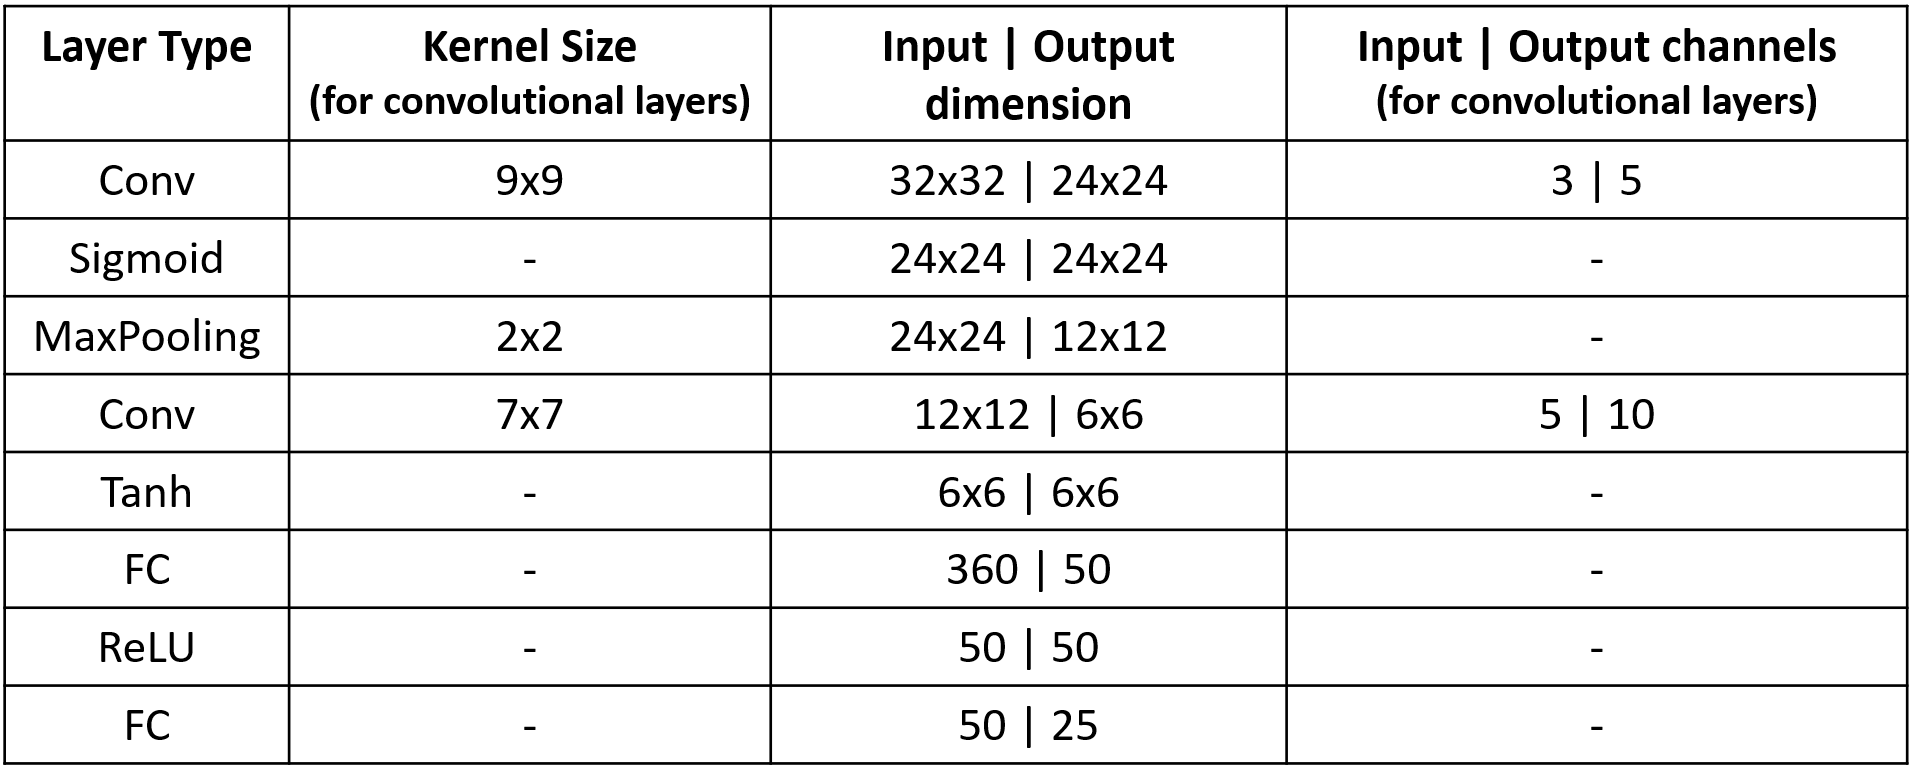

<font color='blue'>Los alumnos deben:
1. Crear el código para el modelo *BaseNet* empleando la librería fastai.
2. Explicar y describir cada una de las capas de la arquitectura *BaseNet*, así como las decisiones de implementación tomadas. Por ejemplo, ¿qué función de pérdida se debería emplear: `CrossEntropyLoss()`, `CrossEntropyLossFlat()` o alguna otra? ¿Se debería incorporar manualmente, en la definición de la red, la función de activación de la capa final (`nn.Softmax()`)? ¿Por qué?
3. Desglosar detalladamente el número de parámetros de esta arquitectura, y cuánto contribuye cada capa a dicho número total. Se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido adecuadamente y que el número de parámetros es correcto (es decir, se corresponde con lo esperado).
4. Entrenar el modelo con _Adam_ (incluyendo _early stopping_ con una paciencia de $5$ durante $25$ épocas) y evaluar su rendimiento. En dicha evaluación se debe emplear/mostrar/analizar: la matriz de confusión en entrenamiento, validación y test; la _accuracy_ en entrenamiento, validación y test; y la evolución, por épocas de entrenamiento, tanto de la función de pérdida (en entrenamiento y validación) como de la _accuracy_ (en validación) y el _F1 score (weighted)_ (en validación).



In [ ]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [ ]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/train'), Path('/root/.fastai/data/cifar100/test')]
[Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cifar100/train/trees'), Path('/root/.fastai/data/cifar100/train/household_furniture'), Path('/root/.fastai/data/cifar100/train/vehicles_2'), Path('/root/.fastai/data/cifar100/train/reptiles'), Path('/root/.fastai/data/cifar100/train/vehicles_1'), Path('/root/.fastai/data/cifar100/train/insects'), Path('/root/.fastai/data/cifar100/train/household_electrical_devices'), Path('/root/.fastai/data/cifar100/train/fish'), Path('/root/.fastai/data/cifar100/train/fruit_and_vegetables'), Path('/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores'), Path('/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes'), Path('/root/.fastai/data/cifar100/train/small_mammals'), Path('/root/.fastai/data/cifar100/train/people'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals'), Path('/r

Vemos que hay 20 clases, pero eso no debe confundirnos. Eso son solo las 20 superclases en que está subdividido el dataset. Véase https://github.com/fastai/dlcert2/blob/master/docs/datasets.md:
"This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. **The 100 classes in the CIFAR-100 are grouped into 20 superclasses**. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)."

In [ ]:
# Queremos verificar que dentro de cada una de las 20 superclases hay 5 clases,
# lo que da las 100 clases que hay. También queremos verificar que el número de imágenes
# es correcto
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
for i in range(20):
  print('Número de clases dentro de superclase ',i,': ', len(train_classes[i].ls()))
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/medium_mammals ):  [Path('/root/.fastai/data/cifar100/train/medium_mammals/skunk'), Path('/root/.fastai/data/cifar100/train/medium_mammals/possum'), Path('/root/.fastai/data/cifar100/train/medium_mammals/raccoon'), Path('/root/.fastai/data/cifar100/train/medium_mammals/porcupine'), Path('/root/.fastai/data/cifar100/train/medium_mammals/fox')]
Número de clases dentro de superclase  0 :  5
Número de clases dentro de superclase  1 :  5
Número de clases dentro de superclase  2 :  5
Número de clases dentro de superclase  3 :  5
Número de clases dentro de superclase  4 :  5
Número de clases dentro de superclase  5 :  5
Número de clases dentro de superclase  6 :  5
Número de clases dentro de superclase  7 :  5
Número de clases dentro de superclase  8 :  5
Número de clases dentro de superclase  9 :  5
Número de clases dentro de superclase  10 :  5
Número de clases dentro de superclase  11 :  5
Número de clases dentro de

Ahora nos quedamos con las primeras 25 clases. Lo que hacemos es eliminar las 75 últimas del dataset.

In [ ]:
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('SUPERCLASES ELIMINADAS:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i])
print('SUPERCLASES CONSERVADAS:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

SUPERCLASES ELIMINADAS:
/root/.fastai/data/cifar100/train/vehicles_1
/root/.fastai/data/cifar100/train/insects
/root/.fastai/data/cifar100/train/household_electrical_devices
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/fruit_and_vegetables
/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/small_mammals
/root/.fastai/data/cifar100/train/people
/root/.fastai/data/cifar100/train/aquatic_mammals
/root/.fastai/data/cifar100/train/food_containers
/root/.fastai/data/cifar100/train/large_man-made_outdoor_things
/root/.fastai/data/cifar100/train/large_carnivores
/root/.fastai/data/cifar100/train/flowers
/root/.fastai/data/cifar100/train/non-insect_invertebrates
SUPERCLASES CONSERVADAS:
/root/.fastai/data/cifar100/train/medium_mammals
/root/.fastai/data/cifar100/train/trees
/root/.fastai/data/cifar100/train/household_furniture
/root/.fastai/data/cifar100/tra

In [ ]:
# También eliminamos las clases en test
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i])

/root/.fastai/data/cifar100/test/vehicles_1
/root/.fastai/data/cifar100/test/insects
/root/.fastai/data/cifar100/test/household_electrical_devices
/root/.fastai/data/cifar100/test/fish
/root/.fastai/data/cifar100/test/fruit_and_vegetables
/root/.fastai/data/cifar100/test/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/test/small_mammals
/root/.fastai/data/cifar100/test/people
/root/.fastai/data/cifar100/test/aquatic_mammals
/root/.fastai/data/cifar100/test/food_containers
/root/.fastai/data/cifar100/test/large_man-made_outdoor_things
/root/.fastai/data/cifar100/test/large_carnivores
/root/.fastai/data/cifar100/test/flowers
/root/.fastai/data/cifar100/test/non-insect_invertebrates


Ahora intentamos verificar si los hemos eliminado realmente.

In [ ]:
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


Y que el número de ejemplos en training y test es el correcto.

In [ ]:
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/medium_mammals ):  [Path('/root/.fastai/data/cifar100/train/medium_mammals/skunk'), Path('/root/.fastai/data/cifar100/train/medium_mammals/possum'), Path('/root/.fastai/data/cifar100/train/medium_mammals/raccoon'), Path('/root/.fastai/data/cifar100/train/medium_mammals/porcupine'), Path('/root/.fastai/data/cifar100/train/medium_mammals/fox')]
Total training images:  12500
Total test images:  2500


Podemos observar que ahora tenemos el dataset tal y como nos interesa, con 12500 imágenes de entrenamiento y 2500 de test.

#### **Uso de DataBlock y DataLoader**
Ahora vamos a proceder a cargar los datos de entrenamiento. Para ello hacemos uso de DataLoaders y DataBlock.

Tutoriales de referencia: https://fastai.github.io/fastai-docs/tutorial.datablock y https://dirk-kalmbach.medium.com/datablock-and-dataloaders-in-fastai-d5aa7ae560e5

`DataBlock` y `DataLoader` son clases de la biblioteca `fastai` para el procesamiento de datos. Proporcionan muchos métodos útiles para facilitar el manejo de datos. Siempre que se use FastAI, se deberá usar DataLoader.

Un DataLoader, se puede definir como su propia clase, una extensión de DataLoader de `Pytorch` o como una subclase de DataBlock, que es lo que haremos en esta práctica. Para ello, lo primero que haremos será definir un DataBlock, especificando los siguientes campos o parámetros:

* `blocks`: Especifica el tipo de dato que estamos pasando. Al usar (ImageBlock,CategoryBlock), estamos diciendo que los datos son de tipo imagen y una categoría, o clase, asociada.
* `get_items`: Indica de donde obtener los datos. Haremos uso de `get_image_files`, que se usa pasándole un path y devuelve la lista de imágenes.
* `splitter`: Controla cómo se crea el conjunto de validación. Aquí usaremos los parámetros de RandomSplitter, para hacer que el conjunto de validación sea del $10\%$. Además, como hacíamos en las prácticas de AA, usaremos la semilla 42 para mayor reproducibilidad.

  > [The story behind random.seed(42) in Machine Learning](https://medium.com/geekculture/the-story-behind-random-seed-42-in-machine-learning-b838c4ac290a)

* `get_y`: Este parámetro especifica cuáles serán las etiquetas a usar para nuestros datos. La etiqueta parent_label representa el nombre de la carpeta padre de donde se extrae la muestra y serán las etiquetas.

Existen muchos más parámetros para la creación de los DataBlock's, pero nos quedaremos con estos pues satisfacen las restricciones puestas en el enunciado.

Por último, ahora solo queda crear el DataLoader que nos permitirá iterar por nuestros datos y acceder a ellos de manera muy sencilla. Para ello, usaremos el objeto **`dblock`** ya creado, llamando a su subclase dataloader.

$$$$

<img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> En la creación del dataloader, usamos el parámetro `bs = 32`, que maneja el batch size, es decir, el número de muestras que vamos a ir tomando para recorrer el dataset. Para su elección, se revisa [https://arxiv.org/pdf/1206.5533], Yoshua Bengio, 2012.

En dicho paper, se establece que 32 es un buen valor (las potencias de 2 lo suelen ser) por temas puramente computacionales y de GPU's, y afecta más bien al *training time* más que al *test performance*. También en clase lo discutimos y se habló de escoger un **batch size** conforme a la complejidad del dataset y la red que vayamos a implementar. Como nuestro caso no es excesivamento complejo usaremos 32. (En el paper se discuten muchos más hiperparámetros de las RRNN)

Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250


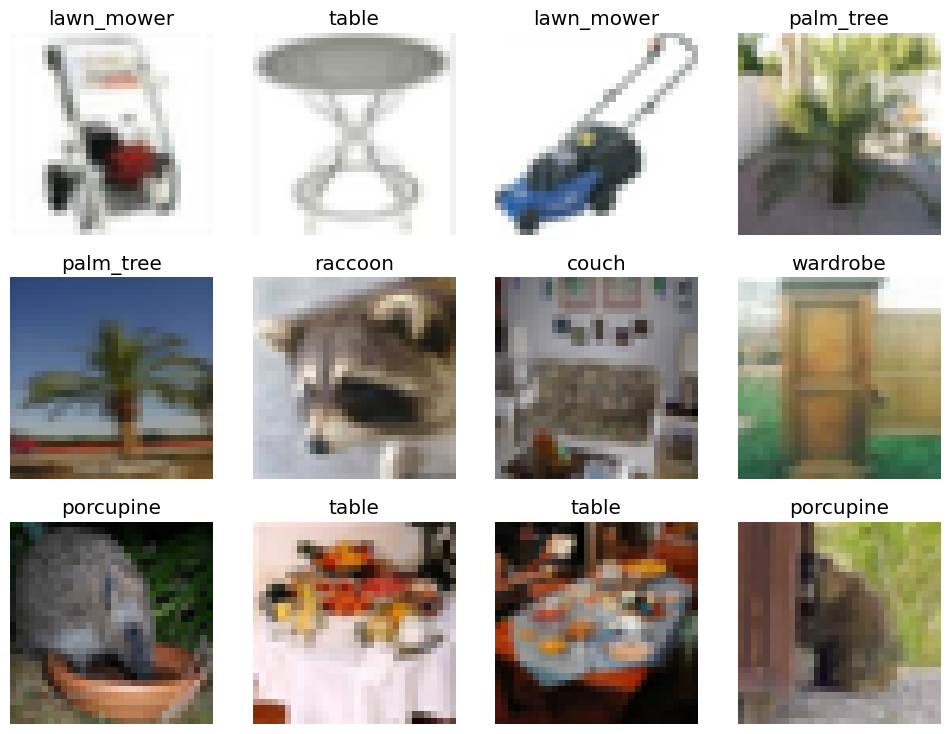

In [ ]:
from fastai.data.all import *
from fastai.vision.all import *

dblock = DataBlock(
                    blocks    = (ImageBlock, CategoryBlock),
                    get_items = get_image_files,
                    splitter  = RandomSplitter(valid_pct = 0.1, seed = 42),
                    get_y     = parent_label
                  )

dls = dblock.dataloaders(path/'train', bs = 32)

dls.show_batch(max_n=12)

print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dls.train_ds))
print('Numero de ejemplos de validacion:', len(dls.valid_ds))

Example of training data


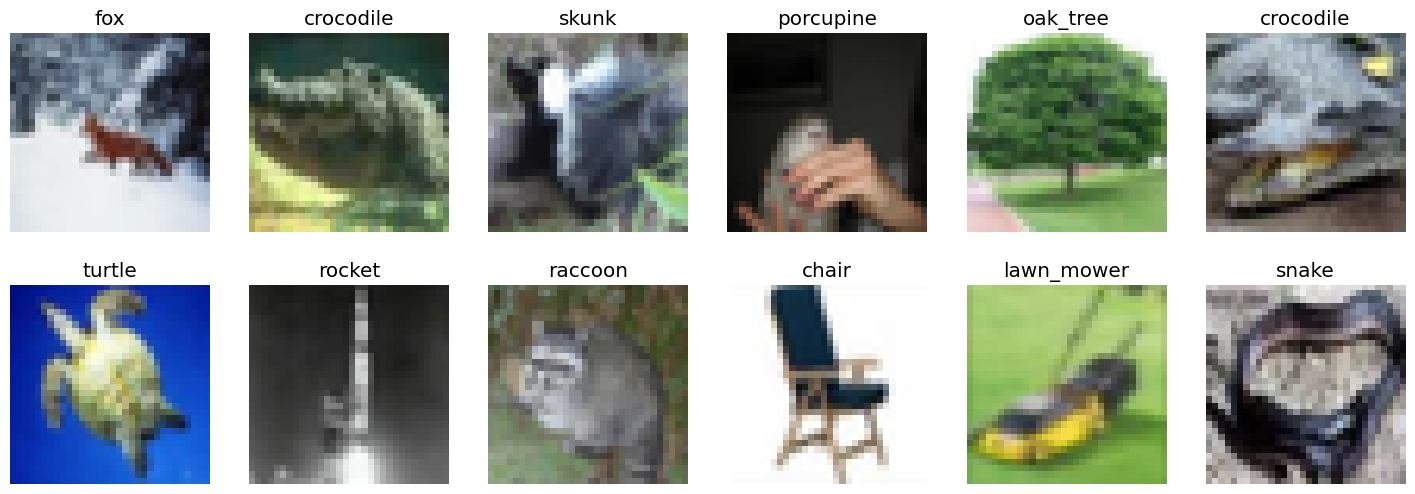

In [ ]:
print('Example of training data')
dls.train.show_batch(max_n=12, nrows=2)

Example of validation data


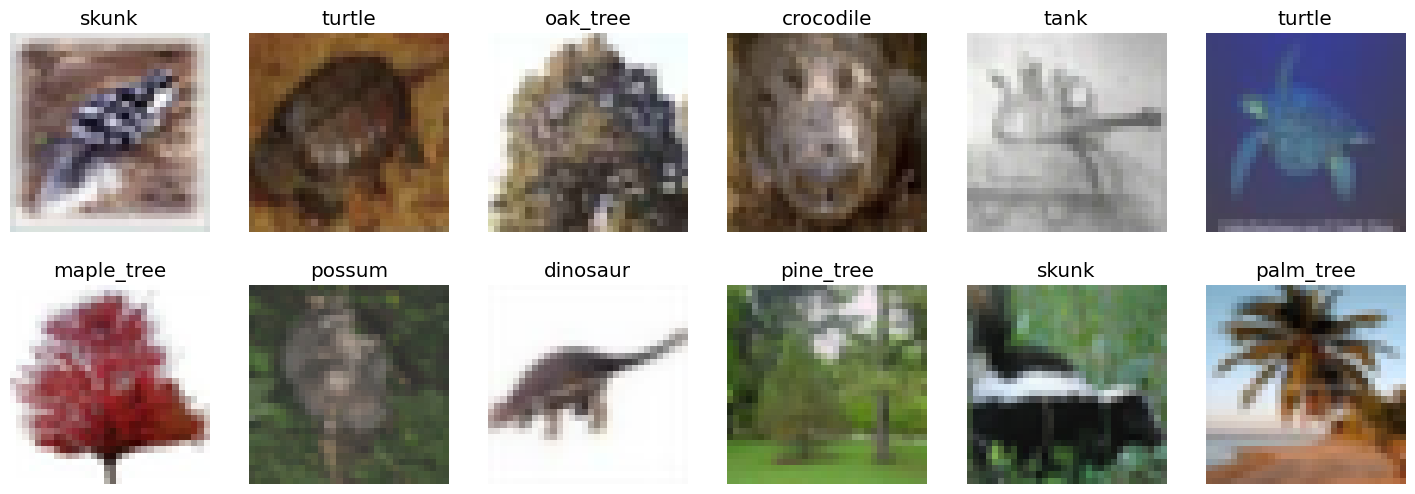

In [ ]:
print('Example of validation data')
dls.valid.show_batch(max_n=12, nrows=2)

Ahora procedemos con la creación y entrenamiento de la red **BaseNet**.

#### **Definición y análisis de BaseNet**

Procedemos ahora al análisis de cada una de las capas, con el respectivo cálculo de pesos para confirmar que estamos definiendo la red correctamente.

$$$$

**Introducción a deep learning**

Hablaremos de *deep learning*, en general, siempre y cuando usemos redes neuronales para entrenar, modelar y predecir con nuestros datos.

Tal y como se ha visto en clase, las redes neuronales cuentan con:

  1. **Neuronas**: Son las que reciben las entradas, las procesan haciendo una suma ponderada de los pesos (asignando una *importancia*) y después aplican una función de activación que va a modificar la salida.
  2. **Capas**: Son las que definimos explícitamente cuando las programamos y determinan el funcionamiento interno de la red.
  3. **Conexiones**: Son los pesos por los que se van a ir multiplicando las entradas de las neuronas y vamos a ir entrenando.

Las redes neuronales son capaces de, a través de las capas, ir aprendiendo características **de más bajo a más alto nivel**, es un aprendizaje jerárquico.

$$$$

**Motivación de las convolucionales**: Pues bien, el principal problema de las redes neuronales es su complejidad pues cada conexión representa un peso a entrenar, y como ya sabemos, cuantos más pesos tengamos que entrenar más costoso nos resultará. La idea general por la que surgen las **redes convolucionales** es esta idea, pues se pretende cubrir problemas en los que los datos se presentan en forma de matriz y se ha de tratar con muchos pesos. El uso de filtros y la reducción de la dimensionalidad conforme se avanza en la red, hace que el número de pesos total, se vea altamente reducido.

De esta manera, se consigue que **el número de operaciones sea mucho menor** *(Conectividad dispersa)* y que el **número de parámetros a aprender también se reduzca** (*weight sharing*). El paper original de Yann LeCun en [https://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf], publicado en el año 98 habla de estos conceptos, entre otros, y forma las bases sobre las innovadoras redes convolucionales.

$$$$

Cualquier red que tenga, al menos, una capa convolucional, diremos que es una red convolucional. Ahora los pesos a aprender serán los filtros o kernels usados en las convoluciones (explicadas en la práctica anterior).

En general, las redes convolucionales siguen el esquema de la siguiente imagen:

<center><img src=https://miro.medium.com/v2/resize:fit:1200/1*XEPeVUd1ePhcE1-MU_eWsg.png></center>

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Imagen extraída de https://bootcampai.medium.com/redes-neuronales-convolucionales-5e0ce960caf8

Para nuestro caso, **BaseNet**, va a tener una estructura muy parecida. Veámos cómo se define a nivel de código para explicar después qué función tiene cada capa y cuántos pesos se van aprendiendo:

In [ ]:
import fastai.optimizer as optim
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback

BaseNet = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size = (9,9), padding = 'valid'),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size = (2,2)),
    nn.Conv2d(in_channels = 5, out_channels = 10, kernel_size = (7,7), padding = 'valid'),
    nn.Tanh(),
    nn.Flatten(),
    nn.Linear(in_features = 360, out_features = 50),
    nn.ReLU(),
    nn.Linear(in_features = 50, out_features = 25)
    #nn.Softmax() - No, no es necesario
)

learn = Learner(dls,
                BaseNet,
                loss_func = CrossEntropyLossFlat(),
                metrics = [accuracy, F1Score(average='weighted')],
                opt_func = optim.Adam,
                cbs = EarlyStoppingCallback(min_delta=0.01, patience=5)
                )

BaseNet

Sequential(
  (0): Conv2d(3, 5, kernel_size=(9, 9), stride=(1, 1), padding=valid)
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1), padding=valid)
  (4): Tanh()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=360, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=25, bias=True)
)

**Explicación capa a capa de BaseNet**

1. **Conv2d**: *`Conv2D`* en *FastAI*. Dimensión de profundidad de 3 de entrada (tres canales para RGB) y dimensión 5 para la salida. Es decir, aplicamos $5$ filtros o *kernels* de tamaño 9x9, con *stride* 1 (vamos celda a celda) y `padding = 'valid'` que indica que queremos que la imagen reduzca su dimensión, pues perdemos 4 filas por arriba, 4 por abajo, 4 por la izquierda y 4 por la derecha. Como función de activación usaremos la función **sigmoide**:

  - Su nombre viene de su forma de $S$ y toma valores de 0 a 1. Generalmente, se usa en problemas de clasificación binaria y en la última de las capas, pues su salida puede ser interpretada como probabilidades.

  <center><img src = https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/Funci%C3%B3n_sigmoide_01.svg/300px-Funci%C3%B3n_sigmoide_01.svg.png></center>

  > <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Imagen extraída de https://es.wikipedia.org/wiki/Funci%C3%B3n_sigmoide

  - **Número de pesos en la capa**: $9$x$9$x$3$+$1$ por filtro $\implies 244$ x $5 filtros$. En total **1220**. (Más abajo podemos comprobar que estamos haciendo bien los cálculos)

  $$$$

2. **Capa de maxPooling**: Reduce dimensionalidad para añadir invarianza a pequeñas traslaciones de la entrada (los números del dataset pueden aparecer rotados y trasladados ligeramente en cada instancia). Lo hacemos con tamaño $2$x$2$. Cambiamos el tamaño de cada celda $2$x$2$ por el máximo de los valores, para cada uno de los filtros.

<center><img src='https://th.bing.com/th/id/R.81a0fa489ea440d54e72513f5a4c0b35?rik=JOf4RGdDTdVkNA&pid=ImgRaw&r=0&sres=1&sresct=1' width="500" height="200"></center>

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Imagen extraída de https://computersciencewiki.org/index.php/Max-pooling_/_Pooling

En esta capa no se añaden pesos, pero sí que cambia la **dimensión de la imagen a la mitad**.

$$$$

3. **Capa de convolución**: De nuevo, realizamos una convolución pero ahora con tamaño de $7$x$7$ de kernel, con un input de 5 (los filtros que teníamos) y un output de 10.

  - Ahora usaremos como función de activación otra función bastante común que es la **tangente hiperbólica**. Es una función no lineal y permite mapear valores negativos a salidas negativas, a diferencia de la sigmoide. Se usa generalmente en capas ocultas de una red neuronal, ya que sus valores se encuentran entre -1 y 1, por lo que la media de la capa oculta resulta ser 0 o muy cerca de ella, lo que ayuda a centrar los datos al acercar la media a 0. Esto facilita mucho el aprendizaje de la siguiente capa.

<center><img src = https://upload.wikimedia.org/wikipedia/commons/thumb/8/87/Hyperbolic_Tangent.svg/250px-Hyperbolic_Tangent.svg.png></center>

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Imagen extraída de https://es.wikipedia.org/wiki/Tangente_hiperb%C3%B3lica

  - **Número de pesos en la capa**: $7$x$7$x$5$+$1$ por filtro $\implies 246$ x $10 filtros$. En total **2460**.

  $$$$

4. **Capa *Fully-Connected***: Se conectan todas y cada una de las neuronas de la capa anterior con todas y cada una de las neuronas de la siguiente. Después de las capas convolucionales y de pooling en una CNN, las capas totalmente conectadas se utilizan para combinar las características extraídas y **aprender interacciones complejas** entre ellas. Estas capas permiten que la red aprenda combinaciones de características de alto nivel que son útiles para la clasificación. Se hace la conexión con 50 neuronas nuevas.

  - Usaremos la función de activación **ReLU**. Esta función presenta **no linealidad para valores mayores que 0**, de manera que la red se puede ajustar así a problemas más complejos que no se reduzcan a un problema lineal. Una de las ventajas que tiene esta función es que ReLU produce salidas escasas. Esto significa que, en promedio, solo una parte de las neuronas estarán activas en cualquier momento dado, lo cual puede ayudar a reducir el riesgo de sobreajuste.

 <center><img src='https://miro.medium.com/max/4362/1*TbZnkZYI5vwOQGUBd6uXAQ.png' width="400" height="200"></center>

 > <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Imagen extraída de https://towardsdatascience.com/activation-functions-in-neural-networks-83ff7f46a6bd

  - **Número de pesos en la capa**: $(360 + 1)$x$50$. En total **18050**. 360 pues al ir reduciendo la dimensinalidad a base de convoluciones y pooling, ahora tenemos imágenes de $6$x$6$ por $10$ = $360$.

**Para conectar todas las neuronas se debe hacer un *flattening* previo, es decir, convertir todos los pesos a un vector unidimensional para que todas las neuronas puedan conectarse entre ellas. Esto nos deja $6$x$6$x$10$ neuronas, $360$.**

$$$$

  5. **Capa *Fully-Connected***: Hacemos lo mismo pero ahora con 25 neuronas nuevas. La diferencia ahora radica en la función de activación.

    - **Respondiendo a la pregunta del enunciado**: No, no es necesario poner explicitamente la función de pérdida *Softmax()*, que se encargaría normalmente de asignar probabilidades entre 0 y 1 para cada una de las clases a predecir. Esto se debe a la implementación interna de **`CrossEntropyLossFlat()`** de FastAI. Por defecto, esta función de pérdida tiene asociada la función Softmax y por tanto no es necesario añadir una capa `nn.Softmax()` al final de nuestra red.

    Ver https://docs.fast.ai/losses.html

  $$$$

    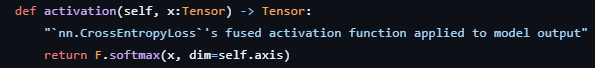

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Imagen extraída del github donde se encuentra la implementación de la función de pérdida https://github.com/fastai/fastai/blob/master/fastai/losses.py#L65

  - **Número de pesos en la capa**: $(50 + 1)$x$25$. En total **1275**.

In [ ]:
learn.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 5 x 24 x 24    
Conv2d                                    1220       True      
Sigmoid                                                        
____________________________________________________________________________
                     32 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 6 x 6     
Conv2d                                    2460       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 360            
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

**Comprobación de exactitud de los pesos**

Si hacemos la suma de todos los pesos que fuimos calculando previamente:

* $1220 + 2460 + 18050 + 1275 = 23005$

Coincide justo con lo mostrado con el *summary()*, `Total trainable params: 23,005`.

$$$$

**Función de pérdida**

Como se ha mencionado antes, se ha de usar `CrossEntropyLossFlat()` como función de pérdida en el entrenamiento. La pérdida de entropía cruzada mide la diferencia entre las probabilidades predichas y las etiquetas verdaderas de una tarea de clasificación multicase, como es nuestro caso.

La pérdida de entropía cruzada también tiene una forma suave y convexa, lo que facilita que los métodos de optimización basados en gradientes encuentren el mínimo global. Es importante elegir bien la función de pérdida pues todo el proceso de actualización de pesos depende de ella.

Como se nos indicó en clase, se debe usar la versión que hace *Flattening* de las probabilidades pues si se usa la versión normal, da lugar a un mal manejo de dichas probabilidades.

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> https://www.linkedin.com/advice/0/what-advantages-disadvantages-using-cross-entropy?lang=es&originalSubdomain=es

$$$$

**Optimizador**

En este ejercicio, se nos pide usar el optimizador **Adam**, que hace uso de dos técnicas de gradiente descendiente:

1. **Momentum**: El momentum ayuda a acelerar el entrenamiento al promediar los gradientes, de forma que se eviten oscilaciones en la dirección de la convergencia.

  Se veía en clase:

<center><img src=https://kh-kim.github.io/nlp_with_deep_learning_blog/assets/images/1-11/03-momentum_example.png height = '200' width = '300'></center>

2. **Root mean square prop or RMSprop**: Propuesto por <font color = 'blue'>Geoff Hinton (aunque nunca publicado)<font color = 'black'>, es un método también adaptativo de aprendizaje. Ajusta la tasa de aprendizaje para cada parámetro de manera adaptativa, dividiendo el gradiente por la raíz cuadrada de la media móvil de los gradientes al cuadrado. Esto estabiliza la  actualización y evita problemas de convergencia.

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> https://media.geeksforgeeks.org/wp-content/uploads/20200909192459/LMGM.png

De esta manera se obtiene un Gradiente Descendiente mejorado y optimizado, que es el que usaremos para este ejercicio.

###**Discusión de hiperparámetros y entrenamiento de la red**

Lo primero que hacemos es tratar de encontrar un **learning rate** adecuado para nuestra red. Conocemos el verdadero problema de escoger un buen learning rate, que no sea demasiado alto, ni demasiado bajo.

Por la motivación de encontrar un buen *lr*, surgieron los **learning rates cíclicos**. Son computacionalmente mucho más eficientes pues consisten, en lugar de usar uno fijo, oscilar entre un máximo y mínimo razonables. Esto es:
<center><img src = https://iconof.com/static/5077dd3668a084c1059abce622ab4310/a5f2a/clr.webp height = 200></center>

De esta manera, nos despreocupamos de encontrar el **mejor** de los learning rates y nos aseguramos que estamos trabajando con valores aporoximados óptimos. Pero para conseguir esta cota, necesitamos hacer un test: La prueba consiste en ejecutar un modelo durante varias épocas, donde la tasa de aprendizaje comienza con un valor bajo y aumenta linealmente hasta alcanzar un valor alto. Un gráfico de pérdida frente al *lr* muestra cuándo el error comienza a mejorar, cuándo se desacelera, se vuelve irregular o disminuye. Escogiendo el conocido **valle** de la gráfica, nos asegura que el learning rate usado para el entrenamiento será una **buena aproximación**.

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Muy interesante la lectura de https://iconof.com/1cycle-learning-rate-policy/

$$$$

Para ello, FastAI nos permite usar `lr_find()` asociado al objeto Learner para encontrar ese valle. El método nos devuelve un *lr* sugerido que nos permite tener ese rango adecuado antes del entrenamiento.

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Aproximación learning rate: 7.585775892948732e-05


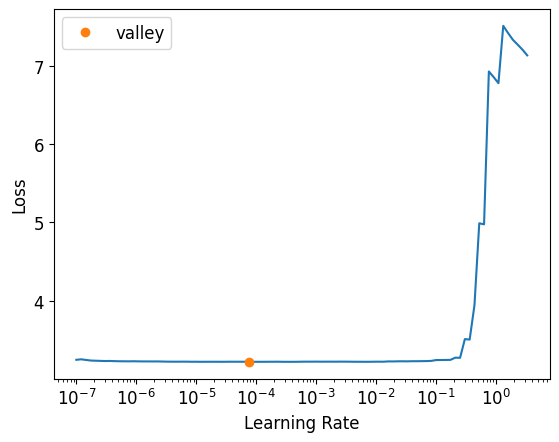

In [ ]:
lr = learn.lr_find() #Aproximamos un learning rate decente
#https://walkwithfastai.com/lr_finder
print("Aproximación learning rate:", lr.valley)

Ahora que ya tenemos una aproximación de nuestro *learning rate* o tasa de aprendizaje, podemos proceder ya al entrenamiento de nuestro modelo. Como se nos indica en el enunciado, usaremos **25 épocas** de entrenamiento y **early stopping** con paciencia de 5 épocas.

Usaremos el método **`fit_one_cycle`** (también se puede usar `fit()` o `fine_tune()`, este último encapsula a `fit_one_cycle`).

Este método tiene que ver con la super convergencia de los modelos y se ha observado que, en efecto, conduce a los mismos resultados que un entrenamiento convencional pero en muchas menos épocas:

<center><img src = https://iconof.com/static/36d3bd4cde3661e4f9bbde7c173c87ba/4072a/lr_vs_clr_resnet56.webp height = 300></center>

Se utiliza el método explicado de las tasas cíclicas, pero con un solo ciclo, que contiene dos etapas: una creciente y otra decreciente, y un límite máximo de tasa de aprendizaje grande (pasado como parámetro `lr_max`). El tamaño del ciclo debe ser menor que el número total de iteraciones/épocas. Una vez que se completa el ciclo, la tasa de aprendizaje deberá disminuir aún más durante las iteraciones/épocas restantes, reduciéndose varios órdenes de magnitud por debajo de su valor inicial. Smith llamó a esto la política de **1cycle**.


> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Ver [https://arxiv.org/abs/1708.07120]

$$$$

**¿Tiene sentido usar Adam y fit_one_cycle?**

Realizando la práctica me surge la duda anterior, pues ambos son optimizadores y tratan ambos con la actualización de los pesos y el ajuste del *learning rate*.


> <font color = 'gray'> Respuesta de GPT: [...] El método fit_one_cycle combina el entrenamiento con un ciclo de tasas de aprendizaje (learning rate) que ayuda a encontrar el óptimo de manera eficiente. Aunque Adam ajusta dinámicamente las tasas de aprendizaje para cada peso, el ciclo de tasas de aprendizaje afecta el escalado general, lo que puede mejorar la convergencia y ayudar al modelo a evitar mínimos locales o sobreajustes.

De lo leído y de la respuesta que me da chatGPT entiendo que son métodos complementarios. Digamos que uno trabaja a nivel más **local**, para cada uno de los pesos, mientras que `fit_one_cycle` ayuda a la convergencia **global** del modelo. De hecho, leyendo más tarde 'P2_HG.ipynb' me doy cuenta de que `fit_one_cycle()` usa por defecto Adam.


No improvement since epoch 19: early stopping


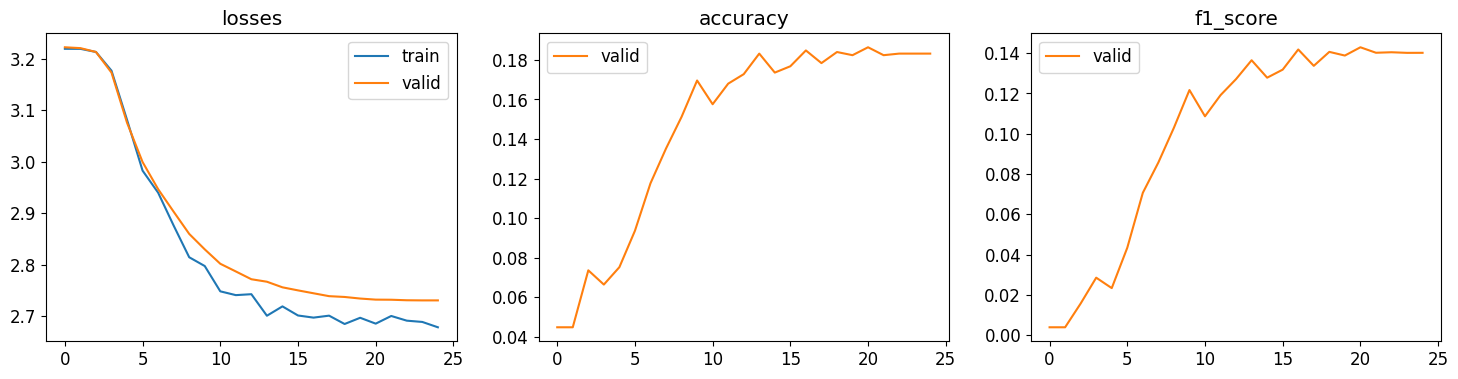

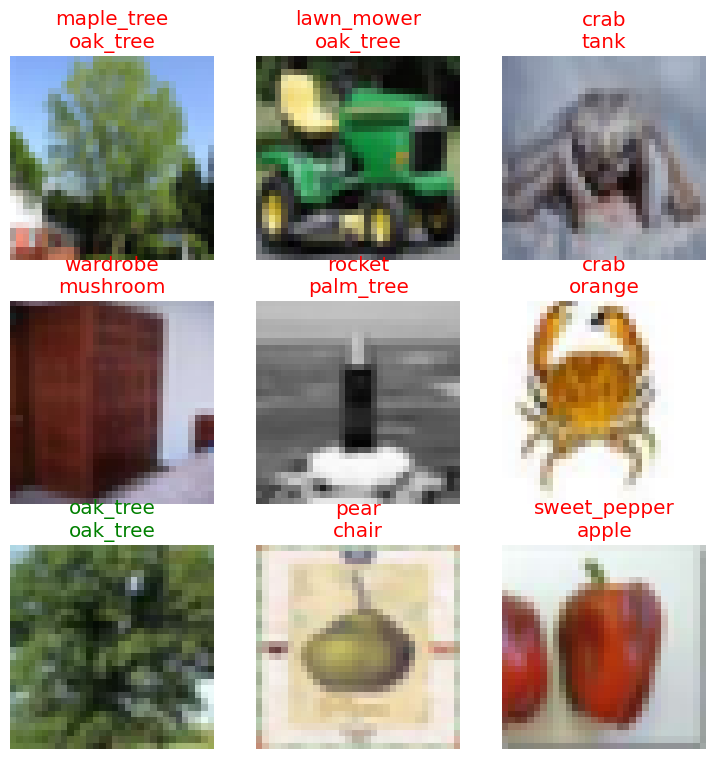

In [ ]:
learn.fit_one_cycle(n_epoch = 25, lr_max = lr.valley)
learn.recorder.plot_metrics()
learn.show_results()

**Early Stopping**

El early stopping es una técnica utilizada en el entrenamiento de redes neuronales, para evitar el sobreajuste (*overfitting*). Funciona deteniendo el entrenamiento cuando el modelo deja de mejorar en el conjunto de datos de validación. Para ello, se hace un monitoreo de cierta métrica (por defecto el error en validación), y se usan los parámetros `min_delta` y `patience`, que determinan cuánto se ha de mejorar para continuar el entrenamiento y las épocas que puede continuar sin que exista esa mejora, respectivamente.

<center><img src = https://images.deepai.org/glossary-terms/39e320caf3864fe5ad55073728ea929c/early-stopping-machine-learning.jpg height = '200'></center>

Haremos uso de los callbacks que tiene FastAI para el objeto Learner:

`cbs = EarlyStoppingCallback(min_delta=0.01, patience=5)`, donde podemos modificar los dos parámetros a nuestra elección.

$$$$

**Resultados del entrenamiento**

Arriba se muestra, por épocas, los resultados del entrenamiento con las métricas, **train loss**, **valid loss**, **accuracy** y **f1 score** (media armónica entre la Precisión y la Sensibilidad (o Recall)), así como el tiempo de entrenamiento para cada una de las épocas.

Un vistazo rápido a las **gráficas de entrenamiento** nos dice que realmente parece que la red sí que ha aprendido algo. Es decir, parece que la curva toma una forma que decrece rápido hacia abajo, algo que en un entrenamiento normal suele pasar. El problema es que deja de decrecer demasiado rápido, pues se queda en una accuracy demasiado baja en las épocas marcadas. Parece que no es capaz de aprender más que eso. Buscamos un entrenamiento parecido **en forma**, pero que baje a valores de *loss* mucho más pequeños.

> Tambien se muestra mediante la funcionalidad `show_results()` que muestra algunos de los ejemplos predichos, en verde si lo han hecho bien y en rojo si lo han hecho mal.

En cuanto al **generalization gap**, parece que no estamos realizando ni *overfitting* ni *underfitting*. Eso sí, los resultados son pésimos, tanto en train como en validación. Veámoslo mejor:

The train accuracy is :  19.8844 %


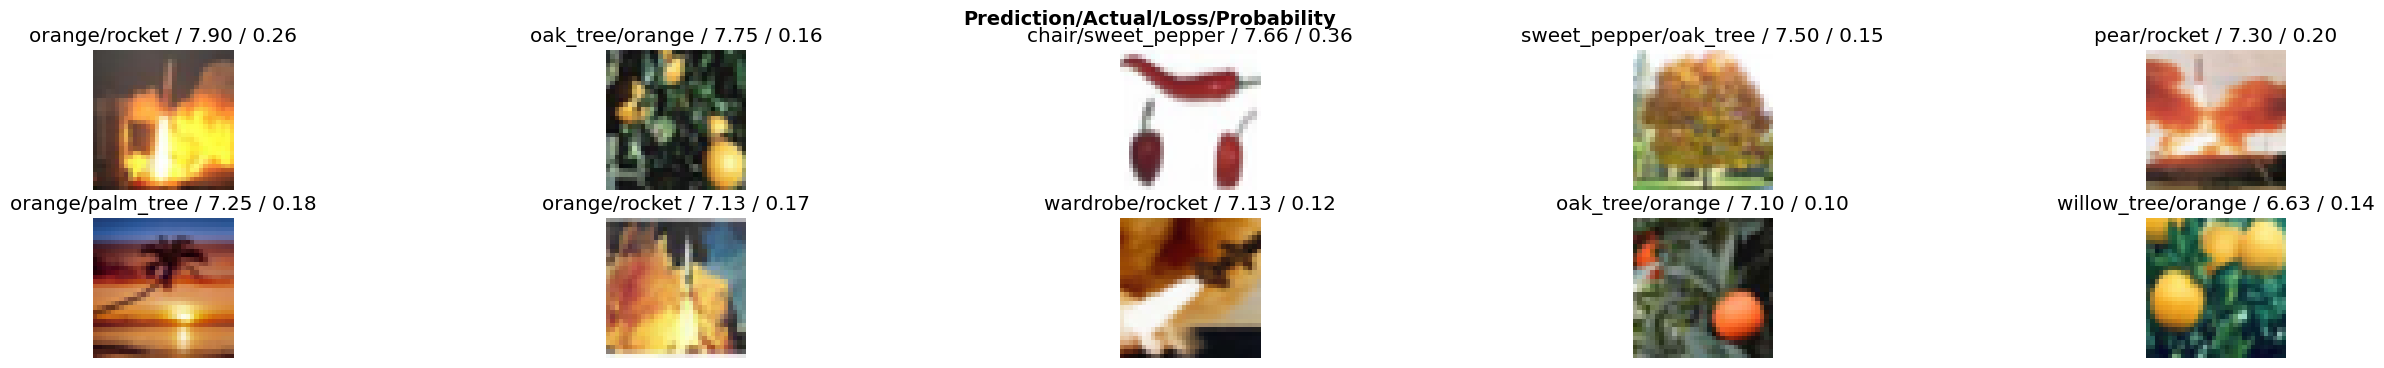

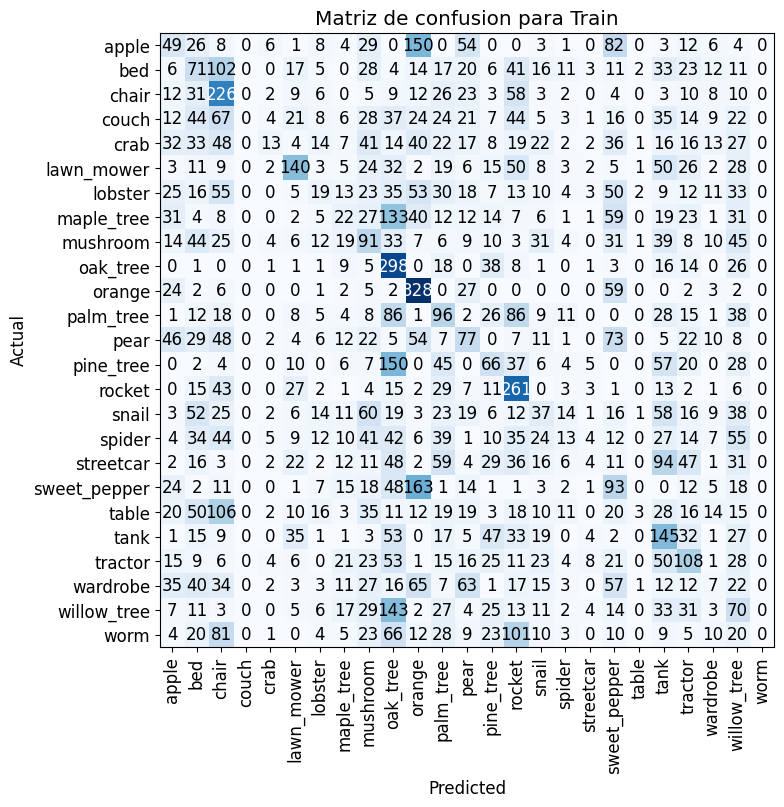

In [ ]:
interp_train = ClassificationInterpretation.from_learner(learn, 1,dls.train)
# we display the n classes with higher confusion level
interp_train.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=dls.train, with_decoded=True)

acc = accuracy(preds, targs)
print('The train accuracy is : ', round(float(acc)*100, 4), '%')

interp_train.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Train')

Tenemos una *accuracy* del $19.88\%$ para el conjunto de **entrenamiento**, lo cual en un problema de clasificación es un resultado bastante mejorable. Nuestra red solo ha sido capaz de clasificar bien una instancia de cada cinco.

$$$$
**Matriz de confusión**

En el caso del problema de **clasificación multiclase**, la matriz de confusión tiene una estructura en la que las filas representan las clases verdaderas y las columnas representan las clases predichas. Cada celda de la matriz contiene el recuento de instancias en las que la clase verdadera (fila) fue clasificada como la clase predicha (columna).

\begin{array}{c|ccc}
& \text{Clase A} & \text{Clase B} & \text{Clase C} \\
\hline
\text{Clase A} & 10 & 2 & 0 \\
\text{Clase B} & 1 & 15 & 3 \\
\text{Clase C} & 0 & 1 & 12 \\
\end{array}

Por ejemplo, en la primera fila y la primera columna, se encuentran los verdaderos positivos para la clase A (10 instancias), en la segunda fila y la tercera columna se encuentran los falsos negativos de la clase B (3 instancias).

Por tanto, parece que lo ideal en una clasificación casi perfecta sería encontrarse con **una matriz diagonal**, en que siempre coinciden real y predicha. Vemos que en nuestra matriz de entrenamiento estamos muy lejos de esto, pues tenemos grandes cantidades de instancias mal clasificadas.

$$$$

Veámos ahora **validación**:

The validation accuracy is :  18.32 %


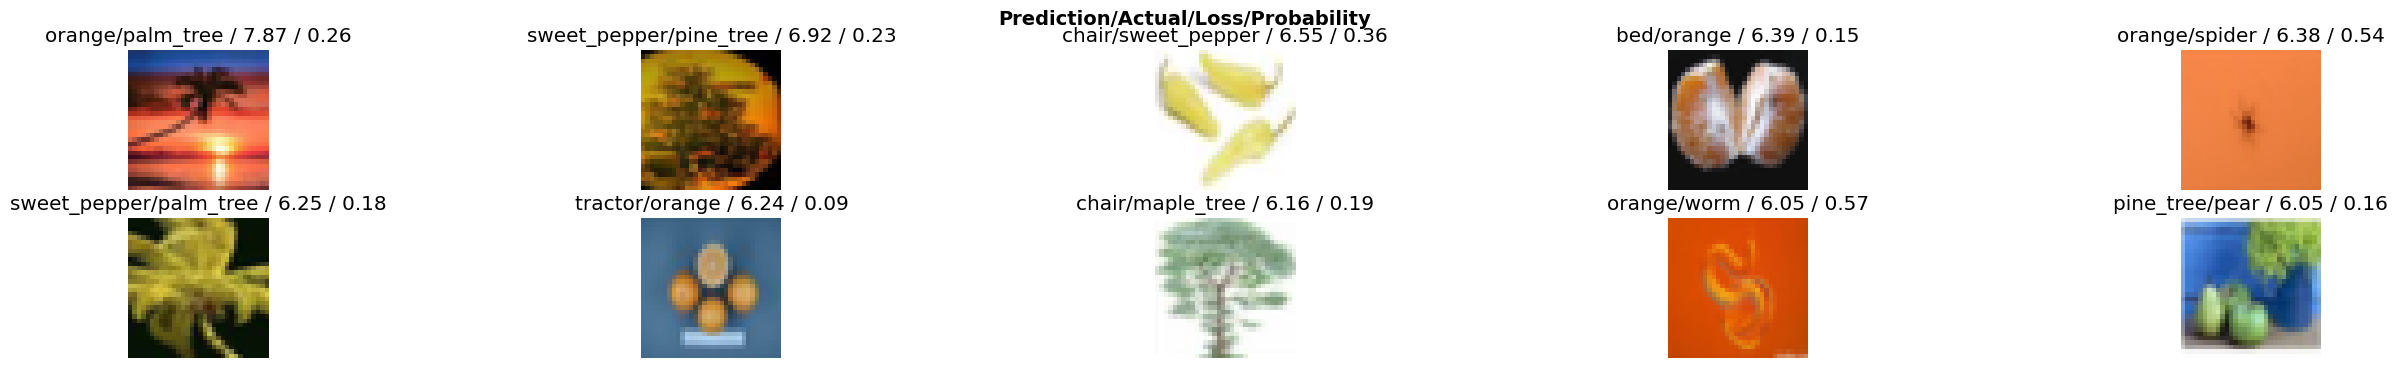

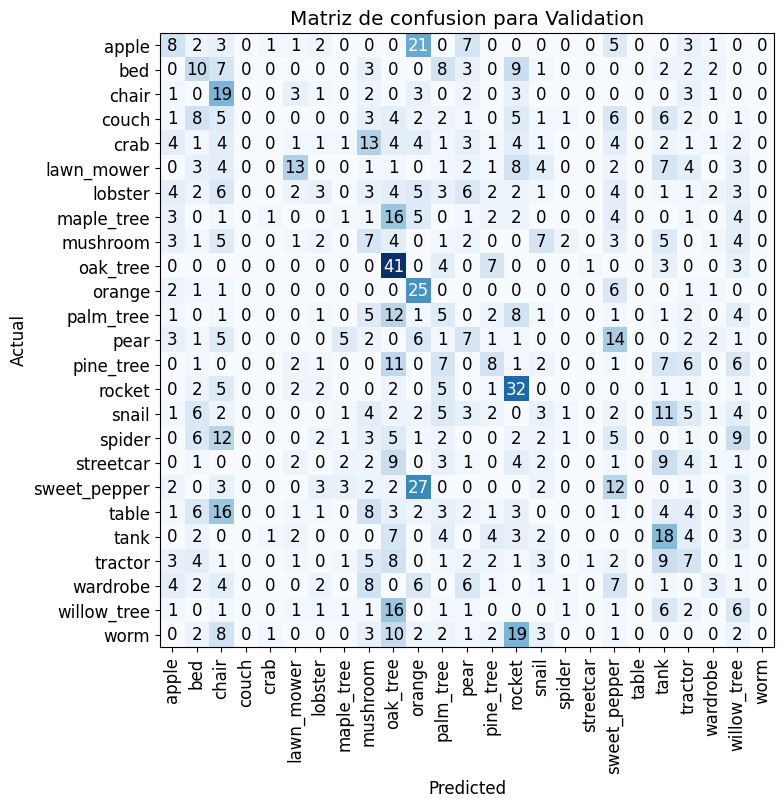

In [ ]:
interp_valid = ClassificationInterpretation.from_learner(learn, 1,dls.valid)

preds, targs, _ = learn.get_preds(dl=dls.valid, with_decoded=True)

acc = accuracy(preds, targs)
print('The validation accuracy is : ', round(float(acc)*100, 4), '%')

interp_valid.plot_top_losses(10, nrows=2, figsize=(32,4))
interp_valid.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Validation')

Para **validación** tenemos un *accuracy* del $18.32\%$. De nuevo, un resultado bastante pobre. Se espera, en el segundo ejercicio, que seamos capaces de obtener hasta un $65\%$ de *accuracy* en validación, por lo que todavía estamos bastante lejos de este resultado.

$$$$

Por último, como se nos pide en el enunciado, mostramos *accuracy* también en **test**, así como la matriz de confusión correspondiente a este conjunto de datos:

The test accuracy is :  19.32 %


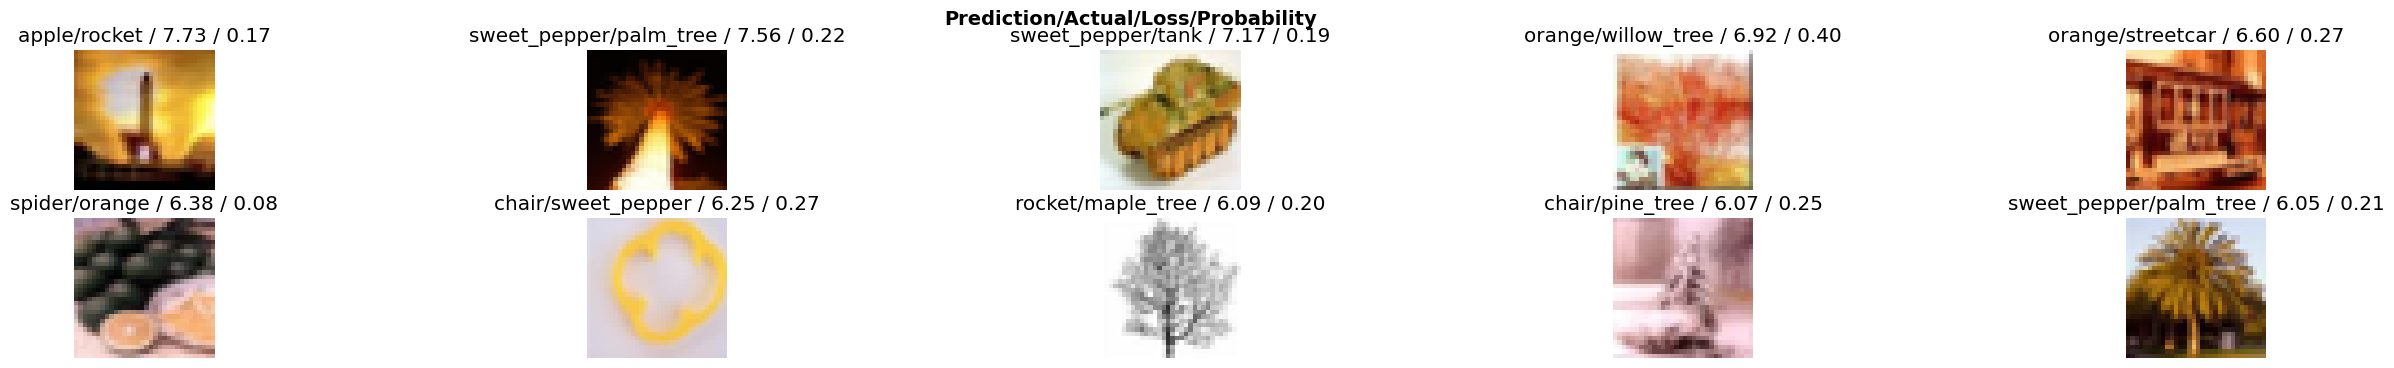

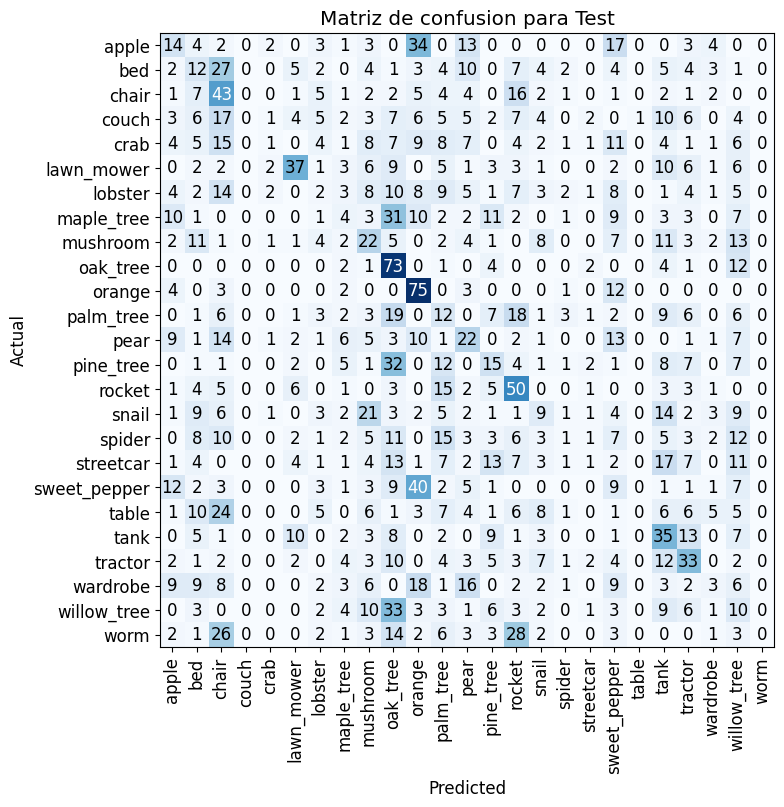

In [ ]:
test_dl = learn.dls.test_dl(files_test,with_labels=True)

preds, targs, _ = learn.get_preds(dl=test_dl, with_decoded=True)


acc = accuracy(preds, targs)
print('The test accuracy is : ', round(float(acc)*100, 4), '%')


interp_test = ClassificationInterpretation.from_learner(learn, 1,test_dl)
interp_test.plot_top_losses(10, nrows=2, figsize=(32,4))
interp_test.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Test')

Para el conjunto de **test**, obtenemos una accuracy del $19.32\%$, una generalización acorde a los resultados obtenidos para train y validación. Podría haber ocurrido que la *accuracy* en test hubiese sido mucho peor que la de *train* y *validación*, que hubiese indicado una clara falta de aprendizaje y generalización. Parece que lo que se ha aprendido es correcto, pues aplica también para el conjunto de test. Esto puede ser un indicativo de que lo que realmente está fallando es la estructura e implementación de la red, veámoslo en profundidad:

$$$$

**Conclusiones**

Observar las gráficas de entrenamiento, así como las métricas por épocas, ya discutimos en clase que es crucial, pues nos proporciona información muy relevante del proceso de aprendizaje.

De las obtenidas en este ejercicio se deduce que sí, se está aprendiendo algo. La loss va decreciendo mientras que la accuracy y el f1-score van creciendo. De esto se intuye entonces que la capacidad de mejora de la red es bastante amplia, pues con una estructura bastante simple, y teniendo en cuenta la complejidad no trivial del conjunto CIFAR10, hemos obtenido cierto aprendizaje.

Las posibles razones que encuentro que expliquen los resultados obtenidos son:

* **Falta de profundidad**: Hemos creado una red con dos capas convolucionales y dos fully connected, que suele ser la estructura usada en una red convolucional usual, pero seguramente necesitemos añadir profundidad a la red, sobre todo mediante capas convolucionales, para que la extracción de características sea de mayor calidad.

* **Simplicidad de la red**: Como se ha mencionado, estamos usando la red convolucional por defecto. Además, el número de pesos que obtenemos nos da pistas sobre la capacidad de aprendizaje de la red.

* **Técnicas de mejora de la red**: No hemos usado ninguna de las técnicas que de manera teórica y empírica sabemos que mejoran tanto el entrenamiento como la generalización de las redes.

$$$$

Sabiendo todo esto pasamos al siguiente ejercicio donde itentaremos paliar los problemas presentes en BaseNet, así como implementar técnicas vistas en clase de mejora de la red.



---



---



---



# <font color='blue'> **Ejercicio 2:** **Mejoras sobre el modelo BaseNet (4 puntos)**
<font color='blue'>Ahora el objetivo es crear una versión mejorada del modelo _Base Net_ (implementado en el anterior apartado). Para ello, se puede experimentar con distintas funciones de activación, funciones de pérdida, una mayor o menor profundidad de la red, un mayor o menor número de filtros por bloque convolucional, y/o diferentes técnicas de regularización u optimización, entre otras. De hecho, los alumnos deben sentirse libres para experimentar e incorporar todas las modificaciones que consideren pertinentes, incluyendo elementos no vistos ni en teoría ni en prácticas (por ejemplo, componentes que hayan podido descubrir a través de la revisión de artículos científicos). **Se valorará la originalidad y complejidad de la propuesta realizada.**

<font color='blue'>Es necesario destacar que **es imprescindible justificar de la mejor forma posible las decisiones tomadas** (ya sea mediante evidencia empírica o mediante literatura científica), **así como el rendimiento obtenido** (esto es, intentar explicar qué es lo que hace que mejore tanto el rendimiento). También es importante remarcar que **las mejoras introducidas, dentro de lo posible, deben realizarse de forma incremental**, es decir, no basta con crear directamente (de forma mágica) un único modelo y evaluarlo:  **es necesario justificar y describir qué pasos y resultados intermedios nos han llevado a diseñar ese modelo concreto**. Se debe describir cada una de las mejoras incorporadas, así como analizar los resultados obtenidos (del mismo modo que se hizo en el Ejercicio 1, y empleando los mismos criterios de partida; por ejemplo, usando un $10\%$ de los ejemplos de entrenamiento para validación). También es necesario, al igual que en el Ejercicio 1, desglosar el número de parámetros del modelo final, y se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido correctamente y que el número de parámetros se corresponde con lo esperado.  

<font color='blue'>Como referencia para los estudiantes, se espera que la _accuracy_ en validación alcance, como mínimo, el $65\%$.


####**Discusión de BaseNet**

En la última sección del ejercicio 1 se discutían las posibles razones por las que obtuvimos resultados no muy aceptables para BaseNet.

A la vista de los resultados, podemos extraer varias conclusiones, o al menos aproximar qué es lo que realmente está ocurriendo. Para ello, vamos a ir dando pasos en la que considero que será la dirección correcta y creando y modelando nuevas redes, que llamaremos **BaseNet$_i$**, para cada $i$ desde 1 hasta el último de los modelos que creemos.

Para que sea una compación justa, usaremos el mismo número de épocas para todos los entrenamientos, y, tal y como nos indica el enunciado, **usando el mismo criterio de validación**.

$$$$
**Estandarización de los datos**

Antes de continuar probando nuevos modelos de red, considero que una buena práctica sería la de normalizar los datos. **Data normalization** es un proceso que suele ser común en todos los procesos de Aprendizaje Automático y Deep Learning.

Generalmente, este proceso ayuda a la convergencia de la red, ayuda a evitar sesgos en el entrenamiento y suele aumentar la precisión de los modelos. Existen diversos tipos de normalización, con el objetivo de transformar las características de los datos a una escala común. Para nuestro dataset, aplicaremos una simple **estandarización de los datos**, de manera que se muevan en el intervalo $[0,1]$ y solo haga falta la media y la desviación típica.

Para esto, tenemos que redefinir nuestro dataBlock creado y usar el parámetro `batch_tfms` (*batch transforms*). La variable reservada `cifar_stats` contiene la información de media y desvación típica para CIFAR100.



In [ ]:
dblockNormalized = DataBlock(
                    blocks    = (ImageBlock, CategoryBlock),
                    get_items = get_image_files,
                    splitter  = RandomSplitter(valid_pct = 0.1, seed = 42),
                    get_y     = parent_label,
                    batch_tfms = Normalize.from_stats(*cifar_stats)
                  )

dls = dblock.dataloaders(path/'train', bs = 32)

> <img src = https://static.vecteezy.com/system/resources/previews/017/178/327/original/warning-hazard-sign-on-transparent-background-free-png.png height = '20' width = '20'> Un cambio que va a ser común también a todas y cada una de las redes comentadas a continuación es deshacerse de la función de activación sigmoide para las capas convolucionales. En general, sabemos que una función de activación que funciona muy bien es ReLU, y de hecho es un patrón seguido en general en la creación de redes convolucionales profundas. Ya comentamos en clase que si se usa la sigmoide puede ser que sature los pesos a 0 o 1, y como resultado podríamos encontrarnos con el problema de **vanishing gradients**. Esta es otra de las posibles causas por las que en el ejercicio 1 se hacia tan complicado el entrenamiento. En [https://cs231n.github.io/convolutional-networks/#layerpat], se habla de patrones comunes que sabemos que funcionan, y se habla de ReLU. Lo mismo haremos con la función de activación tangente hiperbólica.

####**BaseNet1 - (Profundidad)**

En primera instancia, en lugar de tratar de introducir directamente las mejoras y técnicas distintas que hemos visto en clase, intentemos ver cuánto podemos mejorar **únicamente cambiando la arquitectura de la red** (profundidad, pesos...).

Por ejemplo, si añadiésemos otra capa más de convolución, en la literatura se suele decir que estamos añadiendo otra fase de características o de extracción de las mismas.

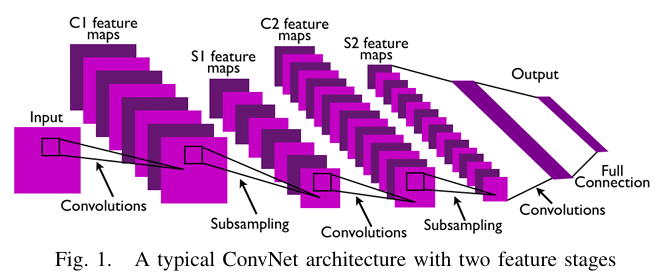

> Véase: https://yann.lecun.com/exdb/publis/pdf/lecun-iscas-10.pdf, Yann LeCun, 2010

De esta manera se consigue que internamente la red aprenda una representación apropiada. En general, en las capas de convolución + subsampling se consigue esa fase de "feature extraction" que más tarde su output se llevará a una parte de clasificador entrenable (parte de capas densas + capa final y softmax). Esto se hace para seguir con el esquema **jerárquico** de aprendizaje que hacen las redes. Siguiendo esta filosofía, también escogeremos filtros de más grandes a más pequeños, para ir aprendiendo patrones globales en imágenes a detalles más sutiles. De esta manera, **aumentamos la profundidad de la red**, de forma que la fase de extracción de características sea de una mejor calidad.

$$$$

Por tanto el primer acercamiento que haremos de mejora será añadir una fase más de extracción de características. Veámos esta arquitectura, analizándo su estructura y los pesos a entrenar.

In [ ]:
import fastai.optimizer as optim
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback

BaseNet1 = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = (9,9), padding = 'valid'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2)),
    nn.Conv2d(in_channels = 10, out_channels = 15, kernel_size = (5,5), padding = 'same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2)),
    nn.Conv2d(in_channels = 15, out_channels = 15, kernel_size = (3,3), padding = 'valid'),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features = 240, out_features = 100),
    nn.ReLU(),
    nn.Linear(in_features = 100, out_features = 25)
)

learn = Learner(dls,
                BaseNet1,
                loss_func = CrossEntropyLossFlat(),
                metrics = [accuracy, F1Score(average='weighted')],
                opt_func = optim.Adam
                )

BaseNet1

Sequential(
  (0): Conv2d(3, 10, kernel_size=(9, 9), stride=(1, 1), padding=valid)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(10, 15, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=240, out_features=100, bias=True)
  (10): ReLU()
  (11): Linear(in_features=100, out_features=25, bias=True)
)

**Análisis de red y de pesos**

Hemos usado entonces una capa convolucional más, añadiendo tambien subsampling. Vamos a analizar por capas entonces el número de pesos y las dimensiones del output para cada una de ellas:

1. Capa convolucional - Output: $(24$x$24$x$10)$ - Pesos: $3$ x $9$ x $9 + 1$ $\implies$ $10$ x $244 = 2440$

2. Pooling - Output: $(12$x$12$x$10)$

3. Capa convolucional - Output: $(12$x$12$x$15)$ - Pesos: $10$ x $5$ x $5 + 1$ $\implies$ $15$ x $251 = 3765$

4. Pooling - Output: $(6$x$6$x$15)$

5. Capa convolucional - Output: $(4$x$4$x$15)$ - Pesos: $15$ x $3$ x $3 + 1$ $\implies$ $15$ x $136 = 2040$

6. Capa FC - Pesos: $(4$ x $4$ x $15) + 1 \implies  100 $ x $ 241 = 24100$

7. Capa FC - Pesos: $(100 + 1)$ x $ 25 =  2525$

**Pesos en total =  34870**

Hacemos `summary()` para comprobar estos cálculos:

In [ ]:
learn.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 10 x 24 x 24   
Conv2d                                    2440       True      
ReLU                                                           
____________________________________________________________________________
                     32 x 10 x 12 x 12   
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 15 x 12 x 12   
Conv2d                                    3765       True      
ReLU                                                           
____________________________________________________________________________
                     32 x 15 x 6 x 6     
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 15 x 4 

Vamos entonces al **entrenamiento** de esta nueva versión de BaseNet. Seguiremos exactamente el mismo esquema que para el primer ejercicio.

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Aproximación learning rate: 0.004365158267319202


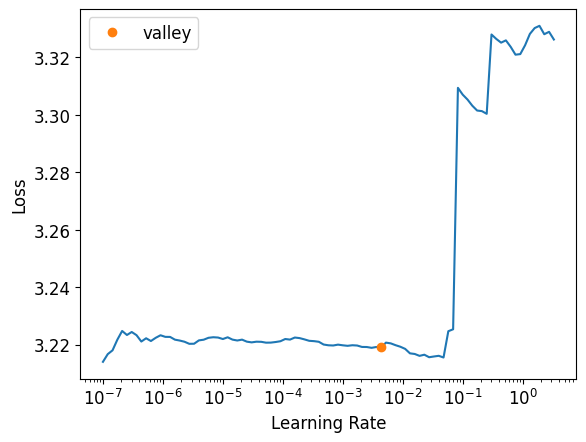

In [ ]:
lr = learn.lr_find()
print("Aproximación learning rate:", lr.valley)

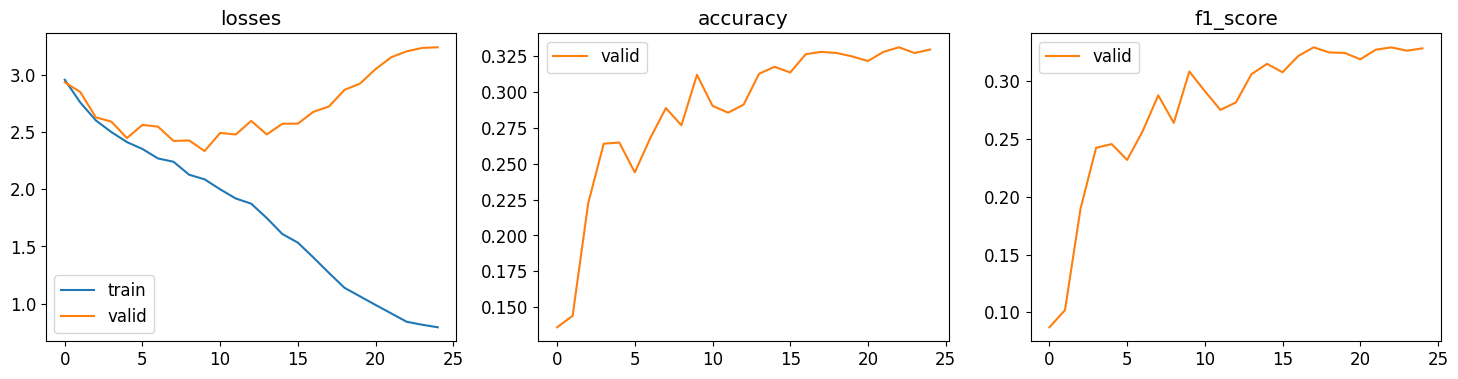

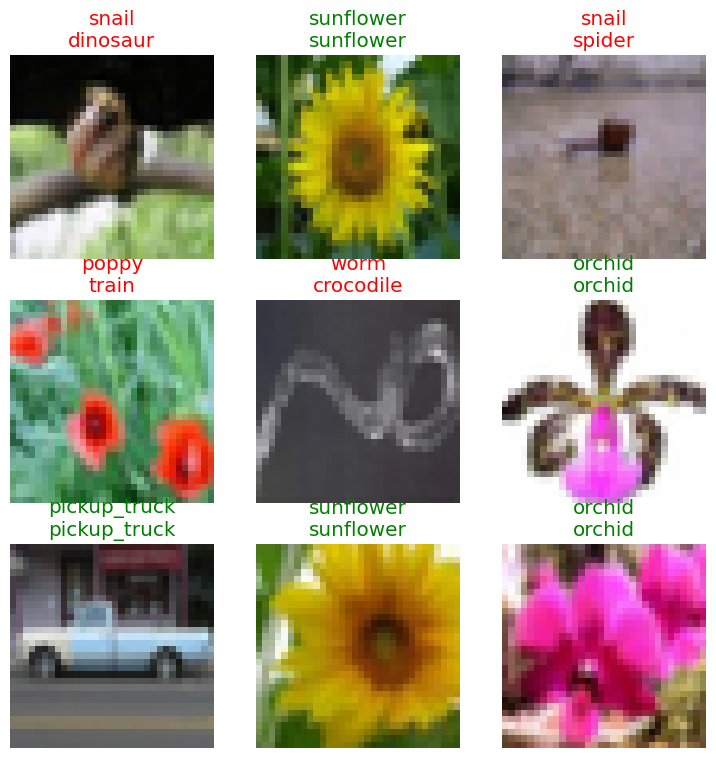

In [ ]:
learn.fit_one_cycle(n_epoch = 25, lr_max = lr.valley)
learn.recorder.plot_metrics()
learn.show_results()

> <img src = https://static.vecteezy.com/system/resources/previews/017/178/327/original/warning-hazard-sign-on-transparent-background-free-png.png height = '20' width = '20'> Tal y como se discutió en clase de prácticas, el cómo se evaluan los modelos creados es bastante delicado, así como sensible a las métricas utilizadas. Así pues, a parte de calcular ahora el **accuracy** para el entrenamiento y validación, también mostraremos **f1_score** para enriquecer el análisis de los resultados. Tener una visión de más de una métrica puede ser decisivo a la hora de tomar decisiones sobre nuestras redes.

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> La diferencia de ambas métricas radica en la visión global que nos proporciona cada una. Accuracy es útil para un panorama general, pero F1-score es crítico para evaluar el desempeño de la red en problemas desbalanceados y penaliza los errores más graves. Usaremos la versión de *scikit-learn*, ya que FastAI la usa internamente, ver [https://docs.fast.ai/metrics.html#f1score]

The train accuracy is :  76.3911 %
The train f1-score is: 76.4052 %


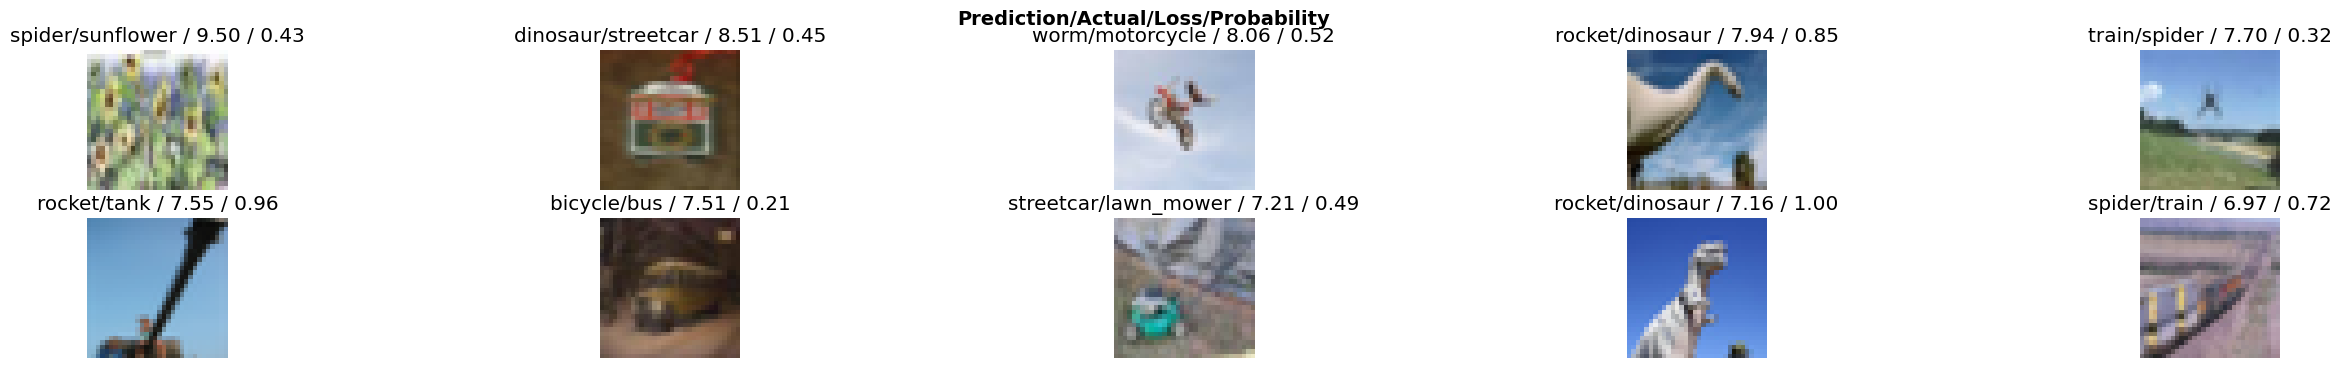

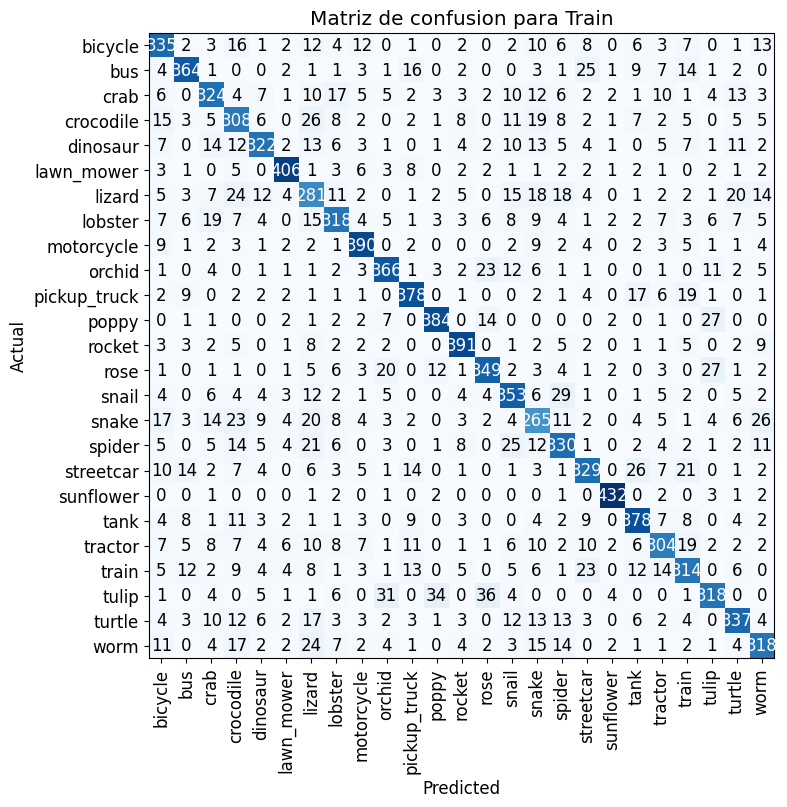

In [ ]:
from sklearn.metrics import f1_score

interp_train = ClassificationInterpretation.from_learner(learn, 1,dls.train)
interp_train.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=dls.train, with_decoded=True)

acc = accuracy(preds, targs)
f1 = f1_score(targs.cpu(), preds.argmax(dim=1).cpu(), average='weighted')
print('The train accuracy is : ', round(float(acc)*100, 4), '%')
print('The train f1-score is:', round(float(f1)*100, 4), '%')

interp_train.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Train')

The val accuracy is :  32.96 %
The val f1-score is: 32.8486 %


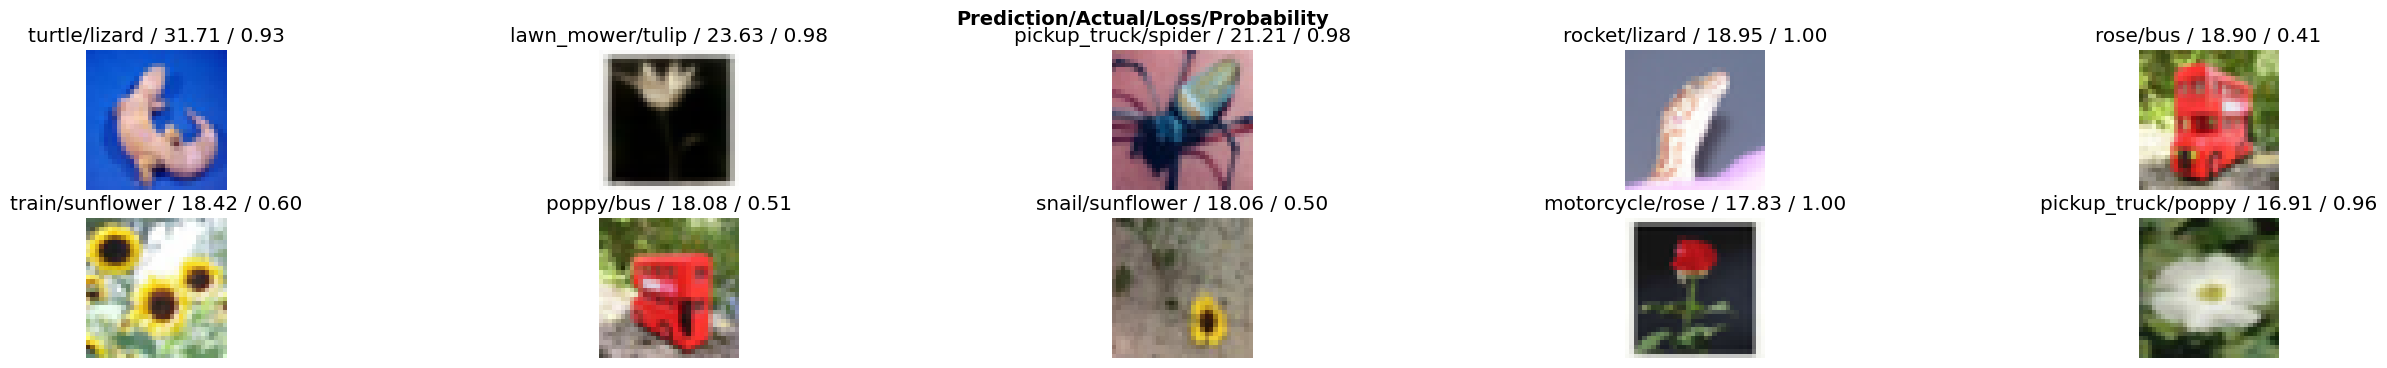

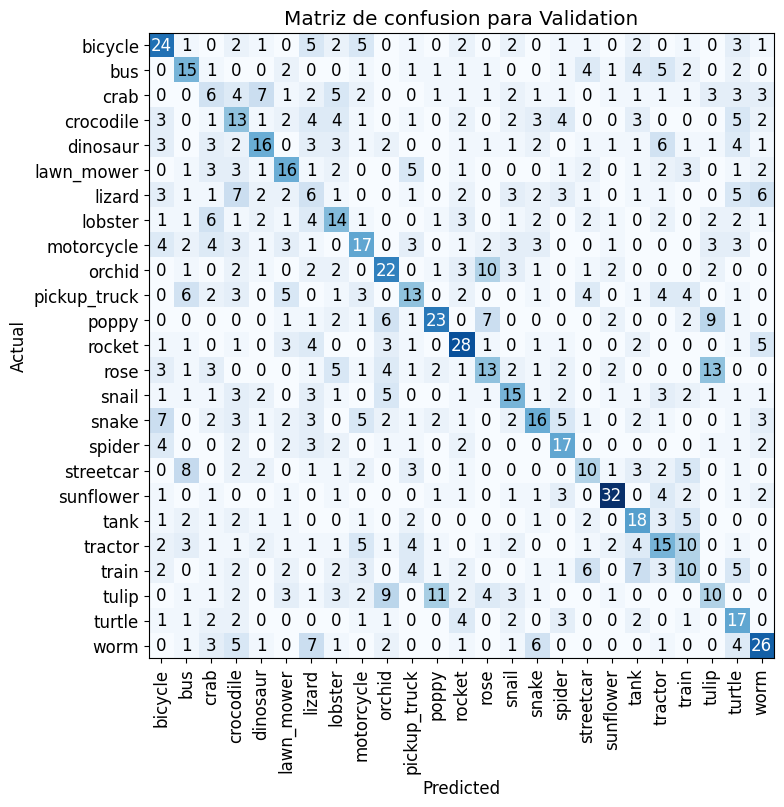

In [ ]:
interp_valid = ClassificationInterpretation.from_learner(learn, 1,dls.valid)

preds, targs, _ = learn.get_preds(dl=dls.valid, with_decoded=True)

acc = accuracy(preds, targs)
f1 = f1_score(targs.cpu(), preds.argmax(dim=1).cpu(), average='weighted')
print('The val accuracy is : ', round(float(acc)*100, 4), '%')
print('The val f1-score is:', round(float(f1)*100, 4), '%')

interp_valid.plot_top_losses(10, nrows=2, figsize=(32,4))
interp_valid.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Validation')

Aparentemente, obtenemos una red de mayor calidad, pues hemos pasado de obtener un 20% a un 70% de accuracy en entrenamiento. Si bien es cierto que sigue siendo un resultado bastante mejorable, es un punto de partida para la mejora de nuestra red. También observamos un gran **overfitting** o sobre ajuste, pero el cómo resolver esto lo haremos más adelante. Ahora nos centramos en tratar de hacer mucho más potente nuestra red.

> <img src = https://static.vecteezy.com/system/resources/previews/017/178/327/original/warning-hazard-sign-on-transparent-background-free-png.png height = '20' width = '20'> Es muy importante recordar que cuando estamos comparando modelos, NUNCA podemos tomar decisiones en función al resultado obtenido en el conjunto de test, pues estaríamos cayendo en malas prácticas de *data snooping*. En los siguientes modelos creados y entrenados, solo se mostrarán los resultados para el conjunto de entrenamiento y de validación.

$$$$

Los resultados obtenidos añadiendo un único bloque convolucional y haciendo cambios en las funciones de activación, nos dan una idea de cómo podemos ir haciendo que la red tenga potencia de entrenamiento. Para el resto de las pruebas, **trataremos de conseguir muy buenos resultados para train (haremos overfitting) para después implementar técnicas de regularización**. Considero que es un buen acercamiento para realizar mejoras progresivas sobre BaseNet.

####**BaseNet2 - (Tamaño de filtros)**
Vamos ahora a probar la misma estructura, pero vamos a modificar los tamaños de los filtros. Leyendo sobre arquitecturas comunes en las ConvNets, se suele recomendar usar **tamaños de filtros pequeños** ($3$x$3$ o $5$x$5$ como mucho) para las capas convolucionales.

En [https://cs231n.github.io/convolutional-networks/] se habla de dicha recomendación y pone algunos ejemplos de redes muy conocidas y usadas que usan filtros más pequeños (LeNet, VGG, ...). Por ello, vamos a crear una red igual de profunda, pero ahora vamos tener filtros muchos más pequeños y el subsampleo lo van a realizar únicamente las capas de *Pooling*.

La razón, en teoría, por lo que este tipo de estructuras suelen dar mejores resultados radica en el hecho de que usar filtros más pequeños nos permite aumentar la profundidad de la red sin perder características observables. Esto es, dos capas $3$ x $3$ encadenados tienen un campo receptivo equivalente a uno $5$ x $5$, pero con menos parámetros y mayor capacidad para aprender representaciones complejas. Además, como hemos comentado, redes muy reconocidas en el mundo del Deep Learning como son **VGG** y **ResNet** usan este tipo de filtros pequeños con mucho éxito.

Véamos como queda la estructura:


In [ ]:
BaseNet2 = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (3,3), padding = 'same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2)),
    nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 'same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2)),
    nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), padding = 'same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2)),
    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 100),
    nn.ReLU(),
    nn.Linear(in_features = 100, out_features = 25)
)

learn = Learner(dls,
                BaseNet2,
                loss_func = CrossEntropyLossFlat(),
                metrics = [accuracy, F1Score(average='weighted')],
                opt_func = optim.Adam
                )

BaseNet2

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=512, out_features=100, bias=True)
  (11): ReLU()
  (12): Linear(in_features=100, out_features=25, bias=True)
)

**Análisis de red y de pesos**

Ahora tenemos que el output en las dos primeras dimensiones solo va a cambiar en las capas de pooling y los filtros que vamos a usar son de $3$x$3$. Vamos a analizar por capas entonces el número de pesos y las dimensiones del output para cada una de ellas:

1. Capa convolucional - Output: $(32$x$32$x$16)$ - Pesos: $3$ x $3$ x $3 + 1$ $\implies$ $16$ x $28 = 448$

2. Pooling - Output: $(16$x$16$x$16)$

3. Capa convolucional - Output: $(16$x$16$x$16)$ - Pesos: $16$ x $3$ x $3 + 1$ $\implies$ $16$ x $145 = 2320$

4. Pooling - Output: $(8$x$8$x$16)$

5. Capa convolucional - Output: $(8$x$8$x$32)$ - Pesos: $16$ x $3$ x $3 + 1$ $\implies$ $32$ x $145 = 4640$

6. Pooling - Output: $(4$x$4$x$32)$

6. Capa FC - Pesos: $(4$ x $ 4 $x$ 32) + 1 \implies 100$ x $513 = 51300$

7. Capa FC - Pesos: $(100 + 1)$ x $25 =  2525$

**Pesos en total =  61233**

Hacemos `summary()` para comprobar estos cálculos:

In [ ]:
learn.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 16 x 32 x 32   
Conv2d                                    448        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 16 x 16 x 16   
MaxPool2d                                                      
Conv2d                                    2320       True      
ReLU                                                           
____________________________________________________________________________
                     32 x 16 x 8 x 8     
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 32 x 8 x 8     
Conv2d                                    4640       True      
ReLU                                          

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Aproximación learning rate: 0.0006918309954926372


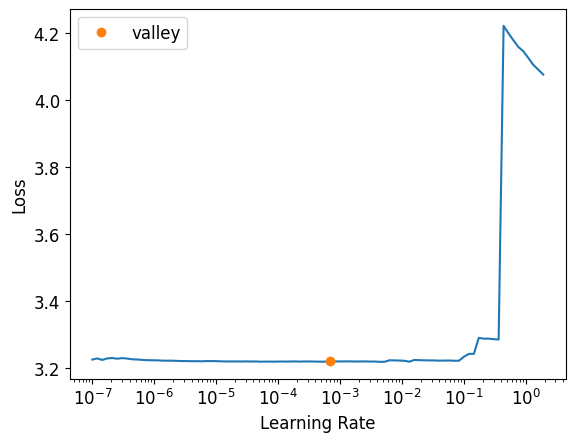

In [ ]:
lr = learn.lr_find()
print("Aproximación learning rate:", lr.valley)

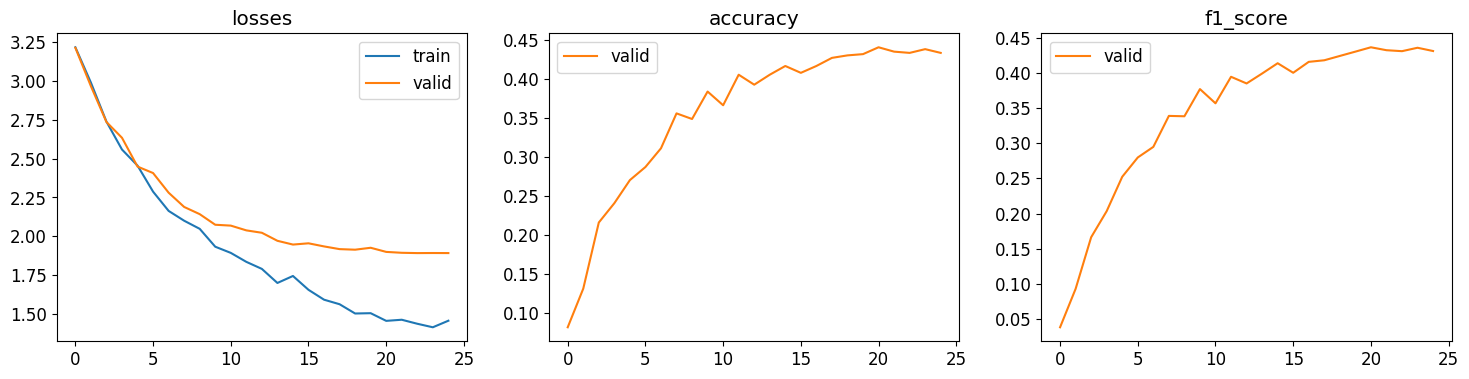

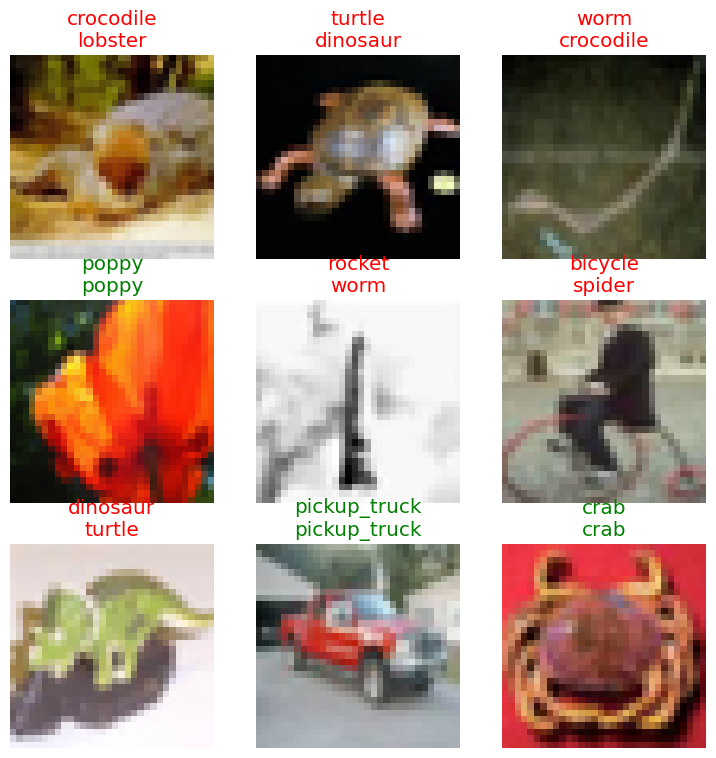

In [ ]:
learn.fit_one_cycle(n_epoch = 25, lr_max = lr.valley)
learn.recorder.plot_metrics()
learn.show_results()

The train accuracy is :  56.0089 %
The train f1-score is: 55.838 %


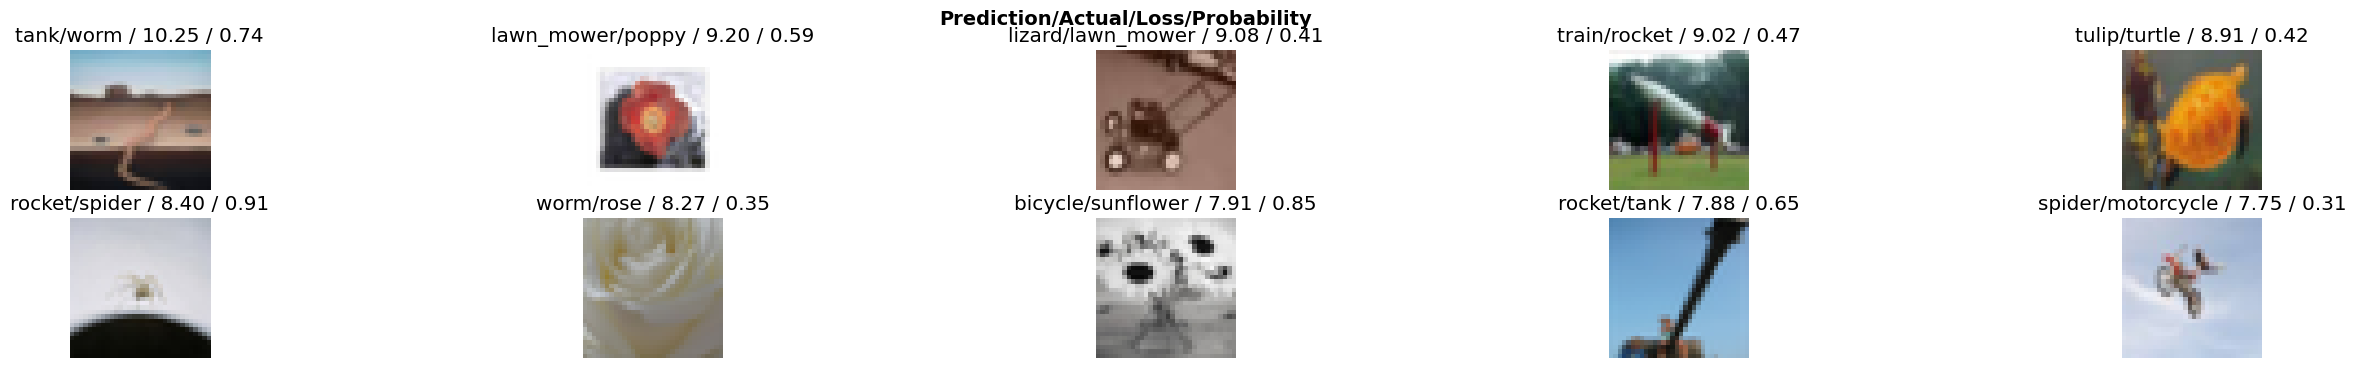

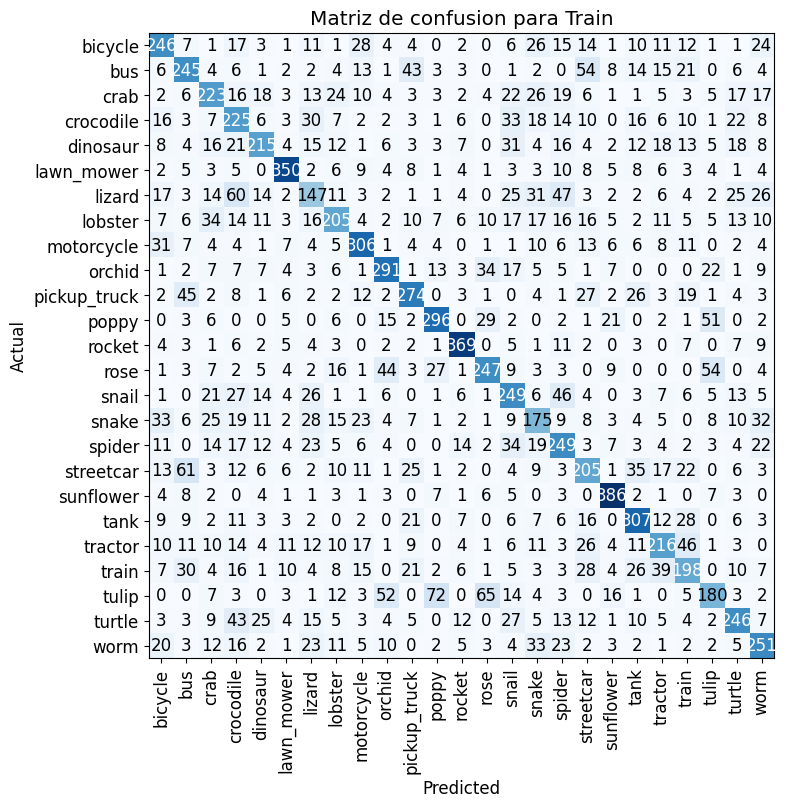

In [ ]:
from sklearn.metrics import f1_score

interp_train = ClassificationInterpretation.from_learner(learn, 1,dls.train)
interp_train.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=dls.train, with_decoded=True)

acc = accuracy(preds, targs)
f1 = f1_score(targs.cpu(), preds.argmax(dim=1).cpu(), average='weighted')
print('The train accuracy is : ', round(float(acc)*100, 4), '%')
print('The train f1-score is:', round(float(f1)*100, 4), '%')

interp_train.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Train')

The val accuracy is :  43.36 %
The val f1-score is: 43.1024 %


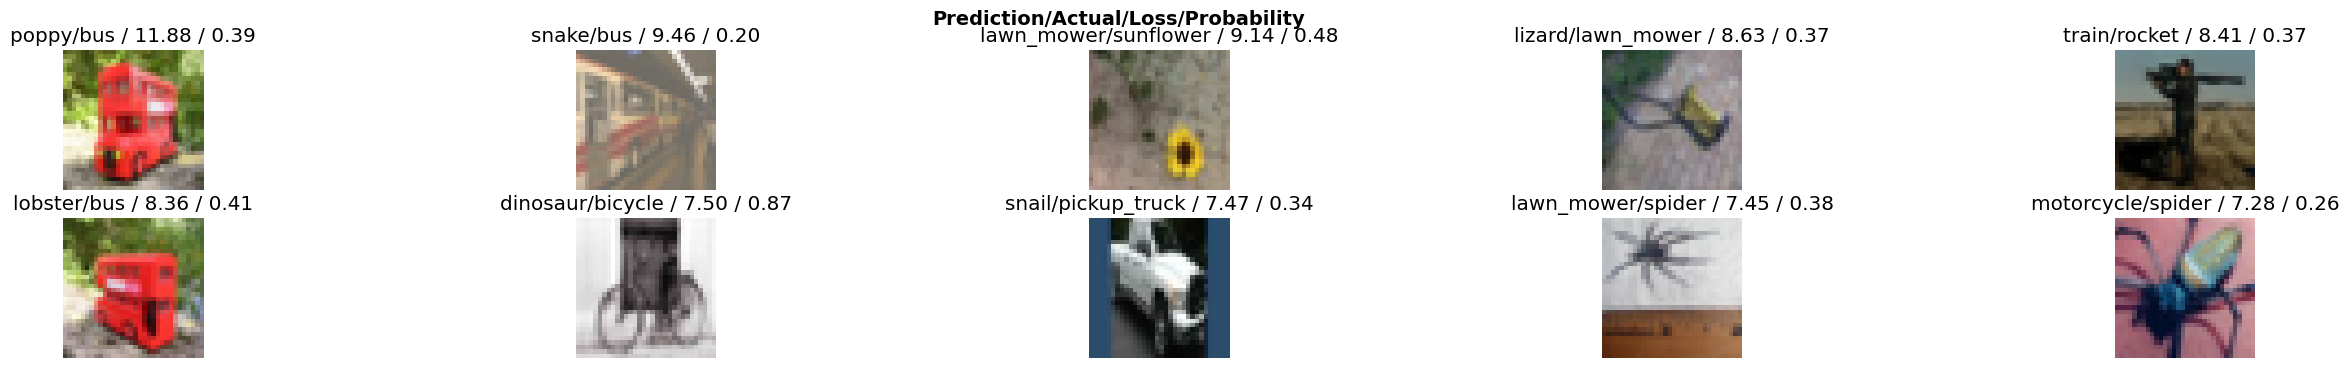

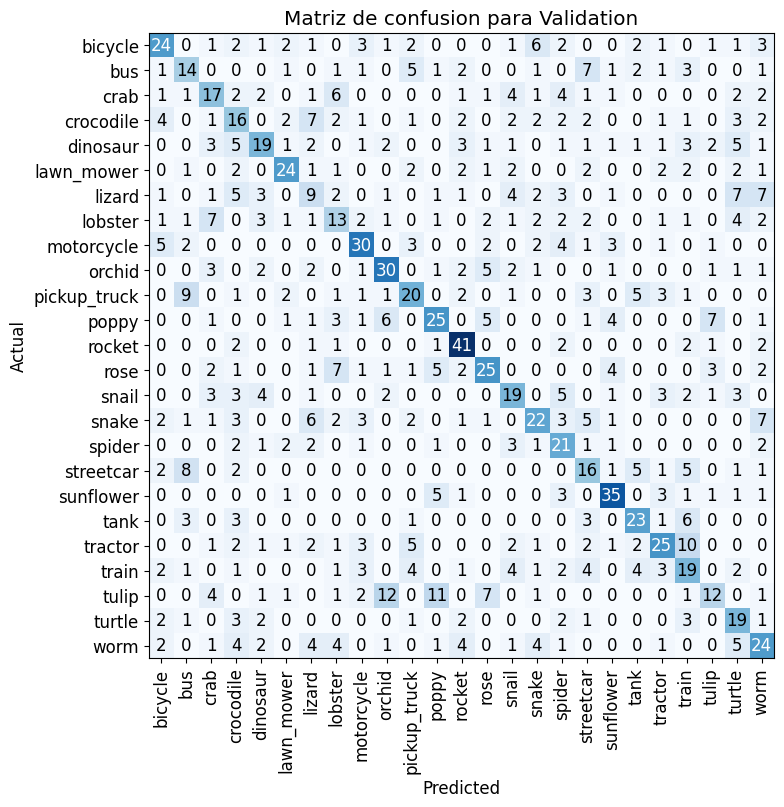

In [ ]:
interp_valid = ClassificationInterpretation.from_learner(learn, 1,dls.valid)

preds, targs, _ = learn.get_preds(dl=dls.valid, with_decoded=True)

acc = accuracy(preds, targs)
f1 = f1_score(targs.cpu(), preds.argmax(dim=1).cpu(), average='weighted')
print('The val accuracy is : ', round(float(acc)*100, 4), '%')
print('The val f1-score is:', round(float(f1)*100, 4), '%')

interp_valid.plot_top_losses(10, nrows=2, figsize=(32,4))
interp_valid.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Validation')

**¿Qué estamos observando?**

Un simple vistazo a la gráfica de entrenamiento nos da toda la información que necesitamos, pues hemos conseguido hacer un gran **overfitting** (muy poco error en entrenamiento y mucho en validación). La matriz de confusión para el conjunto de entrenamiento es casi perfecta y parece ser que el cómo escojamos el tamaño de los kernels en las capas convolucionales es totalmente determinante para el aprendizaje de la red.

<center><img src = https://ai-studio-static-online.cdn.bcebos.com/99b879c21113494a9d7315eeda74bc4c8fea07f984824a03bf8411e946c75f1b height = '200'></center>

Lo que podemos sacar en claro es que es una **clara ventaja**, pues al usar filtros pequeños, podemos aumentar la cantidad de capas (profundidad) sin aumentar demasiado la complejidad computacional. Además, Los filtros pequeños, como los de $3$x$3$, son lo suficientemente pequeños como para enfocarse en patrones locales básicos, como bordes, texturas y esquinas.

####**BaseNet3 - (BN & DP)**

Una vez que sabemos que podemos aumentar la capacidad de la red en pesos, profundidad y capacidad de entrenamiento, hasta el punto de, seguramente, hacer overfitting en nuestro entrenamiento, podemos pasar a implementar una nueva red que incluya técnicas que eviten esto, y nos hagan acercarnos a una red que minimice el "*generalization gap*".

Vamos ahora entonces a introducir las técnicas explicadas en clase de **Batch Normalization** y **Dropout**. Ambos son enfoques que permiten la regularización de la red y proponen cambios interesantes tanto en los datos como en la propia estructura de la red al entrenar.

$$$$

**Dropout**

**Dropout** es una técnica de regularización utilizada en redes neuronales para prevenir el sobreajuste durante el entrenamiento. Fue introducida por Srivastava et al. en 2014 y se ha convertido en una herramienta estándar en el diseño de redes neuronales profundas. Ver https://jmlr.org/papers/v15/srivastava14a.html

 Es una técnica en la que las neuronas seleccionadas al azar se ignoran durante el entrenamiento. **Se "descartan" aleatoriamente**. Esto significa que su contribución a la activación de las neuronas posteriores se elimina temporalmente en la pasada hacia adelante, y cualquier actualización de peso no se aplica a la neurona en la pasada hacia atrás (*backtracking*).

Algunas de las consideraciones que se dan en el *paper* son:
 1. Generalmente, usar un valor de dropout pequeño de entre 20%-50% de las neuronas, siendo 20% un buen punto de partida. Una probabilidad demasiado baja tiene un efecto mínimo, y un valor demasiado alto resulta en un aprendizaje insuficiente por parte de la red. (**En clase se discutió sobre el uso de p = 0.5 y en general, es lo que se suele usar**)

 2. Utilizar una **red más grande**. Es probable que se obtenga un mejor rendimiento cuando se usa Dropout en una red más grande, dando al modelo más oportunidades para aprender representaciones independientes.

<center><img src = 'https://www.baeldung.com/wp-content/uploads/sites/4/2020/05/2-1-2048x745-1.jpg' height = 200></center>

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Imagen extraída de https://www.baeldung.com/cs/ml-relu-dropout-layers

$$$$

**Batch normalization**

**Batch Normalization** se refiere al proceso de normalizar las salidas de las neuronas en cada mini batch de datos. Esta normalización se realiza de forma que las activaciones tengan una media de cero y una desviación estándar de uno. Ver https://arxiv.org/abs/1502.03167

Esta técnica ayuda a **estabilizar y acelerar el proceso de entrenamiento** al mantener las activaciones en un rango más controlado.

En palabras de los autores, "*Using an ensemble of batch-normalized networks, we improve upon the best published result on ImageNet classification: reaching 4.9% top-5 validation error (and 4.8% test error), exceeding the accuracy of human raters.*"

$$$$

<center><img src = 'https://gradientscience.org/images/batchnorm/bn_schematic.jpg' height = 200></center>

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Imagen extraída de https://gradientscience.org/batchnorm/


Se puede colocar antes o después de la activación. La convención común es colocarlo antes de la activación (es decir, normalizar las activaciones lineales de la capa anterior antes de aplicarle la función de activación).

Si usamos esta técnica, lo tendremos en cuenta en el análisis de los pesos pues siempre añade dos parámetros $\gamma$ y $\beta$ para cada uno de los canales que tenga la entrada.

*La implementación a nivel de código es muy sencilla pues como ya sabemos FastAI es de muy alto nivel y basta con hacer una llamada a `BatchNorm2d` y `Dropout`*

$$$$

Vamos entonces con la definición de la red:


In [ ]:
BaseNet3 = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (3,3), padding = 'same'),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2)),
    nn.Dropout(p = 0.5),

    nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 'same'),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2)),
    nn.Dropout(p = 0.5),

    nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), padding = 'same'),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2)),
    nn.Dropout(p = 0.5),

    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(p = 0.5),

    nn.Linear(in_features = 100, out_features = 25)
)

learn = Learner(dls,
                BaseNet3,
                loss_func = CrossEntropyLossFlat(),
                metrics = [accuracy, F1Score(average='weighted')],
                opt_func = optim.Adam
                )

BaseNet3

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.5, inplace=False)
  (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (9): Dropout(p=0.5, inplace=False)
  (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (14): Dropout(p=0.5, inplace=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=512, out_feat

**Análisis de red y de pesos**

Partimos de la misma red que antes, luego bastará con sumar los pesos que hayamos añadido con el uso de DP y BN. Esto es, DropOut no añade ningún peso pues simplemente anula o desactiva algunas neuronas en el proceso de entrenamiento y ya comentamos que BN añade 2 pesos por cada uno de los canales de salida de cada capa luego:

1. Pesos de la red anterior $61233$
2. Primera capa de BN: $16$ x $2 = 32$
3. Segunda capa de BN: $16$ x $2 = 32$
4. Tercera capa de BN: $32$ x $2 = 64$
5. Cuarta capa de BN: $100$ x $2 = 200$

**Pesos en total =  61233 +  32 + 32 + 64 + 200 = 61561**

Hacemos `summary()` para comprobar estos cálculos:

In [ ]:
learn.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 16 x 32 x 32   
Conv2d                                    448        True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 16 x 16 x 16   
MaxPool2d                                                      
Dropout                                                        
Conv2d                                    2320       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 16 x 8 x 8     
MaxPool2d                                                      
Dropout                              

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Aproximación learning rate: 0.005248074419796467


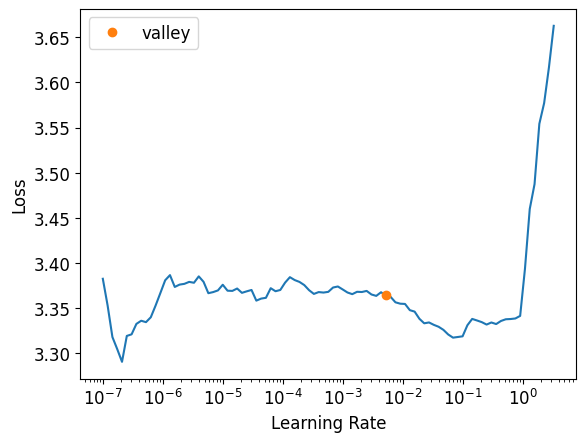

In [ ]:
lr = learn.lr_find()
print("Aproximación learning rate:", lr.valley)

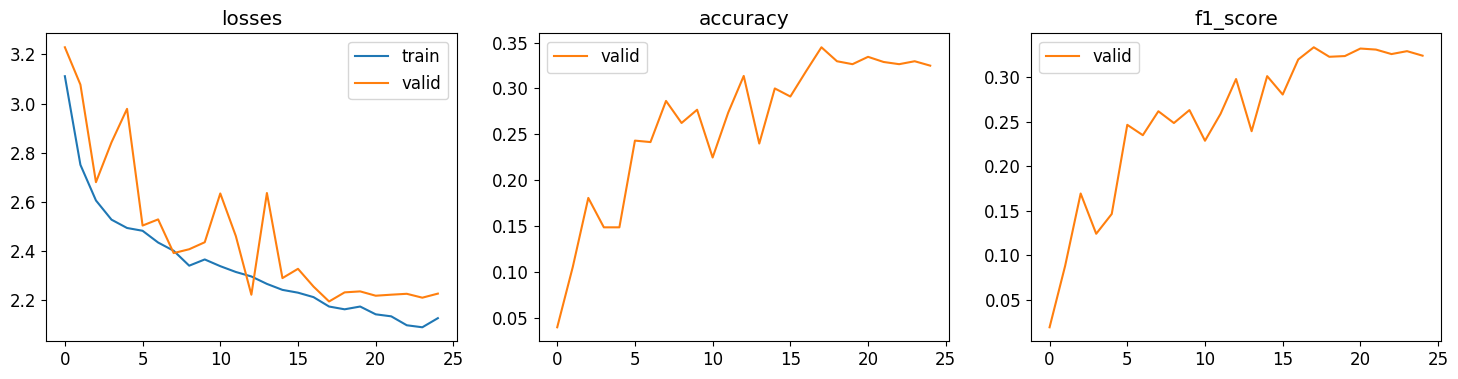

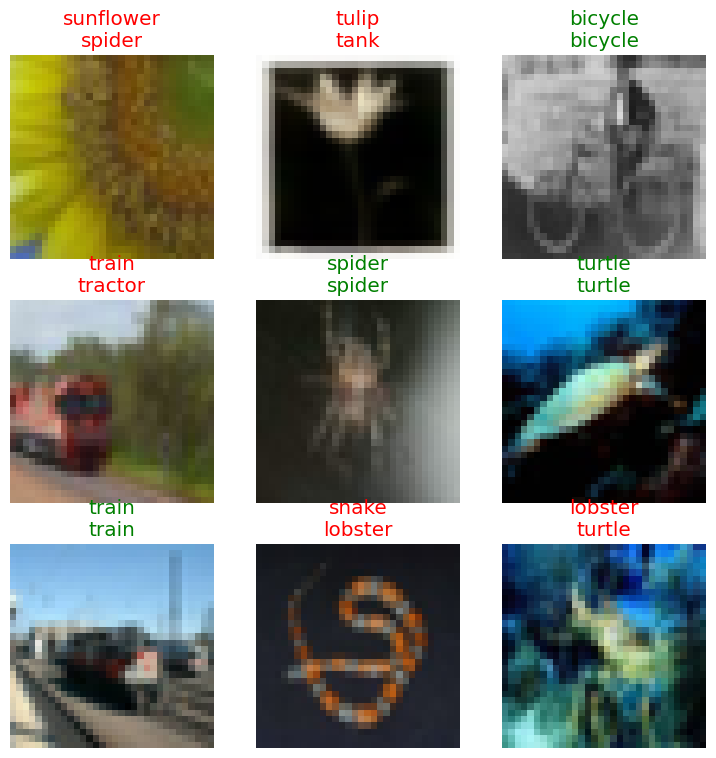

In [ ]:
learn.fit_one_cycle(n_epoch = 25, lr_max = lr.valley)
learn.recorder.plot_metrics()
learn.show_results()

The train accuracy is :  35.7422 %
The train f1-score is: 36.0255 %


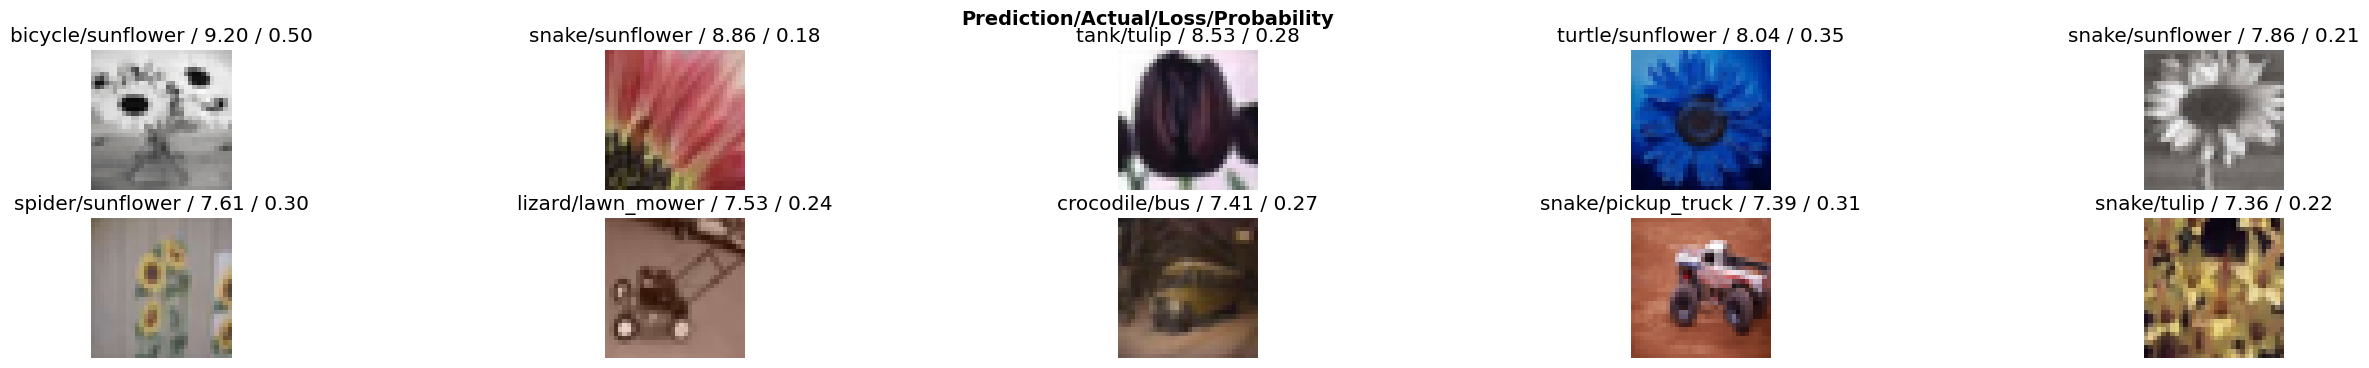

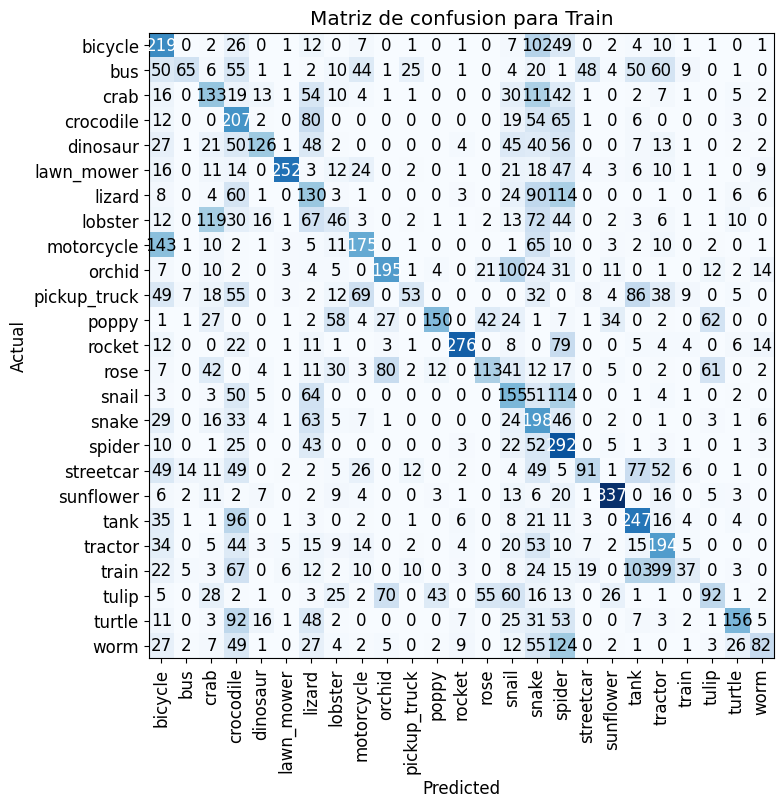

In [ ]:
from sklearn.metrics import f1_score

interp_train = ClassificationInterpretation.from_learner(learn, 1,dls.train)
interp_train.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=dls.train, with_decoded=True)

acc = accuracy(preds, targs)
f1 = f1_score(targs.cpu(), preds.argmax(dim=1).cpu(), average='weighted')
print('The train accuracy is : ', round(float(acc)*100, 4), '%')
print('The train f1-score is:', round(float(f1)*100, 4), '%')

interp_train.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Train')

The val accuracy is :  32.48 %
The val f1-score is: 32.4061 %


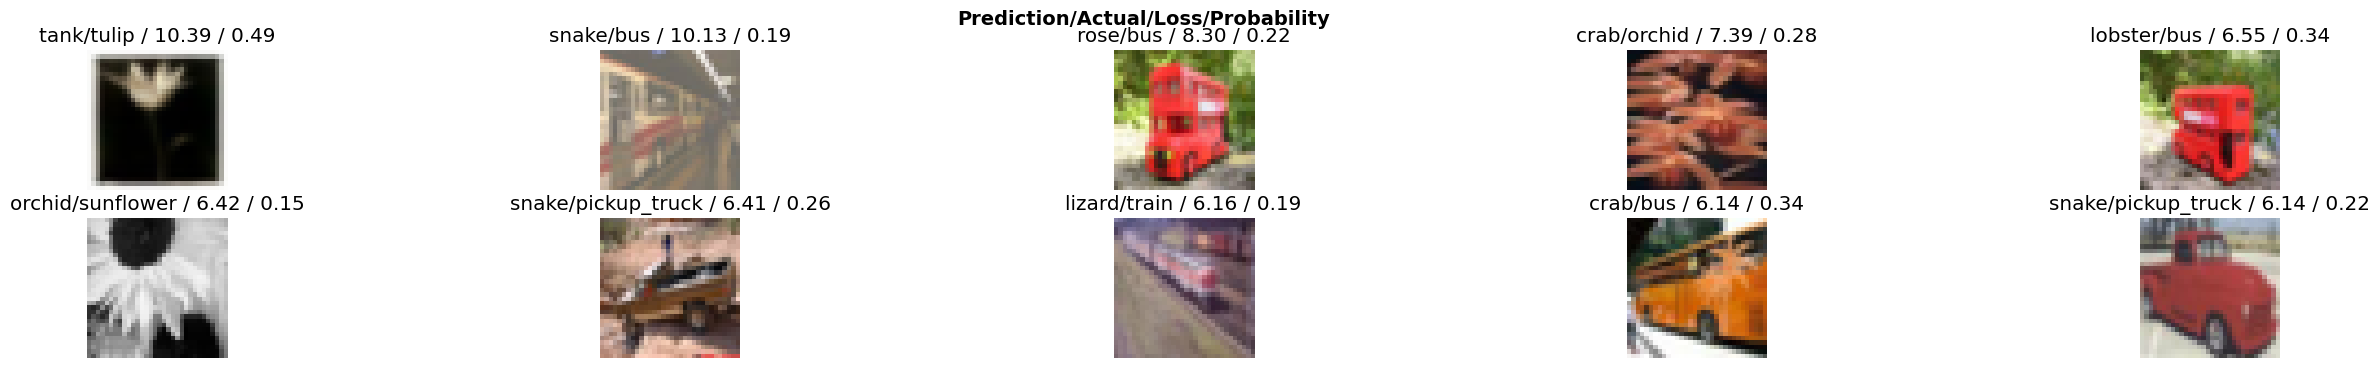

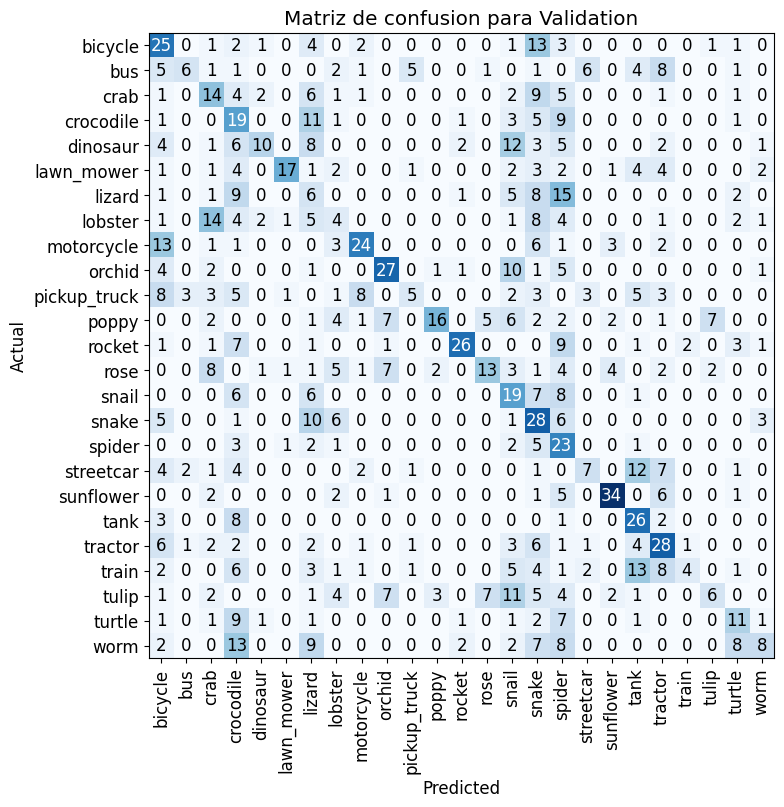

In [ ]:
interp_valid = ClassificationInterpretation.from_learner(learn, 1,dls.valid)

preds, targs, _ = learn.get_preds(dl=dls.valid, with_decoded=True)

acc = accuracy(preds, targs)
f1 = f1_score(targs.cpu(), preds.argmax(dim=1).cpu(), average='weighted')
print('The val accuracy is : ', round(float(acc)*100, 4), '%')
print('The val f1-score is:', round(float(f1)*100, 4), '%')

interp_valid.plot_top_losses(10, nrows=2, figsize=(32,4))
interp_valid.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Validation')

**Conclusiones del entrenamiento y posibles mejoras**

De estos resultados hemos aprendido:

* **1.** Hemos sido capaces de lidiar con el overfitting de las redes anteriores.

* **2.** Al aplicar estas técnicas estamos sacrificando buenos resultados en el conjunto de train por mejores resultados en el conjunto de validación.

* **3.** La diferencia es demasiado grande respecto al entrenamiento para la red anterior, lo que nos puede dar pistas de que igual el efecto regularizador ha sido demasiado. Podemos modificar los parámetros de BN y Dropout para intentar evitar este tipo de escenarios.

* **4.** Si nos fijamos en la gráfica de entrenamiento, vemos demasiados **picos**. Esto puede ser indicativo de un *learning rate* demasiado alto. Sabemos del ejercicio 1 que `lr_find()` nos da una estimación, puede ser que el escogido para este entrenamiento no sea el mejor posible.

* **5.** La pérdida de validación más baja que la de entrenamiento podría indicar que el Dropout está desactivando muchas neuronas durante el entrenamiento, de manera que cuando llega al conjunto de validación se adapta mucho mejor a los datos. **Modificaremos entonces la probabilidad con que hacemos DropOut.**

####**BaseNet4 - (Eliminar Pooling)**

Investigando sobre el *Pooling*, encuentro el siguiente vídeo en el que Geoffrey Hinton afirma que "no cree en el pooling", https://www.youtube.com/watch?v=rTawFwUvnLE&t=612s&ab_channel=trwappers.

Da varias razones para ello pero entre ellas están las siguientes:

 * En lugar de preservar relaciones intrínsecas, el pooling descarta información importante (como las coordenadas espaciales) sin justificar cómo asignamos marcos de referencia a los objetos.

 * El pooling busca invarianza (por ejemplo, invarianza a traslaciones) al reducir características a valores "resumidos" (como el máximo o promedio (avg)). Sin embargo, Hinton argumenta que lo que realmente necesitamos no es invarianza, sino **equivarianza**.

 > Él propone una red diferente (CapsuleNet) donde grupos de neuronas capturan información adicional. No vamos a entrar ahí, no está implementado ni en FastAI ni PyTorch.

$$$$

Por tanto, una posible modificación interesante a hacer a nuestra red es la de **eliminar el pooling** y entrenar una red con 3 capas convolucionales. Para ello definimos la siguiente red:

In [ ]:
BaseNet4 = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (3,3), padding = 'same'),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Dropout(p = 0.5),

    nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 'same'),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Dropout(p = 0.5),

    nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), padding = 'same'),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(p = 0.5),

    nn.Flatten(),
    nn.Linear(in_features = 32*32*32, out_features = 50),
    nn.BatchNorm1d(50),
    nn.ReLU(),
    nn.Dropout(p = 0.5),

    nn.Linear(in_features = 50, out_features = 25)
)

learn = Learner(dls,
                BaseNet4,
                loss_func = CrossEntropyLossFlat(),
                metrics = [accuracy, F1Score(average='weighted')],
                opt_func = optim.Adam
                )

BaseNet4

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=32768, out_features=50, bias=True)
  (14): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=50, out_features=25, bias=True)
)

**Análisis de red y de pesos**

Partimos de la misma red que antes, solo que ahora eliminamos todo el proceso de subsampling que hacíamos mediante las capas de *MaxPooling*. Por tanto, el número de pesos que llegará a la primera capa Fully Connected ahora será mucho más grande, pues no estamos reduciendo dimensionalidad en ningún momento.

1. Capa convolucional 1: $3$ x $3$ x $3 + 1$ $\implies 28$ x $16 = 448$  

  Primera capa de BN: $16$ x $2 = 32$
2. Capa convolucional 2: $3$ x $3$ x $16 + 1 \implies 145$ x $16 = 2320$
  
  Segunda capa de BN: $16$ x $2 = 32$
3. Capa convolucional 3: $3$ x $3$ x $16 + 1 \implies 145$ x $32 = 4640$

  Tercera capa de BN: $32$ x $2 = 64$
4. Capa FC 1: $32$ x $32$ x $32 + 1 = 32768 \implies 32768$ x $50 = 1.638.450$

  Cuarta capa de BN: $50$ x $2 = 100$
5. Capa FC 2: $50 + 1$ x $25 = 1275$

**Pesos en total =  448 +  32 + 2320 + 32 + 4640 + 64 + 1638450 + 100 + 1275 = 1.647.361**


Hacemos `summary()` para comprobar estos cálculos:

In [ ]:
learn.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 16 x 32 x 32   
Conv2d                                    448        True      
BatchNorm2d                               32         True      
ReLU                                                           
Dropout                                                        
Conv2d                                    2320       True      
BatchNorm2d                               32         True      
ReLU                                                           
Dropout                                                        
____________________________________________________________________________
                     32 x 32 x 32 x 32   
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
ReLU                                                           
Dropout                     

Y ahora pasamos al entrenamiento, como hemos hecho para las versiones anteriores:

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Aproximación learning rate: 0.002511886414140463


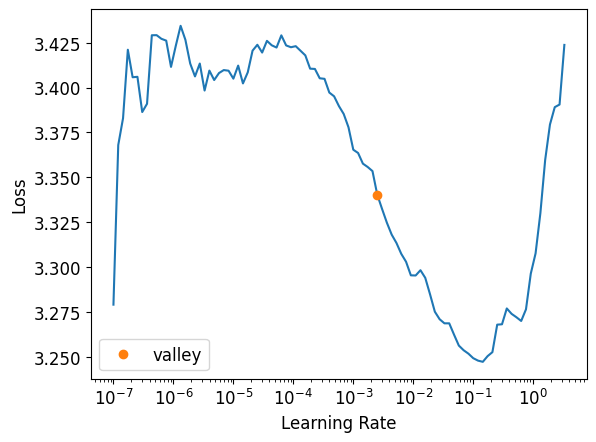

In [ ]:
lr = learn.lr_find()
print("Aproximación learning rate:", lr.valley)

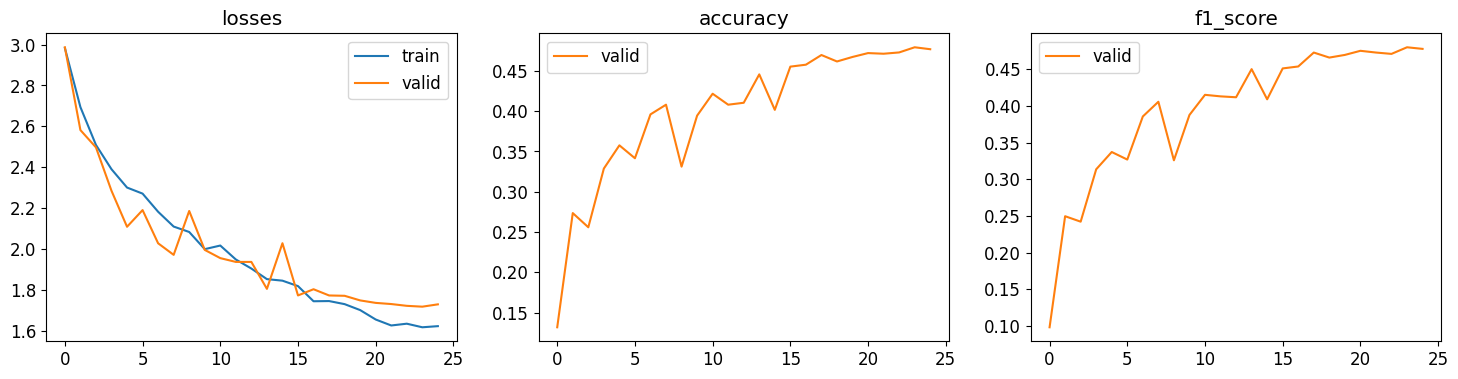

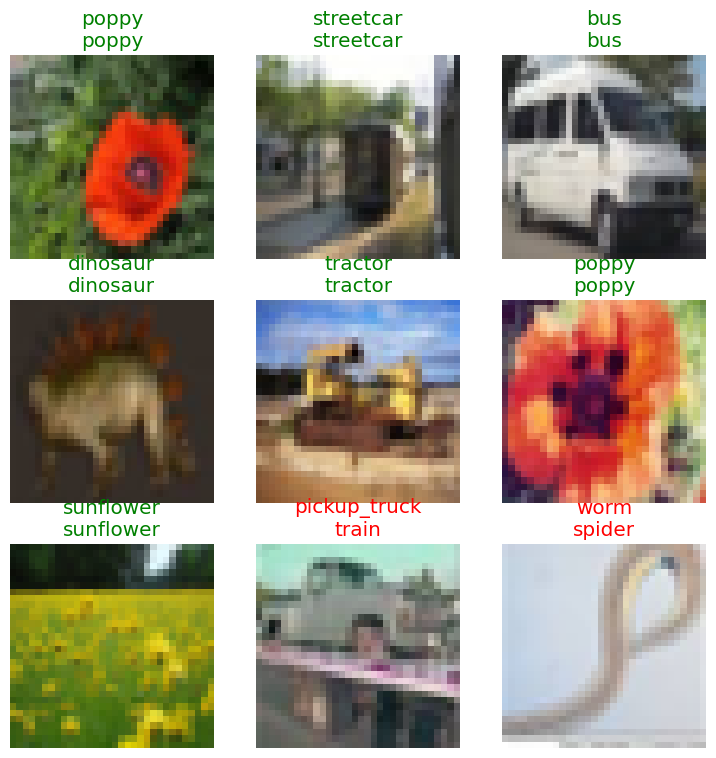

In [ ]:
learn.fit_one_cycle(n_epoch = 25, lr_max = lr.valley)
learn.recorder.plot_metrics()
learn.show_results()

The train accuracy is :  68.3911 %
The train f1-score is: 68.2064 %


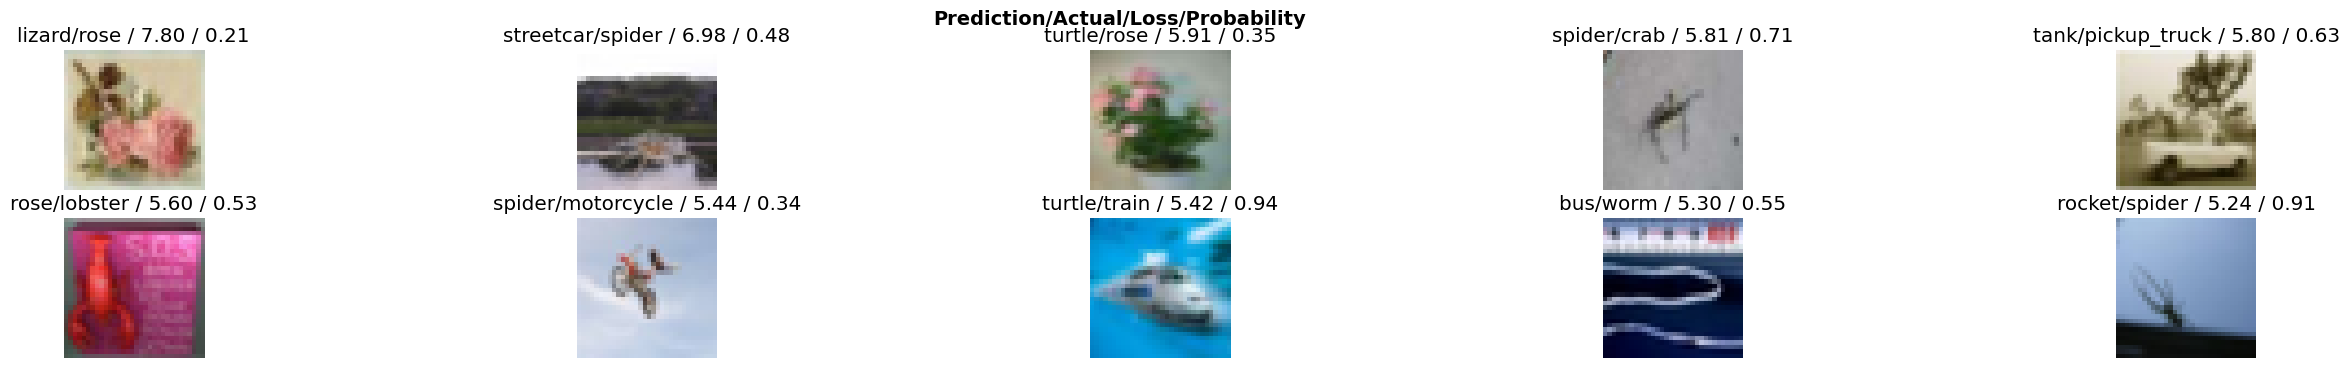

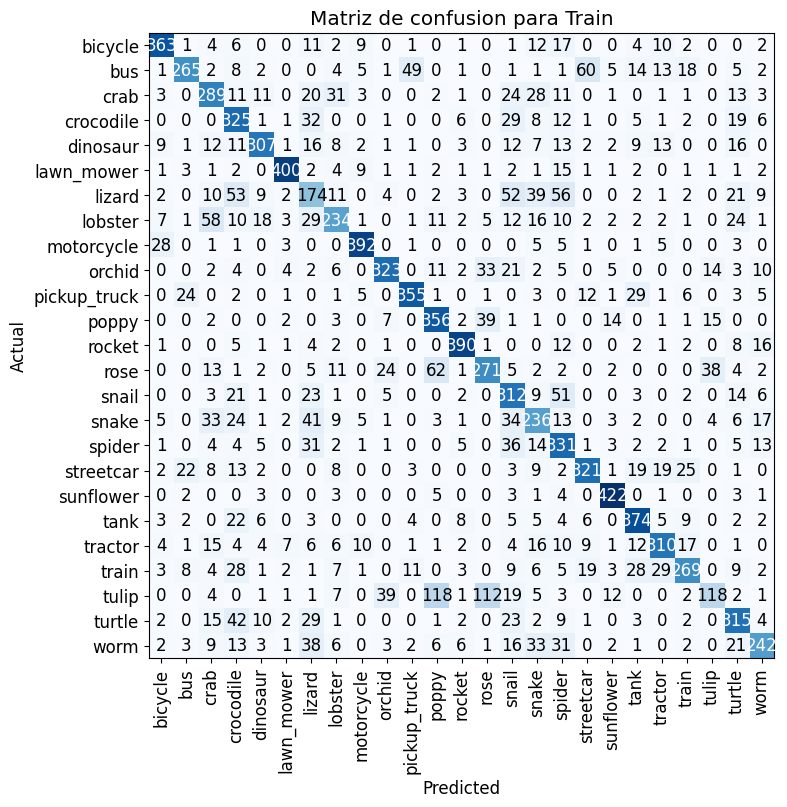

In [ ]:
from sklearn.metrics import f1_score

interp_train = ClassificationInterpretation.from_learner(learn, 1,dls.train)
interp_train.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=dls.train, with_decoded=True)

acc = accuracy(preds, targs)
f1 = f1_score(targs.cpu(), preds.argmax(dim=1).cpu(), average='weighted')
print('The train accuracy is : ', round(float(acc)*100, 4), '%')
print('The train f1-score is:', round(float(f1)*100, 4), '%')

interp_train.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Train')

The val accuracy is :  47.68 %
The val f1-score is: 47.7724 %


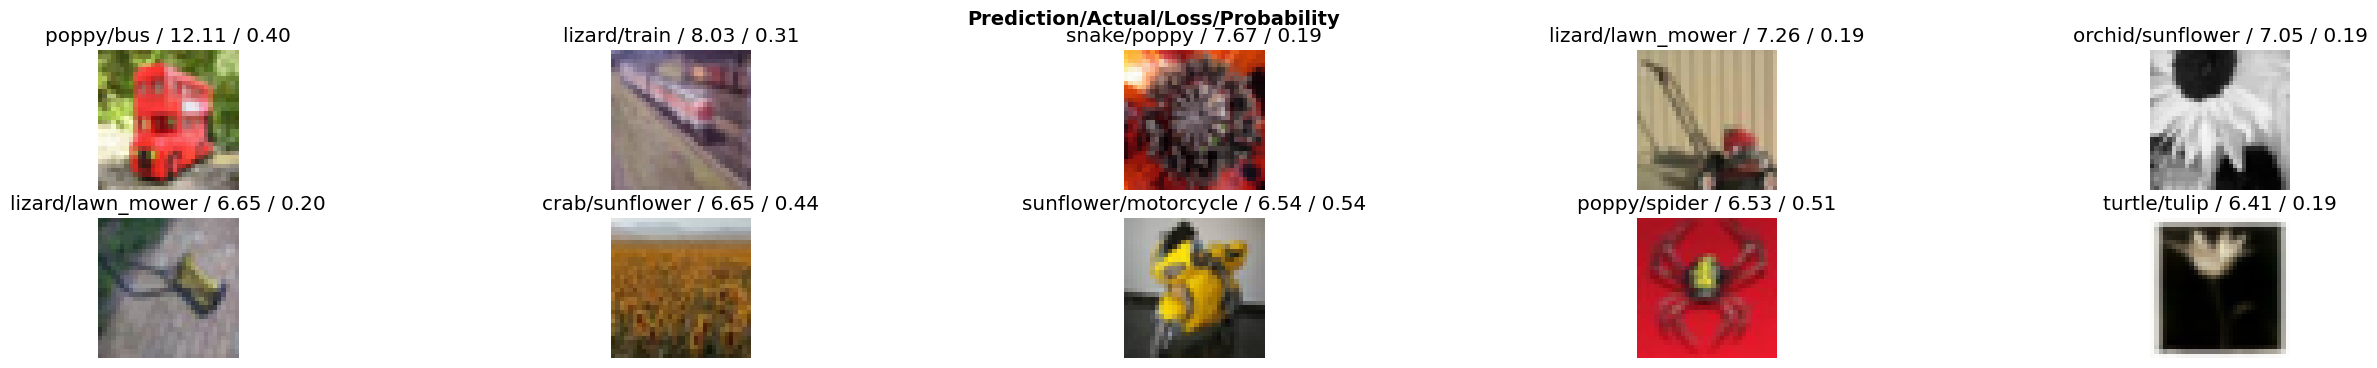

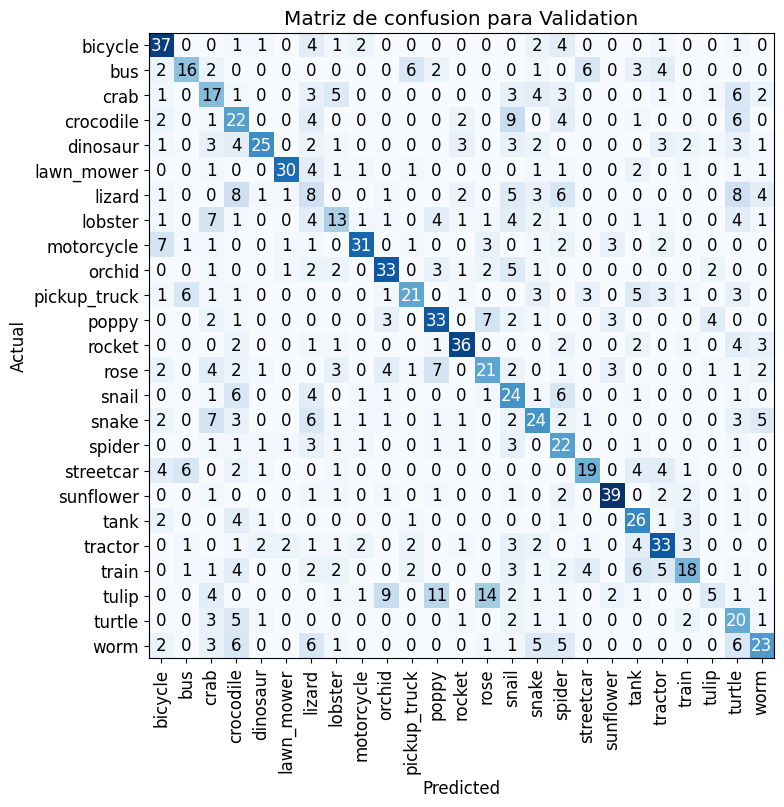

In [ ]:
interp_valid = ClassificationInterpretation.from_learner(learn, 1,dls.valid)

preds, targs, _ = learn.get_preds(dl=dls.valid, with_decoded=True)

acc = accuracy(preds, targs)
f1 = f1_score(targs.cpu(), preds.argmax(dim=1).cpu(), average='weighted')
print('The val accuracy is : ', round(float(acc)*100, 4), '%')
print('The val f1-score is:', round(float(f1)*100, 4), '%')

interp_valid.plot_top_losses(10, nrows=2, figsize=(32,4))
interp_valid.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Validation')

**Observaciones de los resultados**

Es cierto que obtenemos buenos resultados, pues parece que tenemos mucho más accuracy y f1-score. Siendo objetivos, **la comparación con los modelos anteriores no es del todo justa**, pues al eliminar el `MaxPooling`, la cantidad de pesos entrenables se ha visto incrementada, pues a la hora de conectar con las capas fully connected, tenemos muchos más pesos (siempre tenemos muchos más pesos en las capas FC, por tanto si las dimensiones al terminar el bloque convolucional no han cambiado, el número de pesos se ve incrementado).

De igual manera, considero que al tener muchos más pesos, es normal que veamos mayor *overfitting* que para BaseNet3.

$$$$

Es un entrenamiento bastante parecido al anterior, y conseguimos un $65\%$ de accuracy en el conjunto de entrenamiento, mientras que para el de validación un $45\%$. Cuando modelemos nuestra red final trataremos de hacer que el **entrenamiento sea mucho más suave**, y que la **diferencia entre train y validación sea mucho menor**.

<img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Aunque los argumentos dados por Hinton parecen razonables, muchas otras voces dentro del mundo del Deep Learning no están de acuerdo, y defienden las ventajas del pooling. Por tanto, para nuestra red final, trateremos de tener un equilibrio: haremos pooling solo cada cierto número de convolucionales para no perder mucha información y gozar de las ventajas de esta técnica.

####**BaseNet5 - (Data Augmentation)**

En este apartado vamos a usar la misma red usada anteriormente pero vamos a tratar de aumentar su rendimiento mediante el uso de **Data Augmentation**.

Este proceso consiste en crear muestras sintéticas a partir de las muestras con las que ya contamos. Mediante esta técnica conseguimos **enriquecer** nuestros datos de entrenamiento de manera que esto puede llevar a una mayor generalización de la red. Por ejemplo, véase la imagen:

<center><img src = https://th.bing.com/th/id/OIP.ae1tW5ngf1zhPRyh7aaM1QAAAA?rs=1&pid=ImgDetMain height = 250></center>

donde la muestra original es la mariposa de la izquierda y mediante todas las técnicas que aparecen a la izquierda podemos conseguir nuevos ejemplos que son representativos, pues siguen siendo mariposas, y añaden diversidad y riqueza al conjunto en general. Que la red sepa distinguir una mariposa independientemente de su color, su posición o su forma, es importante.

$$$$

Para hacer data augmentation con FastAI, haremos uso de `aug_transforms`, que incluye todo tipo de funcionalidades y posibles cambios a los datos de entrada, en concreto para imágenes. Podríamos añadir el parámetro mult, que recibe un flotante que multiplicaría todas los escalados y otras operaciones para hacerlos más o menos efectivos. Pero si nos pasamos de largo con este parámetro puede ocurrir que nuestro conjunto de validación sea más sencillo que el de entrenamiento y esto podría dificultar el aprendizaje. Por ello, usaremos los parámetros por defecto para ver cómo se entrena la red.

[https://fastai.github.io/fastai-docs/vision.augment#aug_transforms]

> En una primera instancia, pensaba que FastAI operaba con data augmentation de manera que se **añadían** nuevas instancias al dataset original, aplicándoles ciertas transformaciones, pero me di cuenta de que el tamaño del conjunto de datos no cambiaba. Realmente solo devuelve las transformadas pues si añadiera también las originales resultaría en que el modelo vería varias veces las mismas imágenes y provocaría *overfitting*.

$$$$

Probaremos esta técnica con `BaseNet3`, para comprobar que en efecto supone una mejora respecto del modelo.

In [ ]:
augmentedTrainData = dblock.dataloaders(path/'train', bs = 32, batch_tfms=[Normalize.from_stats(*cifar_stats),*aug_transforms()])

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Por lo visto en `BaseNet3` y `BaseNet4`, rebajaremos la probabilidad de DropOut (probabilidad con que se apaga o desactiva una neurona) a 0.4 para este experimento.

In [ ]:
BaseNet5 = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (3,3), padding = 'same'),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2)),
    nn.Dropout(p = 0.4),

    nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 'same'),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2)),
    nn.Dropout(p = 0.4),

    nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), padding = 'same'),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2)),
    nn.Dropout(p = 0.4),

    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(p = 0.4),

    nn.Linear(in_features = 100, out_features = 25)
)

learn = Learner(augmentedTrainData,
                BaseNet5,
                loss_func = CrossEntropyLossFlat(),
                metrics = [accuracy, F1Score(average='weighted')],
                opt_func = optim.Adam
                )

BaseNet5

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.4, inplace=False)
  (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (9): Dropout(p=0.4, inplace=False)
  (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (14): Dropout(p=0.4, inplace=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=512, out_feat

> <img src = https://static.vecteezy.com/system/resources/previews/017/178/327/original/warning-hazard-sign-on-transparent-background-free-png.png height = '20' width = '20'> Es muy importante **redefinir** las redes pues si tomamos la misma red corremos el riesgo de partir de pesos ya optimizados y el entrenamiento entonces no sería fiel a la realidad. Queremos entrenar de cero.

$$$$

**Análisis de pesos**

Es exactamente el mismo que para BaseNet3, pues tan solo la estamos redefiniendo.

In [ ]:
learn.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 16 x 32 x 32   
Conv2d                                    448        True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 16 x 16 x 16   
MaxPool2d                                                      
Dropout                                                        
Conv2d                                    2320       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 16 x 8 x 8     
MaxPool2d                                                      
Dropout                              

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Aproximación learning rate: 0.0063095735386013985


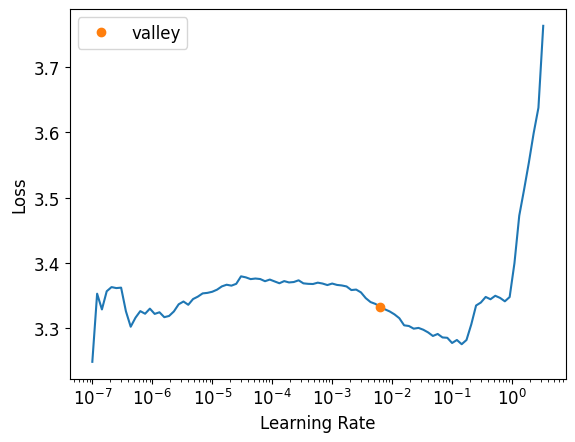

In [ ]:
lr = learn.lr_find()
print("Aproximación learning rate:", lr.valley)

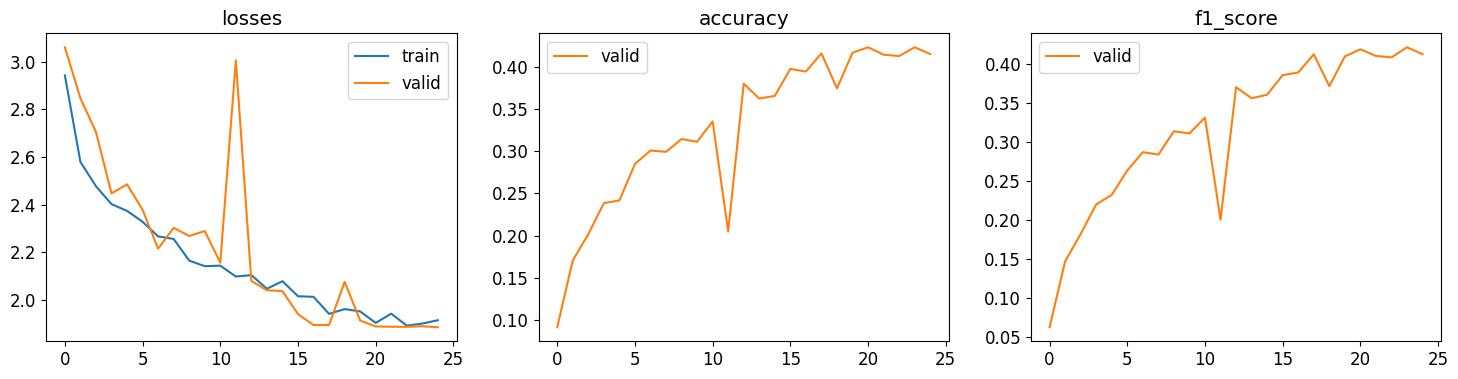

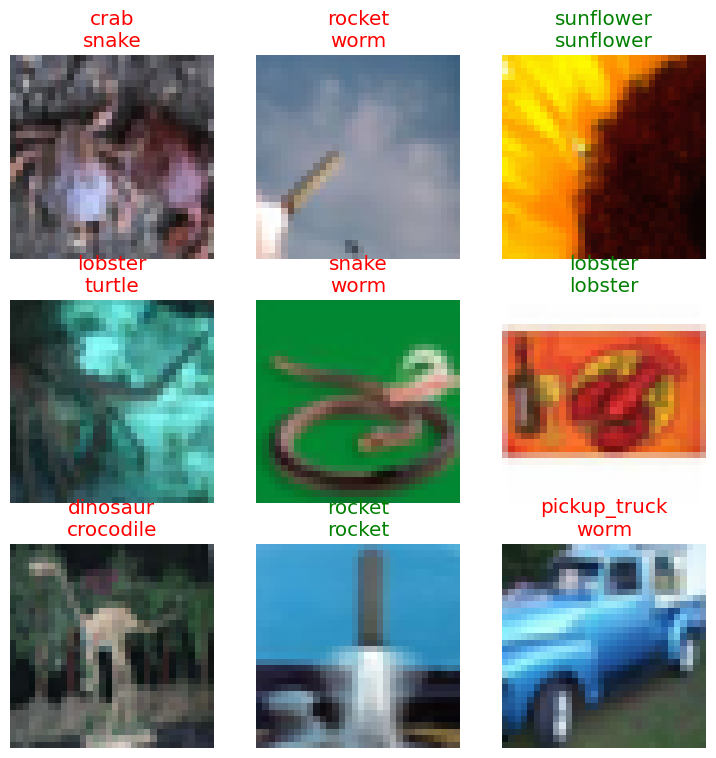

In [ ]:
learn.fit_one_cycle(n_epoch = 25, lr_max = lr.valley)
learn.recorder.plot_metrics()
learn.show_results()

The train accuracy is :  48.8267 %
The train f1-score is: 49.1878 %


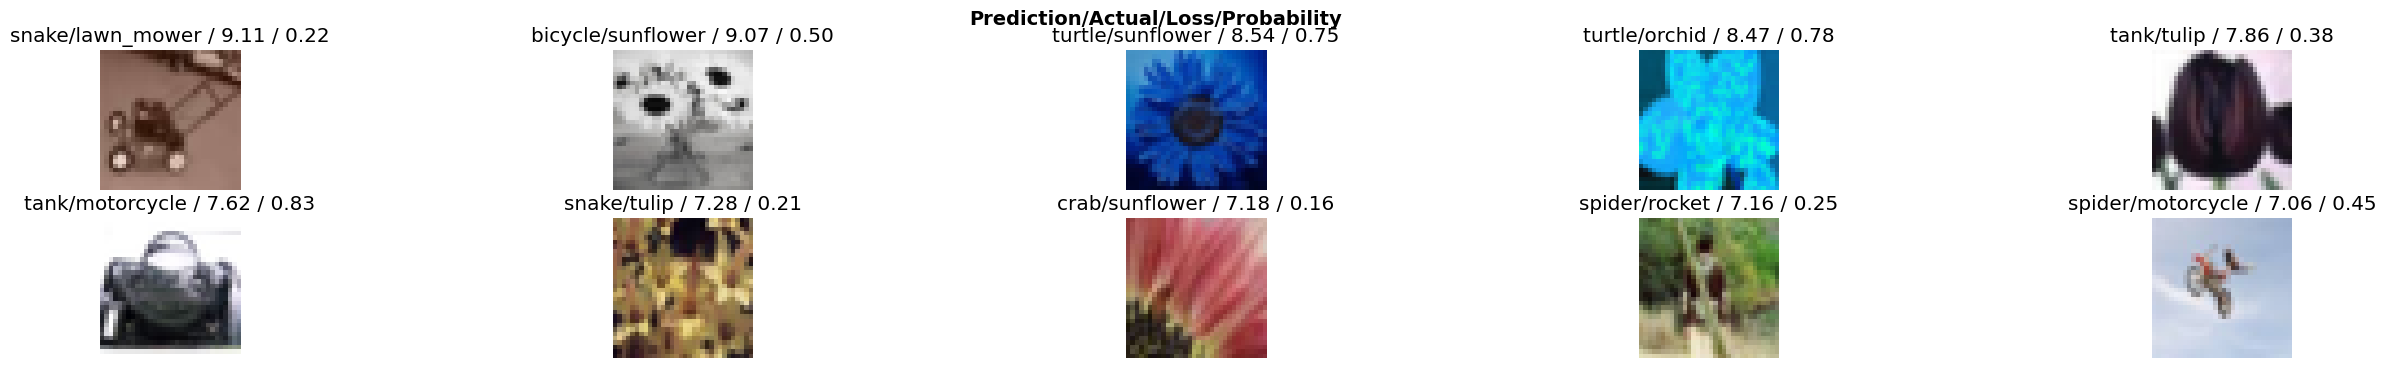

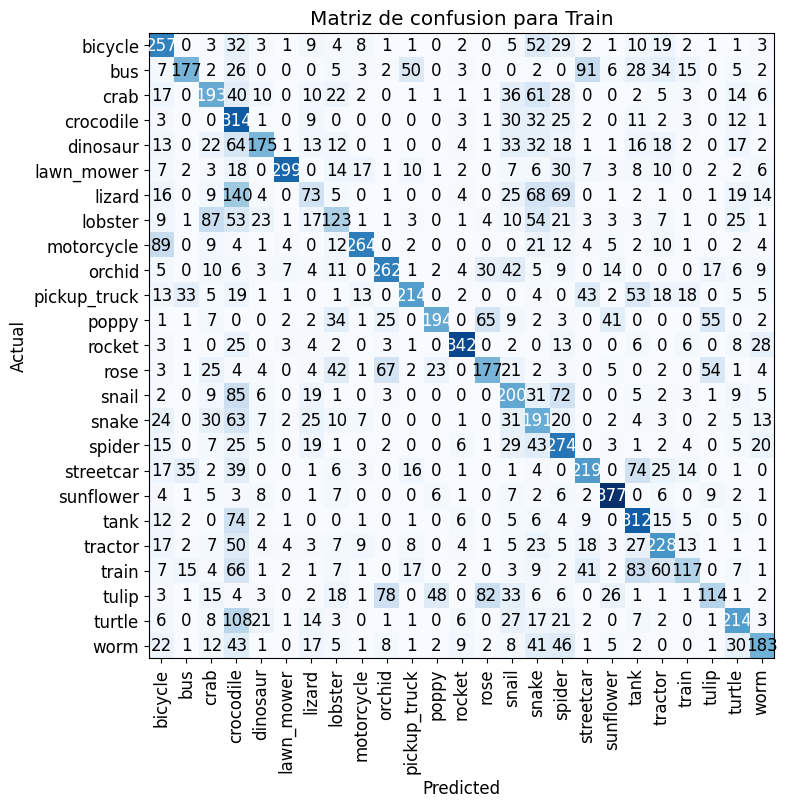

In [ ]:
from sklearn.metrics import f1_score

interp_train = ClassificationInterpretation.from_learner(learn, 1,augmentedTrainData.train)
interp_train.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=augmentedTrainData.train, with_decoded=True)

acc = accuracy(preds, targs)
f1 = f1_score(targs.cpu(), preds.argmax(dim=1).cpu(), average='weighted')
print('The train accuracy is : ', round(float(acc)*100, 4), '%')
print('The train f1-score is:', round(float(f1)*100, 4), '%')

interp_train.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Train')

The val accuracy is :  41.52 %
The val f1-score is: 41.3023 %


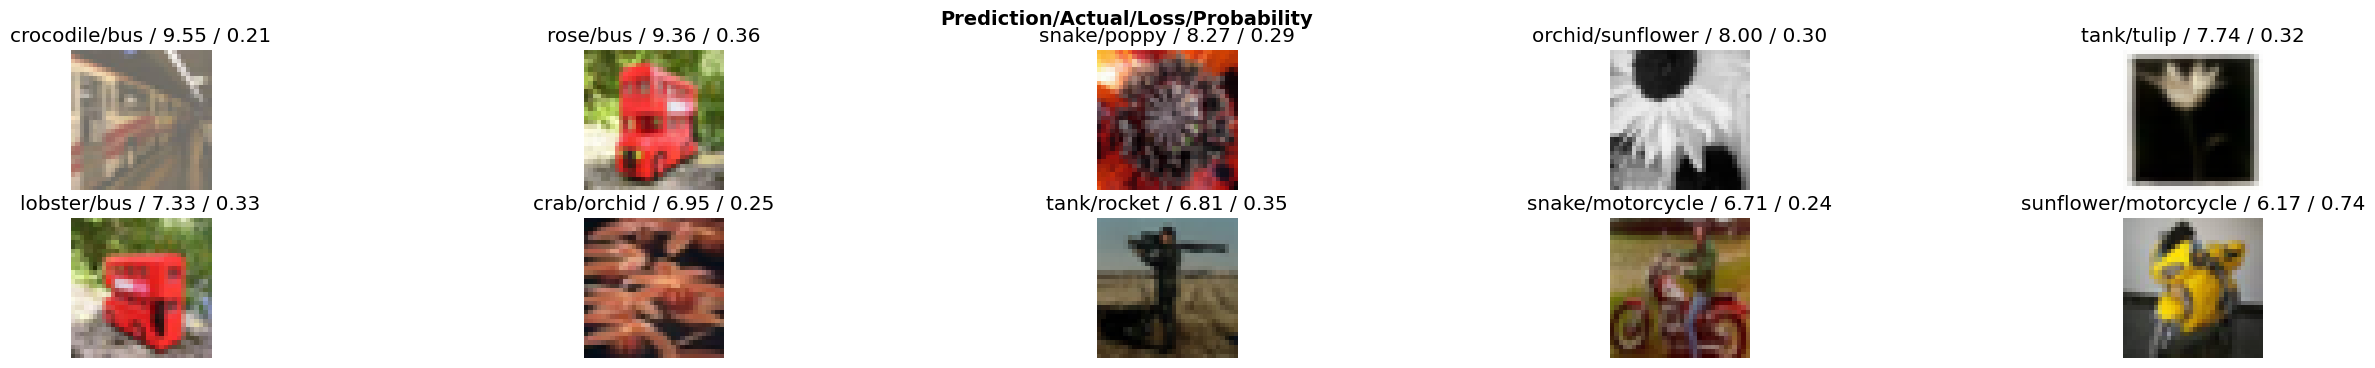

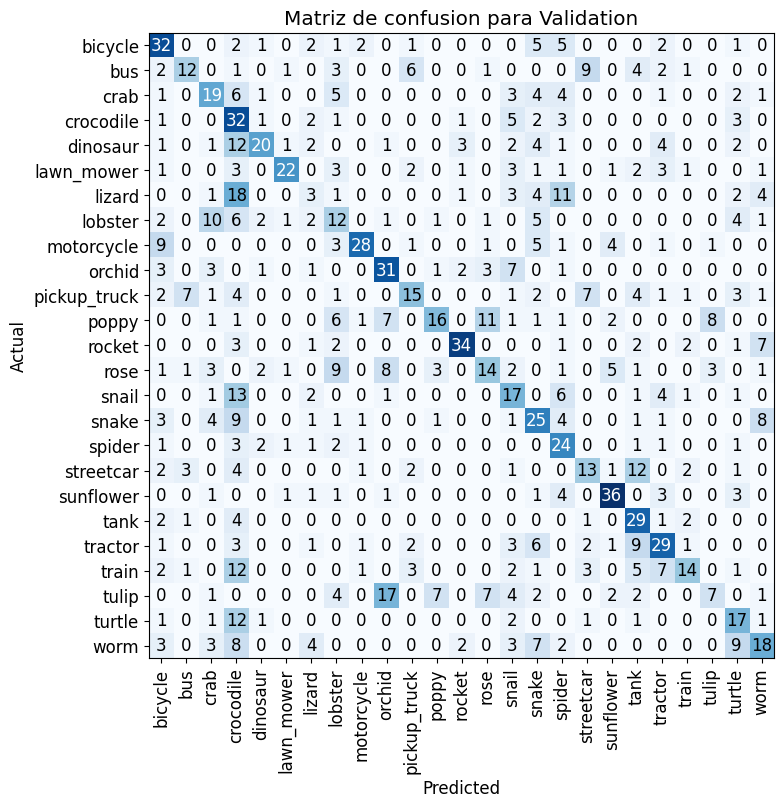

In [ ]:
interp_valid = ClassificationInterpretation.from_learner(learn, 1,augmentedTrainData.valid)

preds, targs, _ = learn.get_preds(dl=augmentedTrainData.valid, with_decoded=True)

acc = accuracy(preds, targs)
f1 = f1_score(targs.cpu(), preds.argmax(dim=1).cpu(), average='weighted')
print('The val accuracy is : ', round(float(acc)*100, 4), '%')
print('The val f1-score is:', round(float(f1)*100, 4), '%')

interp_valid.plot_top_losses(10, nrows=2, figsize=(32,4))
interp_valid.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Validation')

**Resultados y conclusiones**

Respecto a `BaseNet3`, vemos cierta mejora. Ahora parece que el problema del sobre ajuste desaparece. Las gráficas de entrenamiento nos muestran esto pero también podemos observar **picos** todavía, como comentábamos para `BaseNet3`.
Obtenemos un $44\%$ de accuracy

La **riqueza en la variedad de los datos, junto a buenas técnicas de regularización** parecen dar sus frutos.
Si tenemos un conjunto de imágenes limitado y aplicamos augmentations como rotaciones, flips horizontales, escalado y cambio de brillo, el modelo aprende que un objeto sigue siendo el mismo independientemente de su orientación o iluminación y además se vuelve más resistente a variaciones que puedan estar presentes en los datos.

$$$$

Estamos en las condiciones perfectas ya para poder ir aumentando la capacidad de nuestra red, para conseguir los resultados que queremos.

#### **BaseNet 6 - (AdaptativeAvgPool)**

La idea que proponemos ahora realmente está basada en ["Deep Residual Learning for Image Recognition" (He et al., 2015)](https://arxiv.org/pdf/1512.03385), o la conocida **ResNet**. Para la implementación de la siguiente red se ha revisado la estructura de la red en cuestión y, aunque a escala mucho menor (ResNet cuenta con muchas capas, así como pesos), trataremos de replicar la arquitectura de la red para tratar de mejorar BaseNet5.

La propuesta que se hace ahora surge de plantearse si el usar siempre MaxPooling es un buen acercamiento, pues existen otros tipos de capas de Pooling. Por ejemplo, **AvgPooling()**, en lugar de tomar el máximo, realiza la media de los píxeles del filtro. **¿Qué diferencias puede haber entre usar uno u otro?**

Pues bien, la conocida ResNet, en sus bloques convolucionales, añade muchas más capas que nosotros, pero solo hace un MaxPooling en la primera de las capas. Lo que hace en lugar de usar pooling es disminuir la dimensionalidad usando `stride = 2`. La red termina con una capa de **AveragePooling**. De esta manera, la parte de la red de clasificación se hará con las características clave obtenidas de las convoluciones.

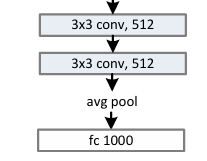

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Imagen extraída del paper original.


Probemos a hacer nuestra propia versión de lo discutido:

In [ ]:
BaseNet6 = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (3,3), stride = 2, padding = 'valid'),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Dropout(p = 0.4),

    nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), stride = 2, padding = 'valid'),
    nn.BatchNorm2d(16),
    nn.ReLU(),

    nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), stride = 2, padding = 'valid'),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((4,4)),

    nn.Flatten(),
    nn.Linear(in_features = 512, out_features = 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(p = 0.5),

    nn.Linear(in_features = 100, out_features = 25)
)

learn = Learner(augmentedTrainData,
                BaseNet6,
                loss_func = CrossEntropyLossFlat(),
                metrics = [accuracy, F1Score(average='weighted')],
                opt_func = optim.Adam
                )

BaseNet6

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.4, inplace=False)
  (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): AdaptiveAvgPool2d(output_size=(4, 4))
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=512, out_features=100, bias=True)
  (13): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Dropout(p=0.5, inplace=False)
  (16): Linear(in_features=100, out_features=25, bias=True)
)

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Haremos uso del método `AdaptativeAvgPool2d` que proporciona FastAI, al que solo le tenemos que pasar como argumento las dimensiones que queremos que tenga el output, en nuestro caso (4,4). El tamaño del kernel y el resto de parámetros los calcula automáticamente, y, más tarde, realiza **AveragePooling**.


**Análisis de red y de pesos**

Realmente, como no estamos añadiendo ninguna capa, sino que estamos modificando la estructura que teníamos en **BaseNet3, los pesos serán exactamente los mismos**. De esta manera, la comparación será lo más precisa posible. Además, aunque el subsampling lo estemos haciendo de otra manera, el output de cada una de las capas seguirá siendo el mismo en dimensiones, por lo que nada cambia.


Hacemos `summary()` para comprobar que el número de pesos coincide cálculos:

In [ ]:
learn.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 16 x 15 x 15   
Conv2d                                    448        True      
BatchNorm2d                               32         True      
ReLU                                                           
Dropout                                                        
____________________________________________________________________________
                     32 x 16 x 7 x 7     
Conv2d                                    2320       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     32 x 32 x 3 x 3     
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
ReLU                                 

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Aproximación learning rate: 0.001737800776027143


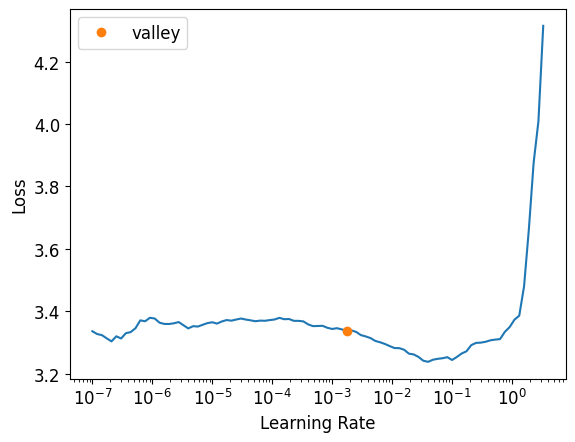

In [ ]:
lr = learn.lr_find()
print("Aproximación learning rate:", lr.valley)

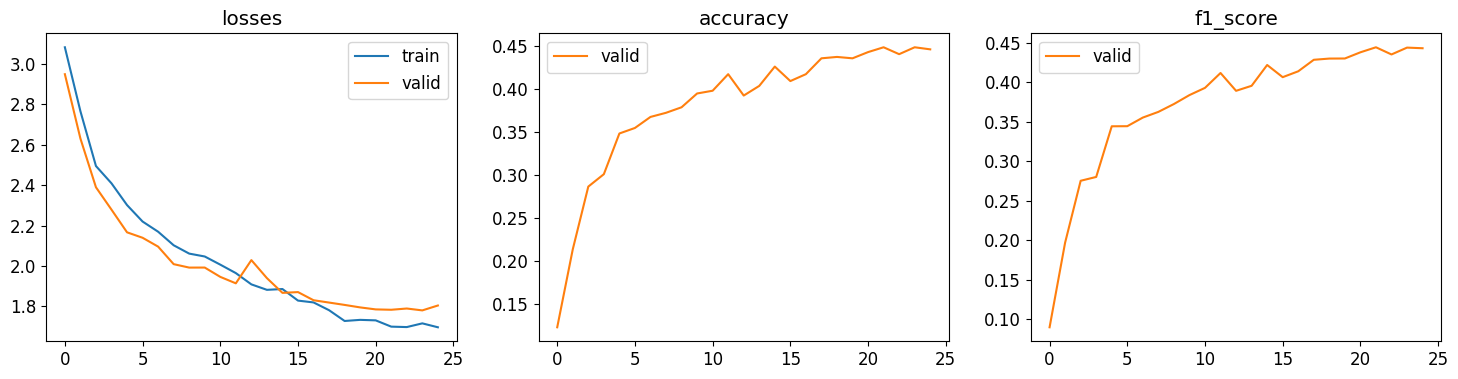

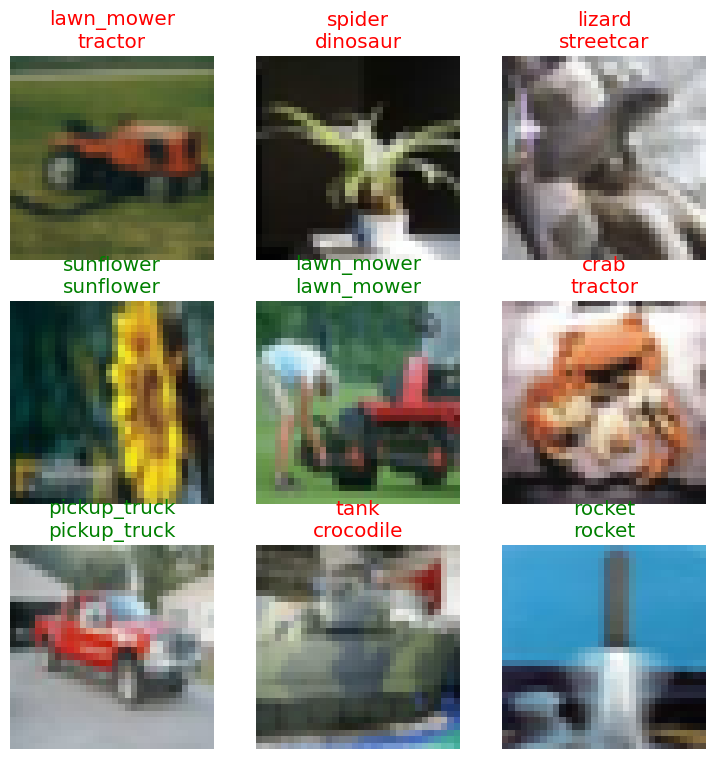

In [ ]:
learn.fit_one_cycle(n_epoch = 25, lr_max = lr.valley)
learn.recorder.plot_metrics()
learn.show_results()

The train accuracy is :  57.8311 %
The train f1-score is: 57.4284 %


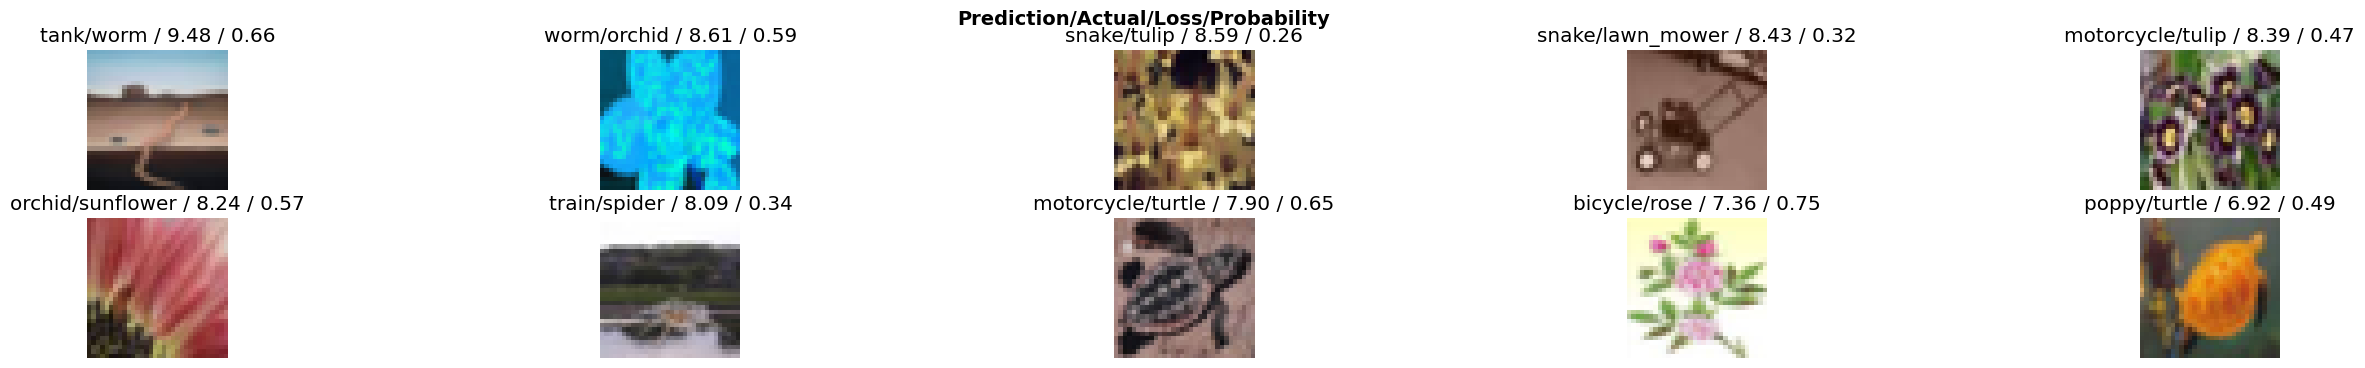

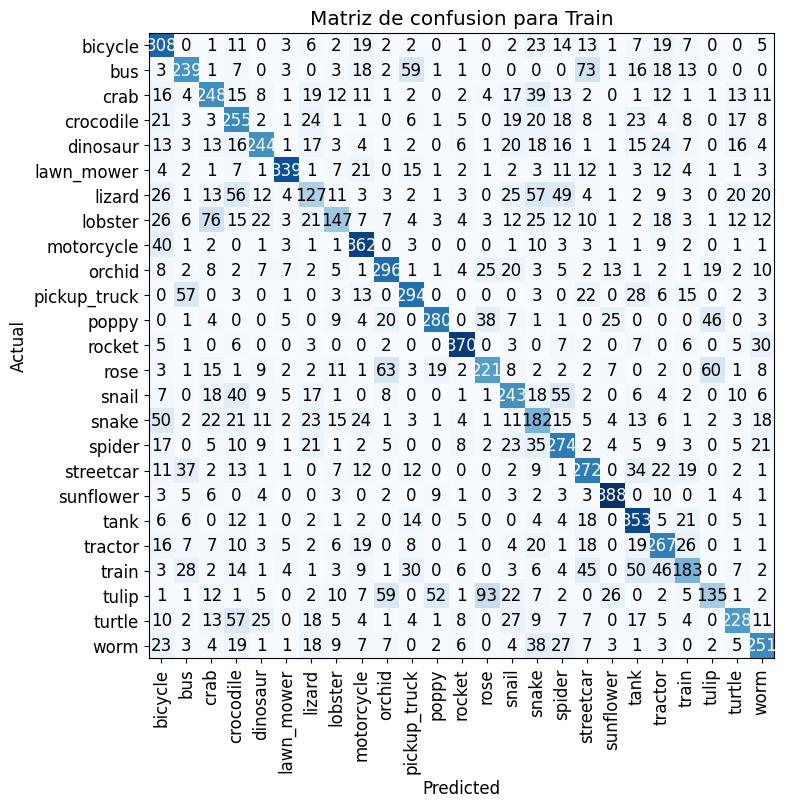

In [ ]:
from sklearn.metrics import f1_score

interp_train = ClassificationInterpretation.from_learner(learn, 1,augmentedTrainData.train)
interp_train.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=augmentedTrainData.train, with_decoded=True)

acc = accuracy(preds, targs)
f1 = f1_score(targs.cpu(), preds.argmax(dim=1).cpu(), average='weighted')
print('The train accuracy is : ', round(float(acc)*100, 4), '%')
print('The train f1-score is:', round(float(f1)*100, 4), '%')

interp_train.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Train')

The val accuracy is :  44.56 %
The val f1-score is: 44.2948 %


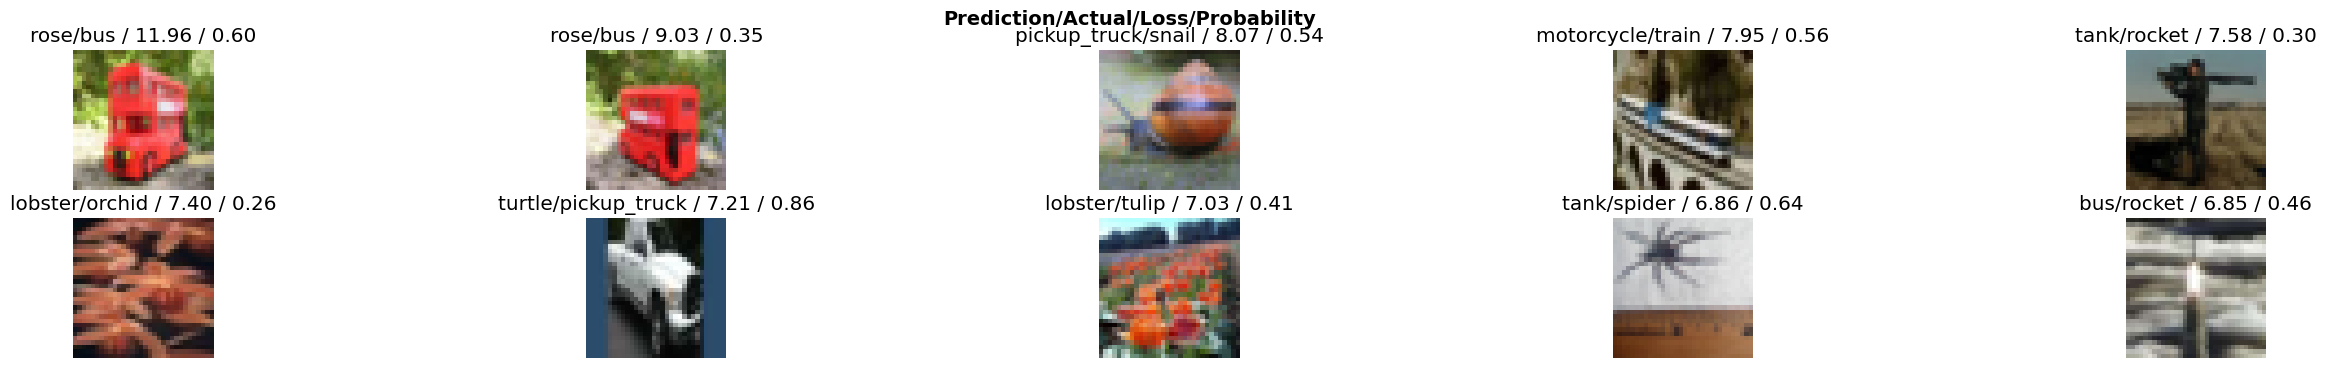

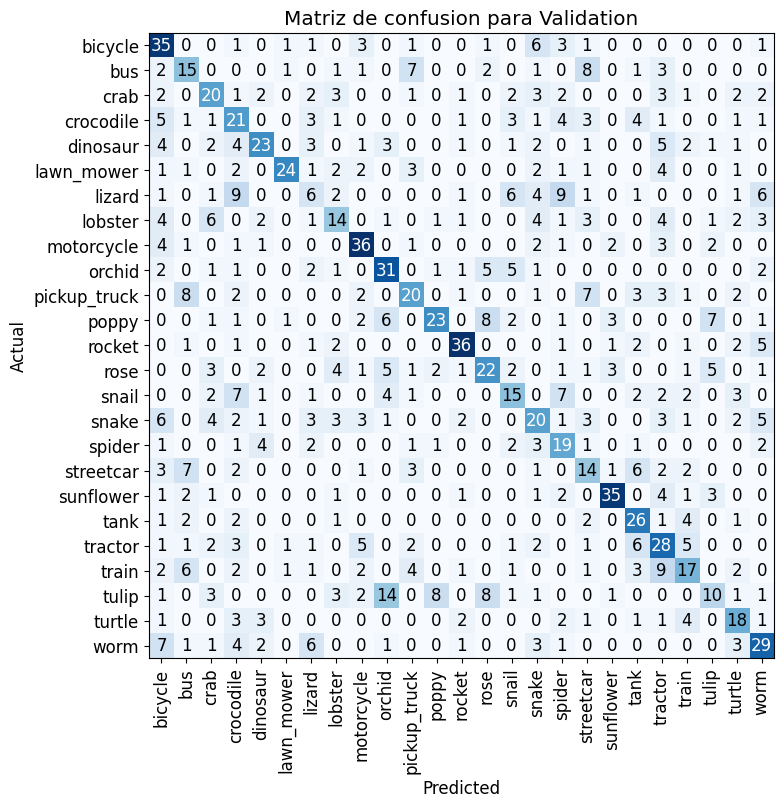

In [ ]:
interp_valid = ClassificationInterpretation.from_learner(learn, 1,augmentedTrainData.valid)

preds, targs, _ = learn.get_preds(dl=augmentedTrainData.valid, with_decoded=True)

acc = accuracy(preds, targs)
f1 = f1_score(targs.cpu(), preds.argmax(dim=1).cpu(), average='weighted')
print('The val accuracy is : ', round(float(acc)*100, 4), '%')
print('The val f1-score is:', round(float(f1)*100, 4), '%')

interp_valid.plot_top_losses(10, nrows=2, figsize=(32,4))
interp_valid.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Validation')

**Conclusiones sobre BaseNet6**

De las gráficas de entrenamiento para esta red, podemos observar que el entrenamiento y aprendizaje del modelo parece acercarse más a lo que buscamos, pues no hay un gran **generalization gap** y la red parece acercarse a lo que podríamos considerar un buen aprendizaje. Sin embargo, como para las redes anteriores, todavía falta algo más, pues los resultados obtenidos son bastante deficientes todavía (recordemos que buscamos como mínimo un $65\%$ en el conjunto de validación).

Este experimento demuestra realmente lo importante que es usar o no las capas de Pooling y la importancia de escoger una u otra. Dependiendo del problema, cada una de las conocemos puede venir mejor y escogerla no es algo trivial.

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Otra cosa importante aquí a comentar es lo relevante que es argumentar nuestras decisiones tomadas para la estrucutura de la red. Es muy importante **revisar la literatura** que hay al respecto pues nos puede dar muchas pistas de cómo modificar nuestra red. Estamos tratando con una ciencia en auge en la que lo empírico va por delante de lo teórico y, aunque no debemos obviar las razones teóricas de por qué funcionan las cosas, muchas veces es buena opción tomar como referencia modelos que ya se sabe que funcionan.

####**Red Final**

Después de haber hecho 6 modelos distintos, podemos extraer conclusiones fácilmente sobre el funcionamiento de las redes neuronales para este problema en concreto y, de ahí, construir finalmente nuestra red final.

$$$$

**¿Qué hemos aprendido de las anteriores BaseNet's?**

* Los **filtros pequeños**, en general, funcionan mejor.
* Aumentar la **profundidad** de la red nos proporciona un mejor aprendizaje pero hay que tener cuidado con el *overfitting*.
* Las capas de **BatchNormalization** y **Dropout** parecen funcionar muy bien, pues consiguen reducir el *overfitting* de las redes con muchos pesos. Sin embargo, hemos de tener cuidado con usar demasiadas redes de Dropout, así como la probabilidad con la que se desactivan las neuronas, pues puede ocurrir lo comentado de la diferencia entre el conjunto de validación y el de entrenamiento.
* Las técnicas de **data augmentation** parecen aumentar notablemente la capacidad de abstracción y generalización de la red.
* Las **capas de pooling** son bastante importantes y no es nada a menospreciar. El usarlas o no es determinante en el entrenamiento de las redes. Por tanto, para la última red trataremos de combinar las distintas técnicas que hemos usado.

$$$$

Para tener algún punto de referencia, usaremos las recomendaciones:

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> <font color = 'gray'> `INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]*3 -> [FC -> RELU]*2 -> FC` Here we see two CONV layers stacked before every POOL layer. This is generally a good idea for larger and deeper networks, because multiple stacked CONV layers can develop more complex features of the input volume before the destructive pooling operation. [https://cs231n.github.io/convolutional-networks/#layerpat]

Es decir, partiremos de esta base para crear una red que tenga más profundidad que las usadas hasta ahora, pues empíricamente parece ser que es una estructura bastante usada para el problema al que nos estamos enfrentando. A esta arquitectura, modificaremos y añadiremos lo aprendido hasta ahora.

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'>La siguiente explicación y posterior implementación de la red final es producto de varios experimentos realizados y de un refinamiento de algunos parámetros. No considero necesario mostrarlos pues, a nivel de estructura, no se ha ido cambiando mucho. Además, todos los cambios, decisiones y conclusiones sacadas se explican al final del ejercicio.

$$$$

**Nuestra red `BaseNetFinal`**: Tendrá 6 capas convolucionales (3 bloques), en las que usaremos cada dos, `MaxPool` y en la final de ella usaremos `AvgPool`, como hacíamos para BaseNet6. Seguidamente, añadiremos dos capas totalmente conectadas, para la parte clasificadora de la red. El número de filtros y pesos totales se discute más abajo.

En todas ellas añadiremos capas de BN, pues hemos comprobado que funcionan bien. Sin embargo, el Dropout lo trataremos con más delicadeza. Ya hemos comprobado en curvas de aprendizaje anteriores, que un exceso de probabilidad de anular neuronas, puede provocar un mejor rendimiento en validación que en entrenamiento, que no es nada ideal. Por tanto, añadiremos Dropout en todas las capas menos en la primera convolucional.

De manera adicional al entrenamiento de esta red, usaremos **Weight Decay**, como técnica regularizadora. Consiste en agregar una penalización proporcional a la magnitud de los pesos, normalmente representada como la suma de los cuadrados de los valores de los pesos. Esto fuerza al modelo a mantener los pesos pequeños, evitando soluciones excesivamente complejas. Basta con controlar el parámetro `wd = 0.01` del **Learner**.

> <img src = https://static.vecteezy.com/system/resources/previews/000/442/530/original/information-vector-icon.jpg height = '20' width = '20'> Comentar que aunque para las redes anteriores no hemos usado `EarlyStopping` ahora si lo haremos. No se ha hecho uso de esta técnica pues eran experimentos para observar directamente como iban funcionando cada una de las mejoras añadidas.

Vamos allá con la implementación y su entrenamiento:



In [ ]:
augmentedTrainData = dblock.dataloaders(path/'train', bs = 32, batch_tfms=[Normalize.from_stats(*cifar_stats),*aug_transforms()])

In [ ]:
BaseNetFinal = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 128, kernel_size = (3,3), padding = 'same'),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = (3,3), padding = 'same'),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2)),
    nn.Dropout(p = 0.25),

    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), padding = 'same'),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(p = 0.25),

    nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3,3), padding = 'same'),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2)),
    nn.Dropout(p = 0.5),

    nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3,3), padding = 'same'),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Dropout(p = 0.5),

    nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = (3,3), padding = 'same'),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((4,4)),
    nn.Dropout(p = 0.5),

    nn.Flatten(),
    nn.Linear(in_features = 4*4*128, out_features = 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(p = 0.5),

    nn.Linear(in_features = 100, out_features = 25)
)

learn = Learner(augmentedTrainData,
                BaseNetFinal,
                loss_func = CrossEntropyLossFlat(),
                metrics = [accuracy, F1Score(average='weighted')],
                opt_func = optim.Adam,
                wd=0.01,
                cbs = EarlyStoppingCallback(min_delta=0.01, patience=5)
                )

BaseNetFinal

Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Dropout(p=0.25, inplace=False)
  (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (16): Dropout(p=0.5, inpl

##### **Tabla de la arquitectura final**

Para hacer un buen resumen y mostrar la arquitectura final de nuestra red antes del entrenamiento, se muestra una **tabla** como la que se nos proporciona a nosotros en el enunciado, para mayor comprensión de la estructura resultante:

| Layer Type      | Kernel Size (for convolutional layers) | Input Dimension | Output Dimension | Input Channels | Output Channels |
|------------------|----------------------------------------|-----------------|------------------|----------------|-----------------|
| Conv            | 3x3                                    | 32x32           | 32x32            | 3              | 128             |
| BatchNorm       | -                                      | 32x32           | 32x32            | -              | -               |
| ReLU            | -                                      | 32x32           | 32x32            | -              | -               |
| Conv            | 3x3                                    | 32x32           | 32x32            | 128            | 64              |
| BatchNorm       | -                                      | 32x32           | 32x32            | -              | -               |
| ReLU            | -                                      | 32x32           | 32x32            | -              | -               |
| MaxPooling      | 2x2                                    | 32x32           | 16x16            | -              | -               |
| Dropout (0.25)  | -                                      | 16x16           | 16x16            | -              | -               |
| Conv            | 3x3                                    | 16x16           | 16x16            | 64             | 128             |
| BatchNorm       | -                                      | 16x16           | 16x16            | -              | -               |
| ReLU            | -                                      | 16x16           | 16x16            | -              | -               |
| Dropout (0.25)  | -                                      | 16x16           | 16x16            | -              | -               |
| Conv            | 3x3                                    | 16x16           | 16x16            | 128            | 128             |
| BatchNorm       | -                                      | 16x16           | 16x16            | -              | -               |
| ReLU            | -                                      | 16x16           | 16x16            | -              | -               |
| MaxPooling      | 2x2                                    | 16x16           | 8x8              | -              | -               |
| Dropout (0.5)   | -                                      | 8x8             | 8x8              | -              | -               |
| Conv            | 3x3                                    | 8x8             | 8x8              | 128            | 256             |
| BatchNorm       | -                                      | 8x8             | 8x8              | -              | -               |
| ReLU            | -                                      | 8x8             | 8x8              | -              | -               |
| Dropout (0.5)   | -                                      | 8x8             | 8x8              | -              | -               |
| Conv            | 3x3                                    | 8x8             | 8x8              | 256            | 128             |
| BatchNorm       | -                                      | 8x8             | 8x8              | -              | -               |
| ReLU            | -                                      | 8x8             | 8x8              | -              | -               |
| AdaptiveAvgPool | -                                      | 8x8             | 4x4              | -              | -               |
| Dropout (0.5)   | -                                      | 4x4             | 4x4              | -              | -               |
| Flatten         | -                                      | 4x4x128         | 2048             | -              | -               |
| Linear          | -                                      | 2048            | 100              | -              | -               |
| BatchNorm       | -                                      | 100             | 100              | -              | -               |
| ReLU            | -                                      | 100             | 100              | -              | -               |
| Dropout (0.5)   | -                                      | 100             | 100              | -              | -               |
| Linear          | -                                      | 100             | 25               | -              | -               |


##### **Análisis de red y de pesos**

Ahora tenemos que el output en las dos primeras dimensiones solo va a cambiar en las capas de pooling y los filtros que vamos a usar son de $3$x$3$. Vamos a analizar por capas entonces el número de pesos y las dimensiones del output para cada una de ellas:

1. Capa **convolucional** - Pesos: $3$ x $3$ x $3 + 1$ $\implies$ $128$ x $28 = 3584$

2. Capa **BN** - Pesos: $128$ x $2 = 256$

3. Capa **convolucional** - Pesos: $3$ x $3$ x $128 + 1$ $\implies$ $1153$ x $64 = 73792$

4. Capa **BN** - Pesos: $64$ x $2 = 128$

5. Capa **convolucional** - Pesos: $3$ x $3$ x $64 + 1$ $\implies$ $577$ x $128 = 73856$

6. Capa **BN** - Pesos: $128$ x $2 = 256$

7. Capa **convolucional** - Pesos: $3$ x $3$ x $128 + 1$ $\implies$ $1153$ x $128 = 147584$

8. Capa **BN** - Pesos: $128$ x $2 = 256$

9. Capa **convolucional** - Pesos: $3$ x $3$ x $128 + 1$ $\implies$ $1153$ x $256 = 295168$

8. Capa **BN** - Pesos: $256$ x $2 = 512$

9. Capa **convolucional** - Pesos: $3$ x $3$ x $256 + 1$ $\implies$ $2305$ x $128 = 295040$

8. Capa **BN** - Pesos: $128$ x $2 = 256$

9. Capa **FC** - Pesos: $(4$ x $ 4 $ x $ 128) + 1 \implies 100$ x $2049 = 204900$

10. Capa **BN** - Pesos: $100$ x $2 = 200$

13. Capa **FC** - Pesos: $(100 + 1)$ x $25 = 2525 $

**Pesos en total =  3584 + 256 + 73792 + 128 + 73856 + 256 + 147584 + 256 + 295168 + 512 + 295040 + 256 + 204900 + 200 + 2525 = 1,098,313**

Hacemos `summary()` para comprobar estos cálculos:

---



---



---

In [ ]:
learn.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 128 x 32 x 32  
Conv2d                                    3584       True      
BatchNorm2d                               256        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 32 x 32   
Conv2d                                    73792      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 16 x 16   
MaxPool2d                                                      
Dropout                                                        
____________________________________________________________________________
                     32 

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

Aproximación learning rate: 0.0014454397605732083


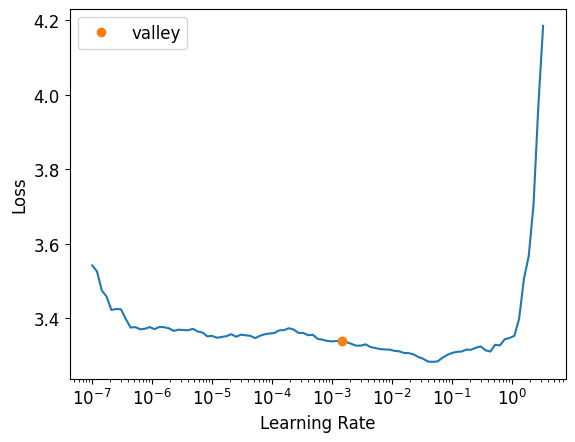

In [ ]:
lr = learn.lr_find()
print("Aproximación learning rate:", lr.valley)

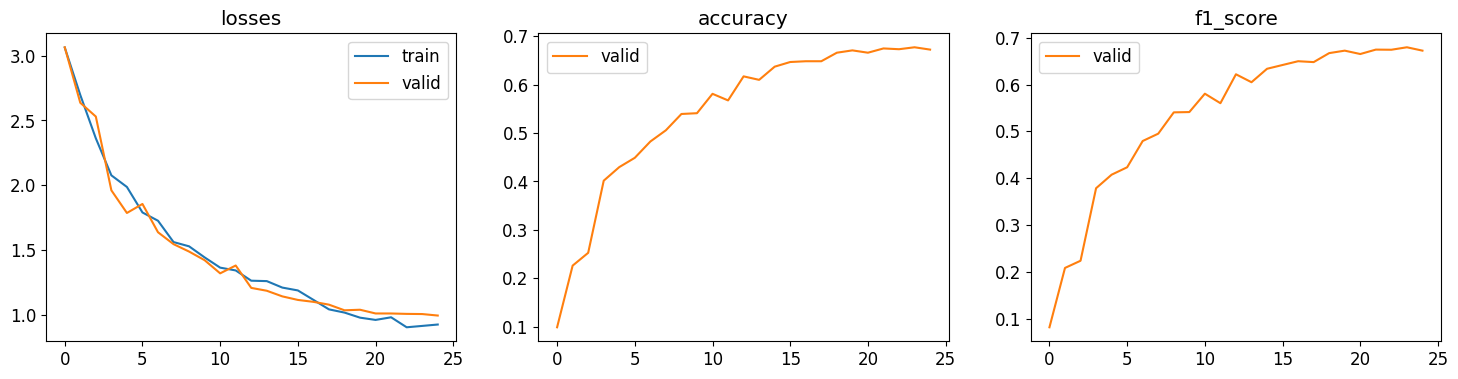

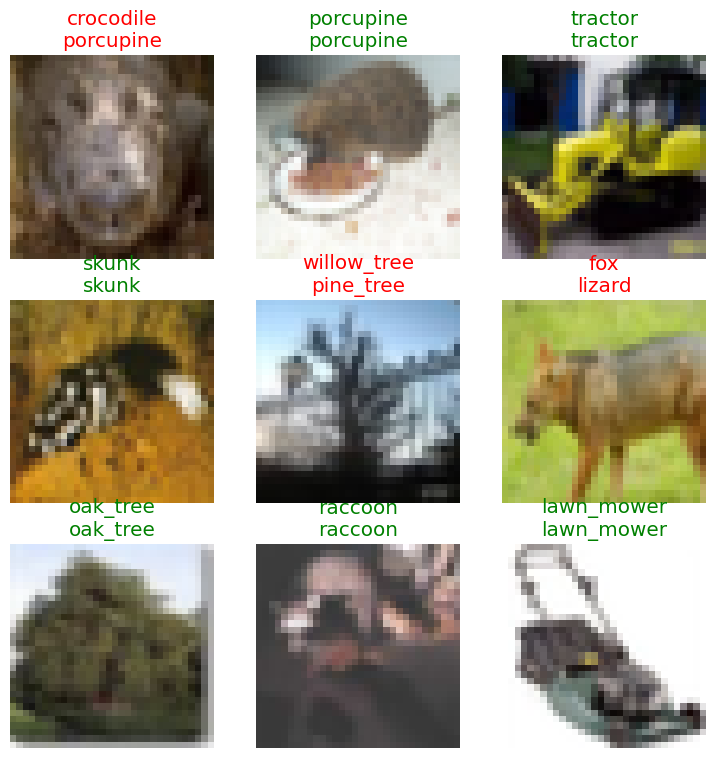

In [ ]:
learn.fit_one_cycle(n_epoch = 25, lr_max = lr.valley)
learn.recorder.plot_metrics()
learn.show_results()

The train accuracy is :  83.3067 %
The train f1-score is: 83.1168 %


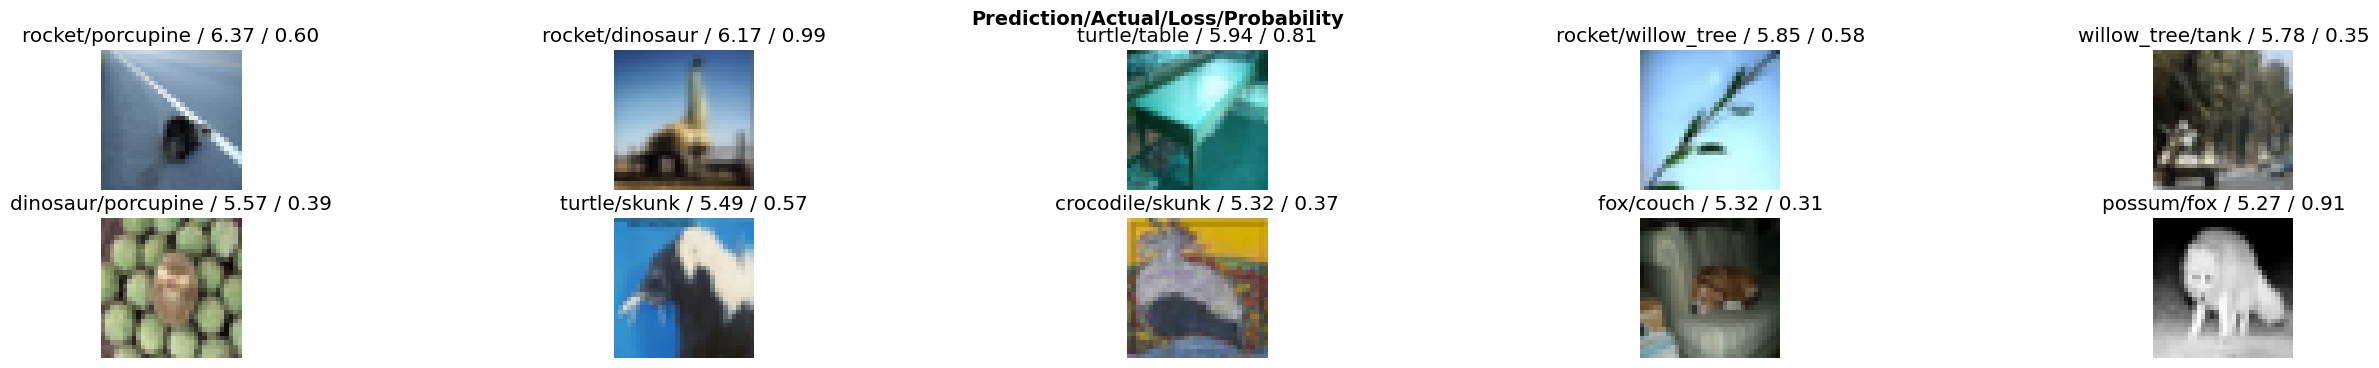

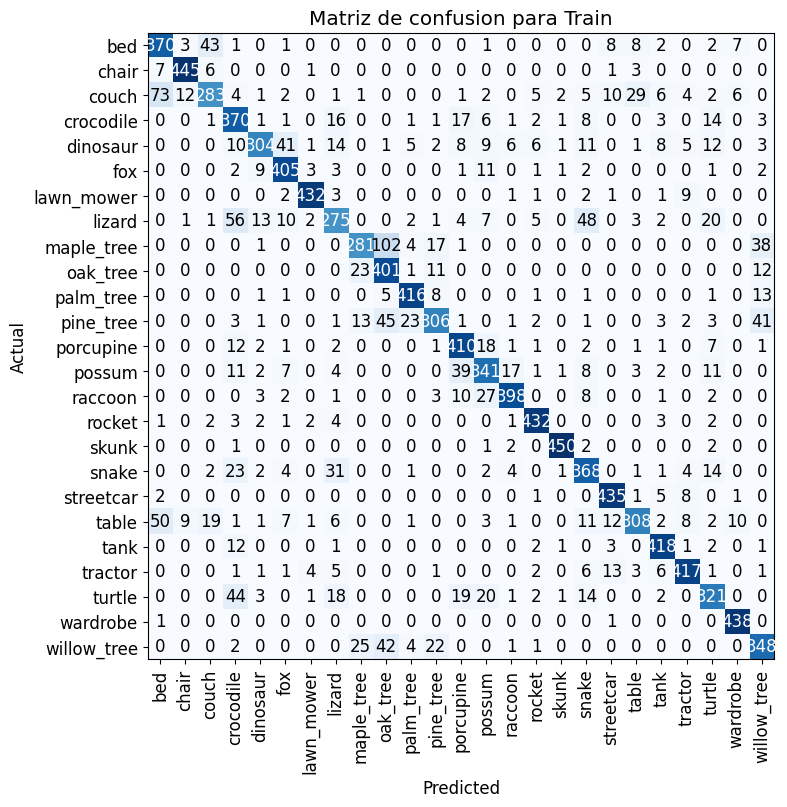

In [ ]:
from sklearn.metrics import f1_score

interp_train = ClassificationInterpretation.from_learner(learn, 1,augmentedTrainData.train)
interp_train.plot_top_losses(10, nrows=2, figsize=(32,4))

preds, targs, _ = learn.get_preds(dl=augmentedTrainData.train, with_decoded=True)

acc = accuracy(preds, targs)
f1 = f1_score(targs.cpu(), preds.argmax(dim=1).cpu(), average='weighted')
print('The train accuracy is : ', round(float(acc)*100, 4), '%')
print('The train f1-score is:', round(float(f1)*100, 4), '%')

interp_train.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Train')

The val accuracy is :  67.2 %
The val f1-score is: 67.2272 %


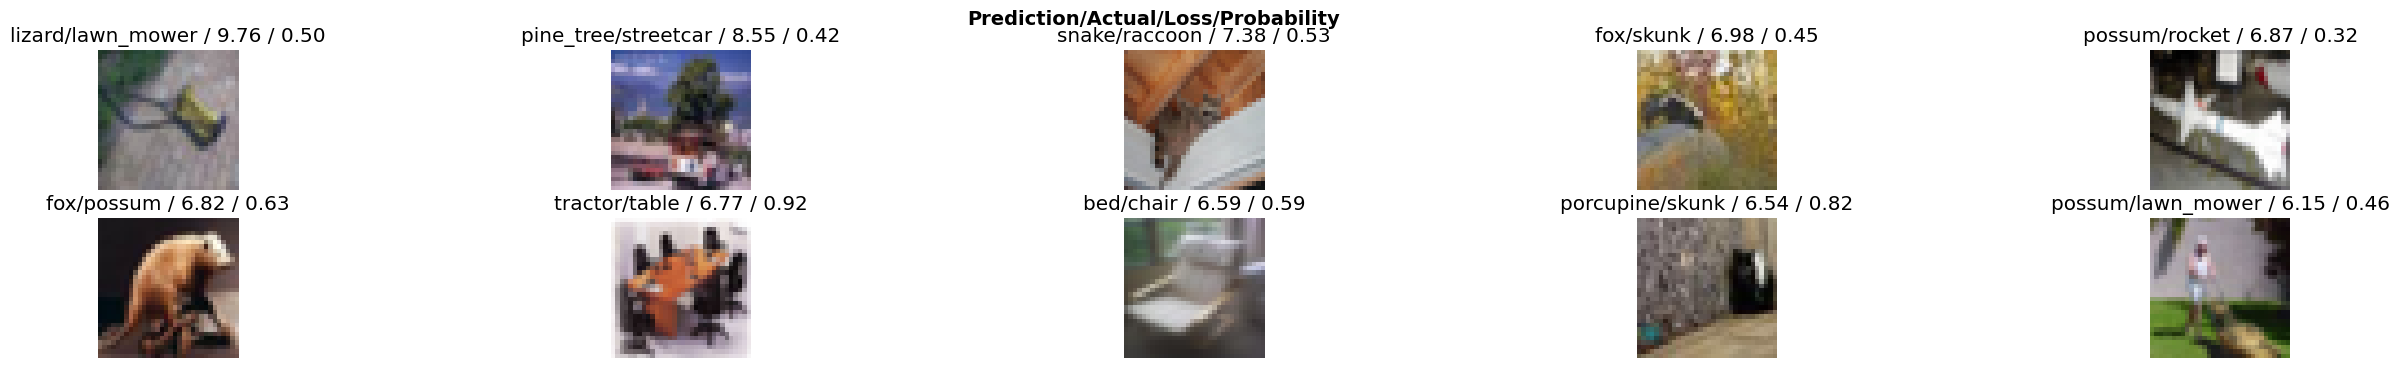

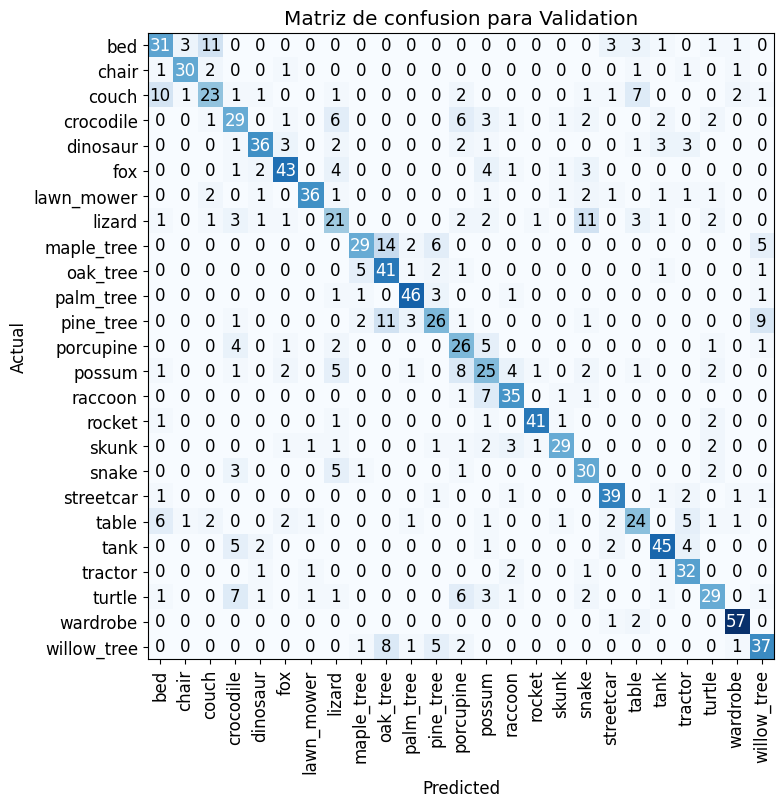

In [ ]:
interp_valid = ClassificationInterpretation.from_learner(learn, 1,augmentedTrainData.valid)

preds, targs, _ = learn.get_preds(dl=augmentedTrainData.valid, with_decoded=True)

acc = accuracy(preds, targs)
f1 = f1_score(targs.cpu(), preds.argmax(dim=1).cpu(), average='weighted')
print('The val accuracy is : ', round(float(acc)*100, 4), '%')
print('The val f1-score is:', round(float(f1)*100, 4), '%')

interp_valid.plot_top_losses(10, nrows=2, figsize=(32,4))
interp_valid.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Validation')

Conseguimos en entrenamiento un $83\%$ tanto de *accuracy* como de *f1Score*. En validación, nos quedamos en un $67\%$. En general, en todos los modelos probados para la red final, el overfitting era mucho mayor. Mediante el uso de Dropout, se consigue aminorar este efecto.

<img src = https://cdn.pixabay.com/photo/2016/03/31/14/37/check-mark-1292787_1280.png height = '20' width = '20'> En general, creo que se ha llegado a un buen entrenamiento de la red. Las matrices de confusión parecen ser bastante aceptables, con un balance bueno tanto en positivos(diagonal) como en negativos. El objetivo principal que me había marcado para este apartado no era el de conseguir muy buenos resultados en validación ni en entrenamiento, era el de entender para qué sirve cada una de las mejoras por separado y en conjunto, y conseguir unas curvas de aprendizaje suaves y sin demasiado overfitting.

$$$$

#####**Historial de mejoras**

Ahora que ya tenemos un modelo que parece estar funcionando de una buena forma, pues como hemos discutido parece aprender de las imágenes de manera razonable y obtenemos los resultados esperados, podemos hacer un breve análisis y recopilación del proceso de mejora de la red BaseNet. Para ello, recopilamos y mostramos en la siguientes gráficas el **accuracy**, **f1_score** (en entrenamiento y validación):

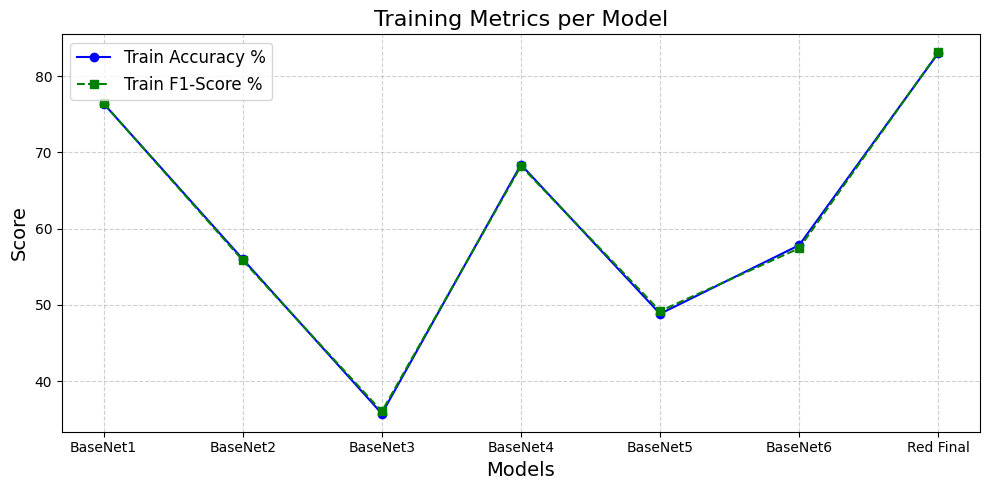

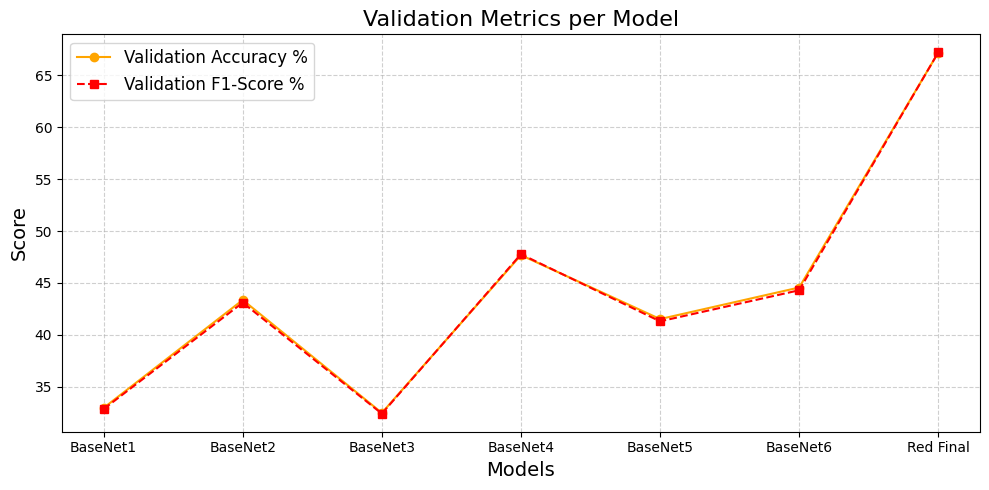

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['BaseNet1', 'BaseNet2', 'BaseNet3', 'BaseNet4', 'BaseNet5', 'BaseNet6', 'Red Final']

train_accuracy = [76.3911, 56.0089, 35.7422, 68.3911, 48.8267, 57.8311, 83]
train_f1_score = [76.4052, 55.838, 36.0255, 68.2064, 49.1878, 57.4284, 83.1]

val_accuracy = [32.96, 43.36, 32.48, 47.68, 41.52, 44.56, 67.2]
val_f1_score = [32.8486, 43.1024, 32.4061, 47.7724, 41.3023, 44.2948, 67.212]

plt.figure(figsize=(10, 5))
plt.plot(models, train_accuracy, label='Train Accuracy %', marker='o', linestyle='-', color='blue')
plt.plot(models, train_f1_score, label='Train F1-Score %', marker='s', linestyle='--', color='green')
plt.title('Training Metrics per Model', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(models, val_accuracy, label='Validation Accuracy %', marker='o', linestyle='-', color='orange')
plt.plot(models, val_f1_score, label='Validation F1-Score %', marker='s', linestyle='--', color='red')
plt.title('Validation Metrics per Model', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Parece positivo ver cómo se ha ido probando, perdiendo y ganando métricas en cada uno de los modelos, para finalmente obtener muy buenos resultados en la red final. Nuestra curva de aprendizaje no decrece al minimizar una función, de hecho crece😊



##### **Inferencia en test y conclusiones**

The test accuracy is :  69.12 %
The test f1-score is: 68.8988 %


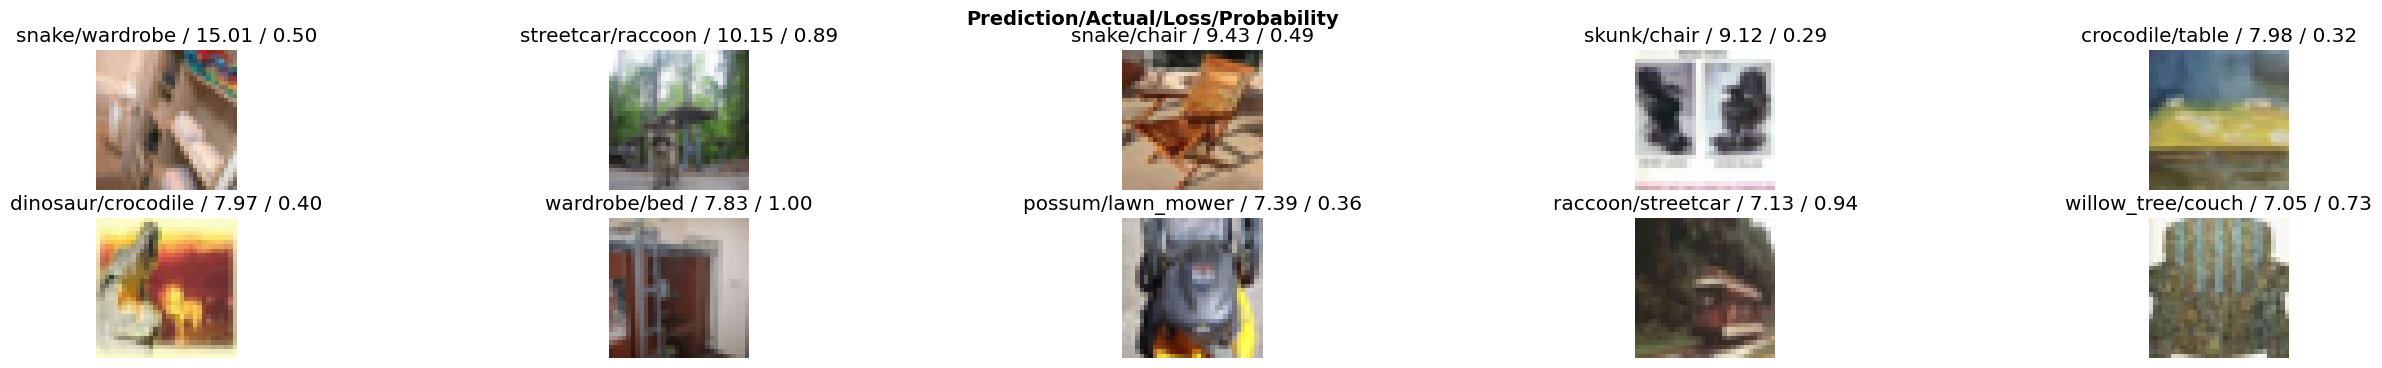

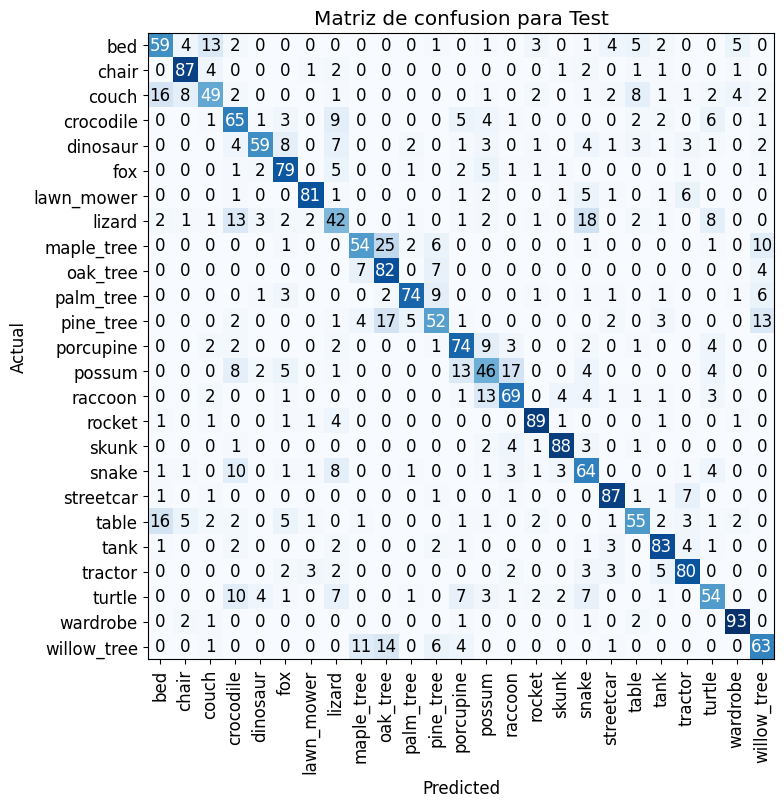

In [ ]:
test_dl = learn.dls.test_dl(files_test,with_labels=True)

preds, targs, _ = learn.get_preds(dl=test_dl, with_decoded=True)


acc = accuracy(preds, targs)
f1 = f1_score(targs.cpu(), preds.argmax(dim=1).cpu(), average='weighted')
print('The test accuracy is : ', round(float(acc)*100, 4), '%')
print('The test f1-score is:', round(float(f1)*100, 4), '%')

interp_test = ClassificationInterpretation.from_learner(learn, 1,test_dl)
interp_test.plot_top_losses(10, nrows=2, figsize=(32,4))
interp_test.plot_confusion_matrix(figsize= (8,8), title = 'Matriz de confusion para Test')

En test conseguimos un resultado bastante similar al de validación, pues conseguimos un $69\%$ y $68\%$ en accuracy y f1score, respectivamente.

**Hold out**: Nuestro objetivo es aproximar el error fuera de la muestra mediante el error que obtengamos en test, esto es:
 $$E_{out} \approx E_{test}$$

 Por tanto, podremos estimar cómo se comportaría nuestro modelo en una situación real con otros datos como input. Cerca del $70\%$, consideramos que es aceptable para un problema de clasificación de imágenes como es CIFAR100.

$$$$

**¿Qué se ha aprendido tras completar con éxito el ejercicio?**

Tras distintas ejecuciones del modelo final, aunque, en esencia, la estructura y la arquitectura se ha cambiado un poco, ha sido crucial la elección de número de filtros en las convolucionales, eliminar y modificar algunas capas de dropout, quitar la última capa FC...etc. Por tanto, se enumeran ahora las causas por las que creo que sí que ha funcionado el modelo final, de manera correcta y los anteriores no lo han hecho, así como el proceso de aprendizaje que se ha hecho hasta llegar a `BaseNetFinal`:

* **Nº de filtros en las primeras capas convolucionales**: En algunos de los entrenamientos, se conseguía siempre un buen resultado en entrenamiento, pero ni aumentando el número de parámetros se conseguía subir del 60% de *accuracy* en validación. Al incrementar el número de filtros usados en la primeras capas a 128, a mi parecer, se ha dado mucha más importancia a las características de más alto nivel. Y esto tiene sentido, pues realmente estamos trabajando con **imágenes bastante pequeñas**(32x32) y en el momento que se hace *subsampling* perdemos información de ellas. Es importante retener información de calidad en las primeras etapas de la red.

* Las **capas de Dropout** es más recomendable usarlas en las últimas etapas de la red. Aunque de cierta manera, puedan enriquecer el entrenamiento en las primeras capas, nuestro objetivo es extraer buenas características y, si aplicamos Dropout, estamos limitando esta capacidad.

* Usar 2 **capas Fully Connected** antes de la última de clasificación, resultaba en un gran sobreajuste. Es por esto que la reducimos a una única capa, que con un número suficiente de parámetros es capaz de clasificar correctamente las imágenes.

* Es de gran relevancia prestar atención a las **curvas de aprendizaje**. Es crucial entender el proceso de aprendizaje que está realizando la red, pues nos da indicaciones de la calidad de los cambios introducidos tanto para bien como para mal.

* No es necesario **aumentar en demasía el número de parámetros**. De hecho, en algún experimento realizado, ha llegado a entorpecer más que a ayudar, pues al aumentar el número de pesos se debía de aumentar a la par la regularización hecha a la red.

* Se ha sacrificado en algunos de los experimentos accuracy y F1score en validación: en algunos entrenamientos, se ha llegado a obtener un 75% de accuracy en las métricas de validación. Esto era a cambio de un gran sobreajuste, llegando a casi el 95% en entrenamiento. Introducir una mayor regularización ha hecho que tengamos los resultados que tenemos. Queremos que el sobreajuste sea el menor posible y la red sea capaz de generalizar lo máximo posible.

* Por la parte positiva, sí que se ha experimentado con todas las técnicas explicadas e implementadas en los modelos anteriores, y parecen haber funcionado correctamente.



$$$$

Por último, cabe remarcar que se ha creado una red bastante simple. Simple en el sentido de que, a día de hoy, hay técnicas estado del arte que se conoce que mejoran, y con creces, a este tipo de **red convolucional clásica** para el problema de clasificación de imágenes etiquetadas. De ahí el estudio de las mismas en teoría.

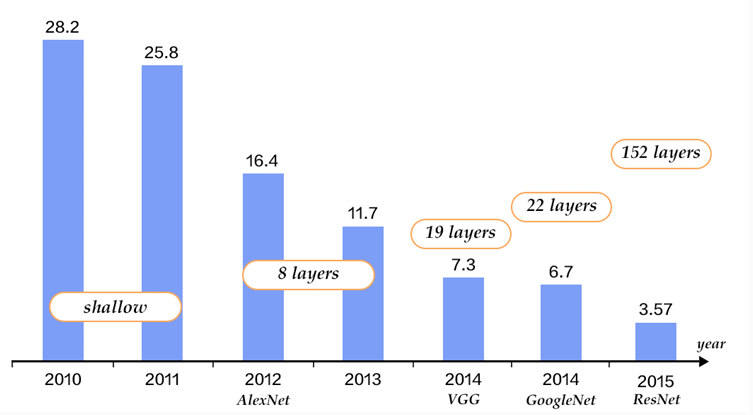

